### Visualisation and time-series analysis

<span style="font-size: 12pt;">This notebook shows the visualisation and time-series analysis of the processed dataset stored on Hadoop.</span>

<br>

#### 1. Apache Spark

<br>

In [1]:
sc # check pyspark status

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
sc.master # check master

'local[*]'

In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import data from Hadoop using Spark
file_path = "/sentiment/climate_change_sentiment.csv"

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Time-series analysis").getOrCreate()

climate_change = spark.read.format("csv").option("header", "true").option("multiline", "true").load(file_path)
climate_change.show(3)

+----------+--------------------+---------+
|      date|               texts|sentiment|
+----------+--------------------+---------+
|2021-09-01|absolutely blunt ...|   0.9894|
|2021-09-01|canada essentiall...|  -0.1531|
|2021-09-01| come climate change|        0|
+----------+--------------------+---------+
only showing top 3 rows



In [5]:
# Check missing value
from pyspark.sql.functions import col, count, when

# Count the number of missing values in each column
missing_values = climate_change.select([count(when(col(c).isNull(), c)).alias(c) for c in climate_change.columns])

# Display the missing value counts
missing_values.show()

+----+-----+---------+
|date|texts|sentiment|
+----+-----+---------+
|   0|    0|        0|
+----+-----+---------+



In [6]:
# Add new column "category" based on sentiments
from pyspark.sql.types import DoubleType

climate_change = climate_change.withColumn("sentiment", climate_change["sentiment"].cast(DoubleType()))
climate_change = climate_change.withColumn(
    "category", when(climate_change.sentiment > 0, "positive").when(climate_change.sentiment < 0, "negative").otherwise("neutral"))

climate_change.show(5)

+----------+--------------------+---------+--------+
|      date|               texts|sentiment|category|
+----------+--------------------+---------+--------+
|2021-09-01|absolutely blunt ...|   0.9894|positive|
|2021-09-01|canada essentiall...|  -0.1531|negative|
|2021-09-01| come climate change|      0.0| neutral|
|2021-09-01|communism mean wo...|    0.872|positive|
|2021-09-01|data always lined...|   0.4939|positive|
+----------+--------------------+---------+--------+
only showing top 5 rows



<br>

#### 2. Convert to pandas dataframe

<br>

In [7]:
# Import mandatory libraries
import pandas as pd

In [8]:
# Change to pandas dataframe
climate_change_sentiment = climate_change.toPandas()
climate_change_sentiment.head()

,date,texts,sentiment,category
0,2021-09-01,absolutely blunt care person want power canada...,0.9894,positive
1,2021-09-01,canada essentially upgraded version united sta...,-0.1531,negative
2,2021-09-01,come climate change,0.0000,neutral
3,2021-09-01,communism mean worker compensated worker contr...,0.8720,positive
4,2021-09-01,data always lined predicted faster expected pl...,0.4939,positive


In [9]:
climate_change_sentiment.shape

(7300, 4)

In [10]:
climate_change_sentiment.duplicated().sum()

6

In [11]:
# Check what is duplicating
duplicate_bool = climate_change_sentiment.duplicated(
    subset = ["date", "texts", "sentiment", "category"], 
    keep = "first")
duplicate = climate_change_sentiment.loc[duplicate_bool == True]
duplicate

,date,texts,sentiment,category
642,2021-10-03,climate change,0.0000,neutral
2126,2021-12-16,climate change,0.0000,neutral
2325,2021-12-26,climate change,0.0000,neutral
3952,2022-03-17,nft proarguments argument written mrmoustachem...,0.9986,positive
4925,2022-05-05,climate change,0.0000,neutral
6464,2022-07-21,climate change isnt real,0.0000,neutral


<br>

<span style="font-size: 12pt;">*The potential reason of the duplicated items showing above is that the comments people posted are the same, for example "climate change". However, these are still opnions from different person. In order to avoid bias, these duplicates were not dropped.*</span>

<br>

In [12]:
climate_change_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       7300 non-null   object 
 1   texts      7300 non-null   object 
 2   sentiment  7300 non-null   float64
 3   category   7300 non-null   object 
dtypes: float64(1), object(3)
memory usage: 228.2+ KB


In [13]:
# Convert "date" type
climate_change_sentiment["date"] = pd.to_datetime(climate_change_sentiment["date"])
climate_change_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       7300 non-null   datetime64[ns]
 1   texts      7300 non-null   object        
 2   sentiment  7300 non-null   float64       
 3   category   7300 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 228.2+ KB


<br>

- <span style="font-size: 14pt;">***visualisation***</span>

<br>

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

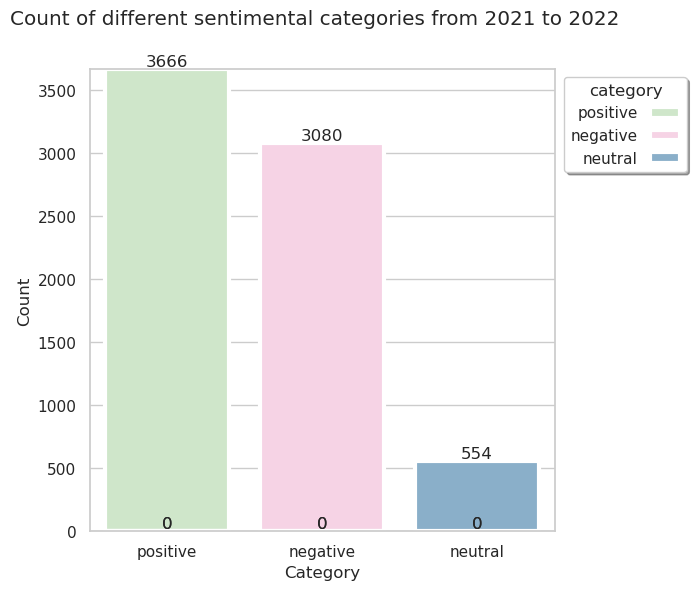

In [29]:
# Visualise the value counts in "category"
category_counts = climate_change_sentiment["category"].value_counts()

fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Count of different sentimental categories from 2021 to 2022")

sns.set_theme(style="whitegrid")

ranks = climate_change_sentiment["category"].sort_values().index

palette = sns.color_palette("Set3", len(ranks))

sns.countplot(ax=axes, data=climate_change_sentiment, x="category",
              linewidth=3, hue="category",
              palette = np.array(palette)[ranks], dodge = False)

axes.set_xlabel("Category")
axes.set_ylabel("Count")

plt.legend(title="category", bbox_to_anchor=(1.3, 1),
           frameon=True, ncol=1,
           markerfirst=False, shadow=True)

for container in axes.containers:
    axes.bar_label(container)

axes.set_ylim(0, max(category_counts))

plt.show()

In [16]:
# Create a new dataframe {sentiment} only contains "date" and "sentiment"
sentiment = climate_change_sentiment[["date", "sentiment"]].copy()
sentiment.tail(6)

,date,sentiment
7294,2022-08-31,-0.3408
7295,2022-08-31,0.9879
7296,2022-08-31,0.8360
7297,2022-08-31,0.6597
7298,2022-08-31,0.4031
7299,2022-08-31,0.7430


In [17]:
# Aggregate the average of the sentiments based on "date"
sentiment_final = sentiment.groupby("date")["sentiment"].mean().reset_index()
sentiment_final.columns = ["date", "average sentiment"]
sentiment_final.head()

,date,average sentiment
0,2021-09-01,0.066240
1,2021-09-02,0.056645
2,2021-09-03,0.006905
3,2021-09-04,0.062800
4,2021-09-05,-0.087550


In [18]:
# Add "category" and assign to a new dataframe
sentiment_final_category = sentiment_final.copy()
sentiment_final_category["category"] = pd.cut(sentiment_final_category["average sentiment"], 
                                              bins=[-float("inf"), 0, float("inf")], 
                                              labels=["negative", "positive"])

sentiment_final_category.head(8)

,date,average sentiment,category
0,2021-09-01,0.066240,positive
1,2021-09-02,0.056645,positive
2,2021-09-03,0.006905,positive
3,2021-09-04,0.062800,positive
4,2021-09-05,-0.087550,negative
5,2021-09-06,-0.000375,negative
6,2021-09-07,-0.201935,negative
7,2021-09-08,0.074290,positive


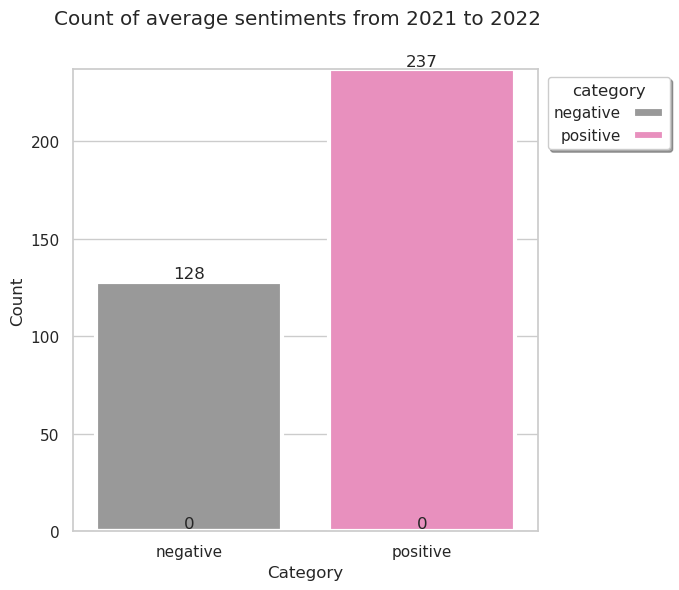

In [19]:
# Visualise the value counts of average sentiments
category_counts2 = sentiment_final_category["category"].value_counts()

fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Count of average sentiments from 2021 to 2022")

sns.set_theme(style="whitegrid")

ranks = sentiment_final_category["category"].sort_values().index

palette = sns.color_palette("Set1", len(ranks))

sns.countplot(ax=axes, data=sentiment_final_category, x="category",
              linewidth=3, hue="category",
              palette = np.array(palette)[ranks], dodge = False)

axes.set_xlabel("Category")
axes.set_ylabel("Count")

plt.legend(title="category", bbox_to_anchor=(1.3, 1),
           frameon=True, ncol=1,
           markerfirst=False, shadow=True)

for container in axes.containers:
    axes.bar_label(container)

axes.set_ylim(0, max(category_counts2))

plt.show()

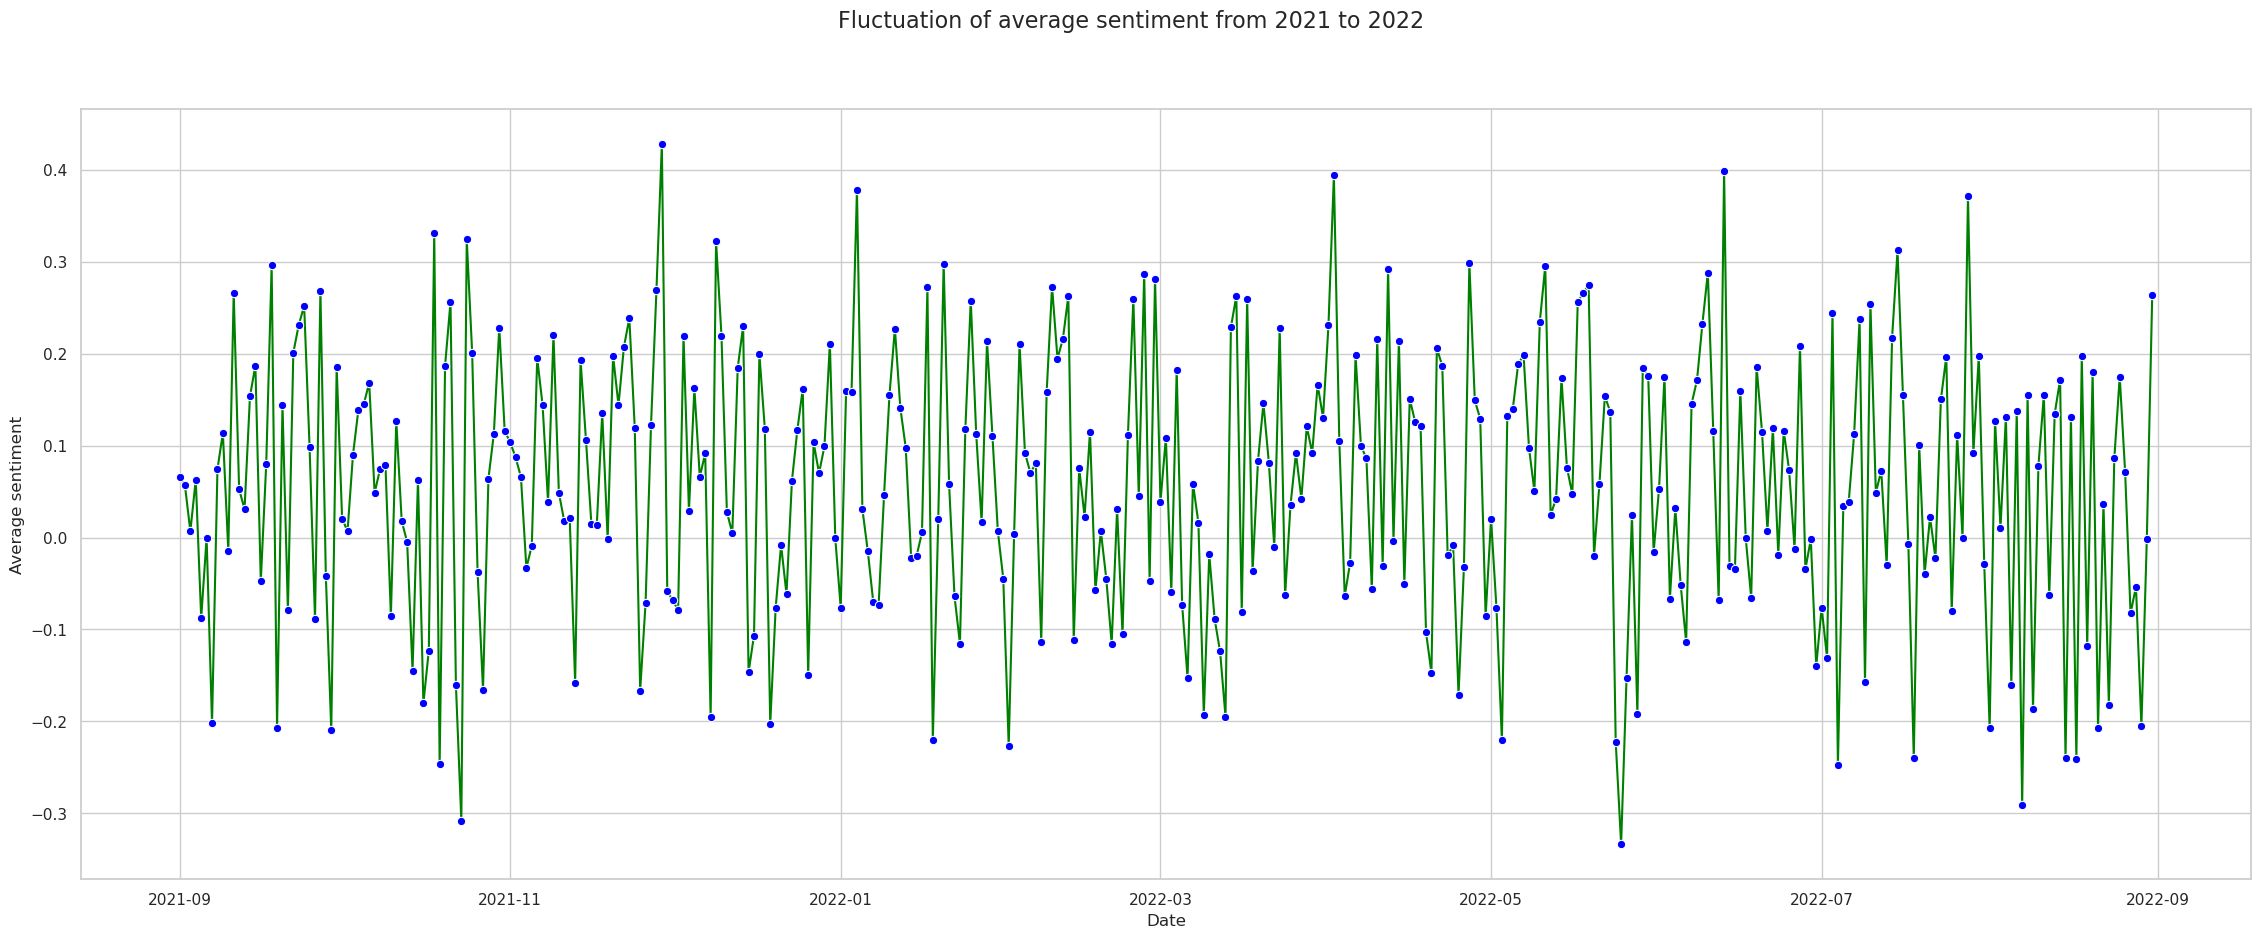

In [20]:
# Visualise the average sentiment change over time
fig, axes = plt.subplots(figsize=(28, 10))
fig.suptitle("Fluctuation of average sentiment from 2021 to 2022", fontsize=16)

sns.set_theme(style="whitegrid")

sns.lineplot(data=sentiment_final, x="date", y="average sentiment", 
             marker="o", linestyle="-", color="green", markerfacecolor="blue")

axes.set_xlabel("Date")
axes.set_ylabel("Average sentiment")

plt.show()

<br>

<span style="font-size: 12pt;">The average sentiment from 2021-09-01 to 2022-08-31 reaches its highest around the end of November 2021, however, its lowest near the beginning of June 2022.</span>

<br>

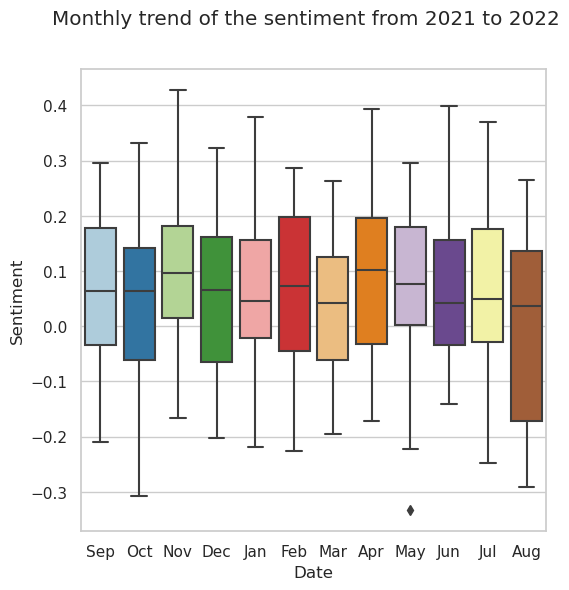

In [21]:
# Visualise monthly trend over the whole year
monthly_sentiment = sentiment_final.copy()
monthly_sentiment.reset_index(inplace=True)
monthly_sentiment["month"] = [d.strftime("%b") for d in sentiment_final.date]

fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Monthly trend of the sentiment from 2021 to 2022")

sns.set_theme(style="whitegrid")

sns.boxplot(data=monthly_sentiment, x="month", y="average sentiment", palette="Paired")

axes.set_xlabel("Date")
axes.set_ylabel("Sentiment")

plt.show()

<br>

<span style="font-size: 12pt;">People have an obvious tendency to leave more negative comments about climate change in August 2022, and a slight tendency to talk more positively about it in Jan 2022. Fairly even in the rest months.</span>
<span style="font-size: 12pt;">Overall, the changing is mild. Notably, there is an "extreme" negative comment at May 2022.</span>

<br>

- <span style="font-size: 14pt;">***time-series analysis***</span>

<br>

In [22]:
sentiment_final.head()

,date,average sentiment
0,2021-09-01,0.066240
1,2021-09-02,0.056645
2,2021-09-03,0.006905
3,2021-09-04,0.062800
4,2021-09-05,-0.087550


In [23]:
# Save data to local machine
sentiment_final.to_csv("climate_change_sentiment.csv", index = None, header = True)

In [1]:
# Import libraries again if skipping the steps above

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read from local to make the repetitive model training easier
final = pd.read_csv("climate_change_sentiment.csv")
final.tail()

,date,average sentiment
360,2022-08-27,-0.082510
361,2022-08-28,-0.053495
362,2022-08-29,-0.205270
363,2022-08-30,-0.001860
364,2022-08-31,0.264050


<br>

<span style="font-size: 12pt;">**stationary status**</span>

In [3]:
# Test whether the data is stationary
from statsmodels.tsa.stattools import adfuller, kpss

# Perform the ADF (Augmented Dickey Fuller) test
adf_result = adfuller(final["average sentiment"])
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]

# Perform the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test
kpss_result = kpss(final["average sentiment"])
kpss_statistic = kpss_result[0]
kpss_p_value = kpss_result[1]

# Print the test results
print(f'ADF Statistic: {adf_statistic:.4f}')
print(f'ADF p-value: {adf_p_value:.4f}')
print(f'KPSS Statistic: {kpss_statistic:.4f}')
print(f'KPSS p-value: {kpss_p_value:.4f}')

ADF Statistic: -19.0966
ADF p-value: 0.0000
KPSS Statistic: 0.1438
KPSS p-value: 0.1000


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<br>

<span style="font-size: 12pt;">The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the p-Value in ADF test is less than the significance level (0.05), we reject the null hypothesis. The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the p-Value interpretation is just the opposite of ADH test.</span>

<span style="font-size: 12pt;">The results above confirm that the time-series data is stationary.</span>

<br>

<span style="font-size: 12pt;">**analysis**</span>

In [4]:
final.head()

,date,average sentiment
0,2021-09-01,0.066240
1,2021-09-02,0.056645
2,2021-09-03,0.006905
3,2021-09-04,0.062800
4,2021-09-05,-0.087550


In [5]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               365 non-null    object 
 1   average sentiment  365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


<br>

- **ForecasterAutoreg**

In [6]:
#!pip3 install skforecast --user

In [7]:
# Import libries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [8]:
data = final.copy()
data["date"] = pd.to_datetime(data["date"], format='%Y/%m/%d')
data = data.set_index("date")
data = data.asfreq('D')
data = data.sort_index()
data.head()

,average sentiment
date,
2021-09-01,0.066240
2021-09-02,0.056645
2021-09-03,0.006905
2021-09-04,0.062800
2021-09-05,-0.087550


In [9]:
# Verify that a temporary index is complete
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [10]:
# Split data into train-test
steps = 45
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2021-09-01 00:00:00 --- 2022-07-17 00:00:00  (n=320)
Test dates  : 2022-07-18 00:00:00 --- 2022-08-31 00:00:00  (n=45)


In [11]:
def train_test_lineplot(title, train_data, test_data):
    fig, axes = plt.subplots(figsize=(28, 10))
    fig.suptitle(title, fontsize=16)

    sns.set_theme(style="whitegrid")

    sns.lineplot(data=train_data, x="date", y="average sentiment",
                 linestyle="-", color="blue")
    sns.lineplot(data=test_data, x="date", y="average sentiment",
                 linestyle="-", color="green")

    axes.set_xlabel("Date")
    axes.set_ylabel("Sentiment")

    # Create proxy artists for the legend entries
    train_proxy = plt.Line2D([], [], linestyle="-", color="blue", label="train")
    test_proxy = plt.Line2D([], [], linestyle="-", color="green", label="test")

    # Create the legend
    plt.legend(handles=[train_proxy, test_proxy], loc="upper center",
               bbox_to_anchor=(0.5, 1.05), ncol=2)

    plt.show()

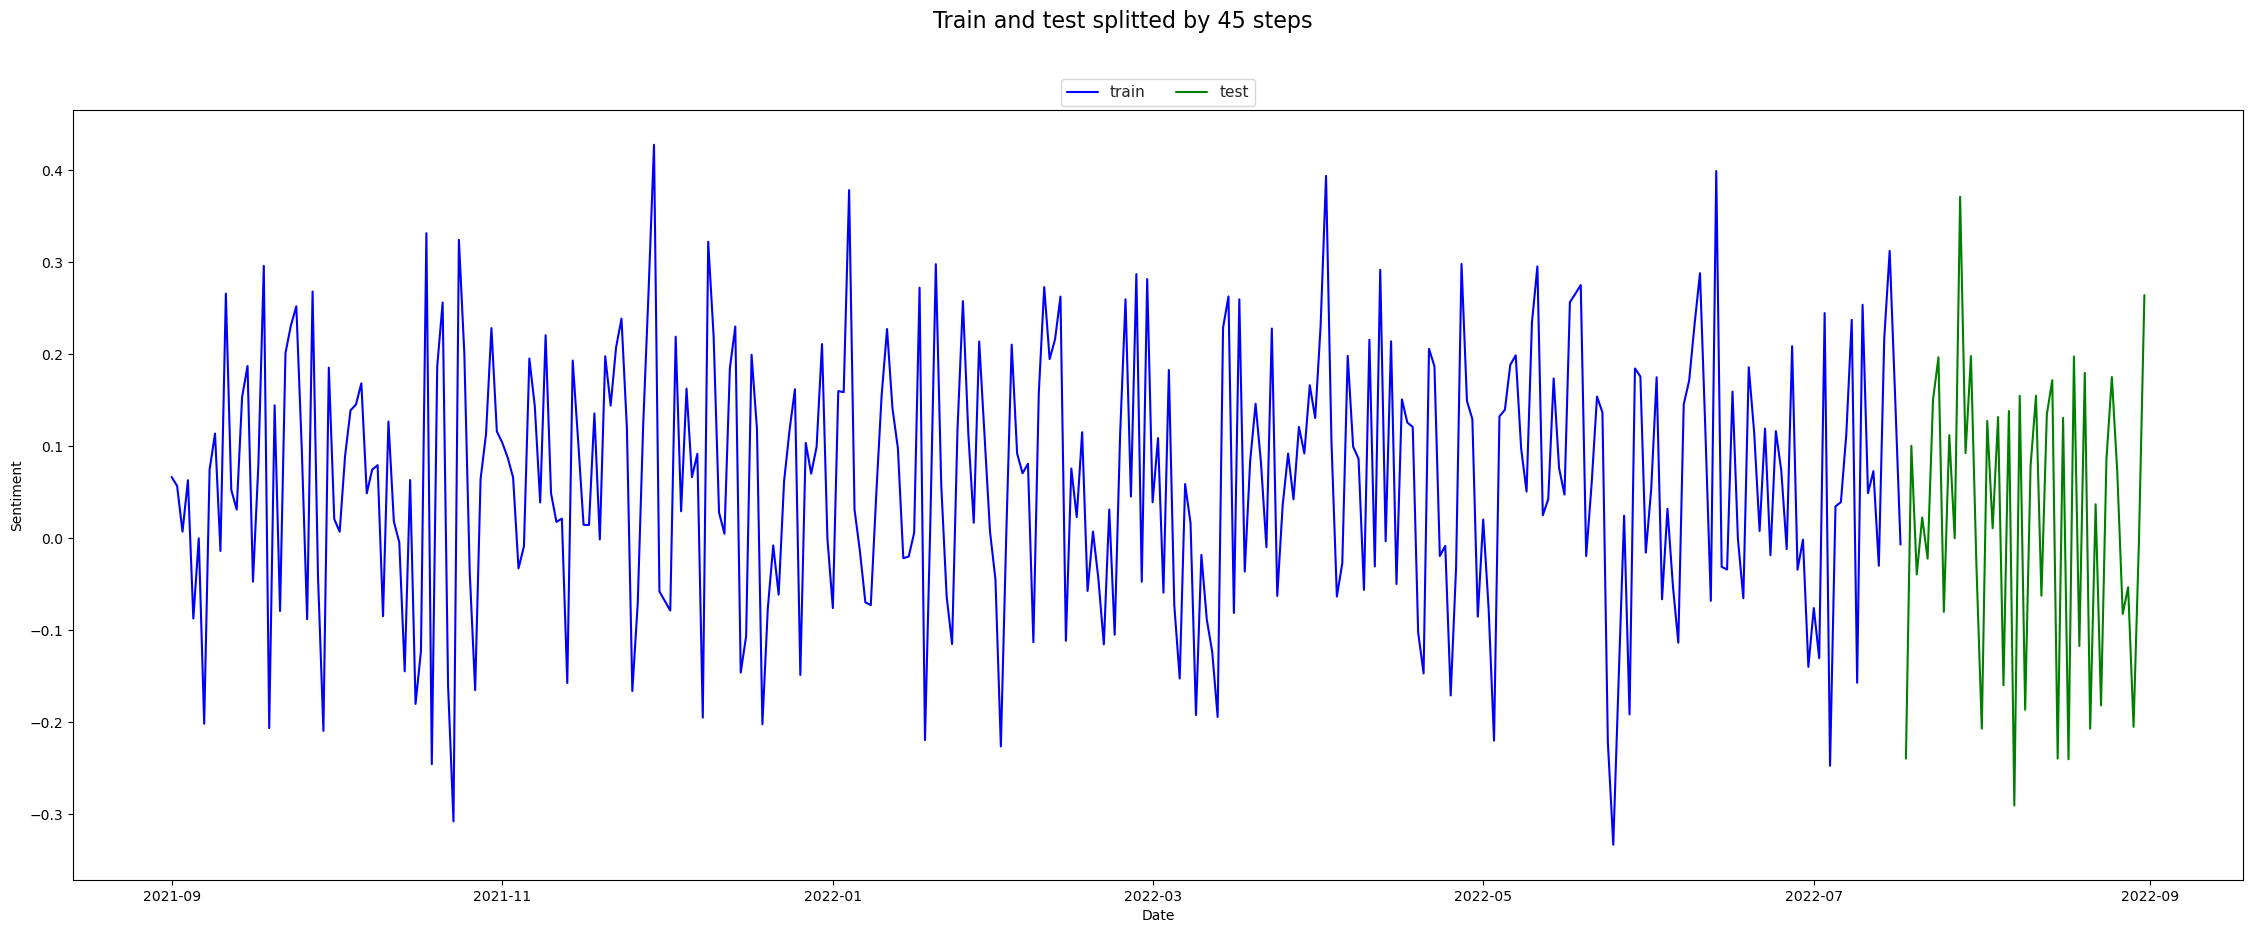

In [12]:
train_test_lineplot("Train and test splitted by 45 steps", data_train, data_test)

In [13]:
# Create and train forecaster
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train["average sentiment"])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-09-01 00:00:00'), Timestamp('2022-07-17 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-05-25 22:06:25 
Last fit date: 2023-05-25 22:06:26 
Skforecast version: 0.8.0 
Python version: 3.10.9 
Forecaster id: None 

In [14]:
# Predictions
steps = 45
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2022-07-18    0.055039
2022-07-19    0.040200
2022-07-20    0.060441
2022-07-21    0.046524
2022-07-22    0.065426
Freq: D, Name: pred, dtype: float64

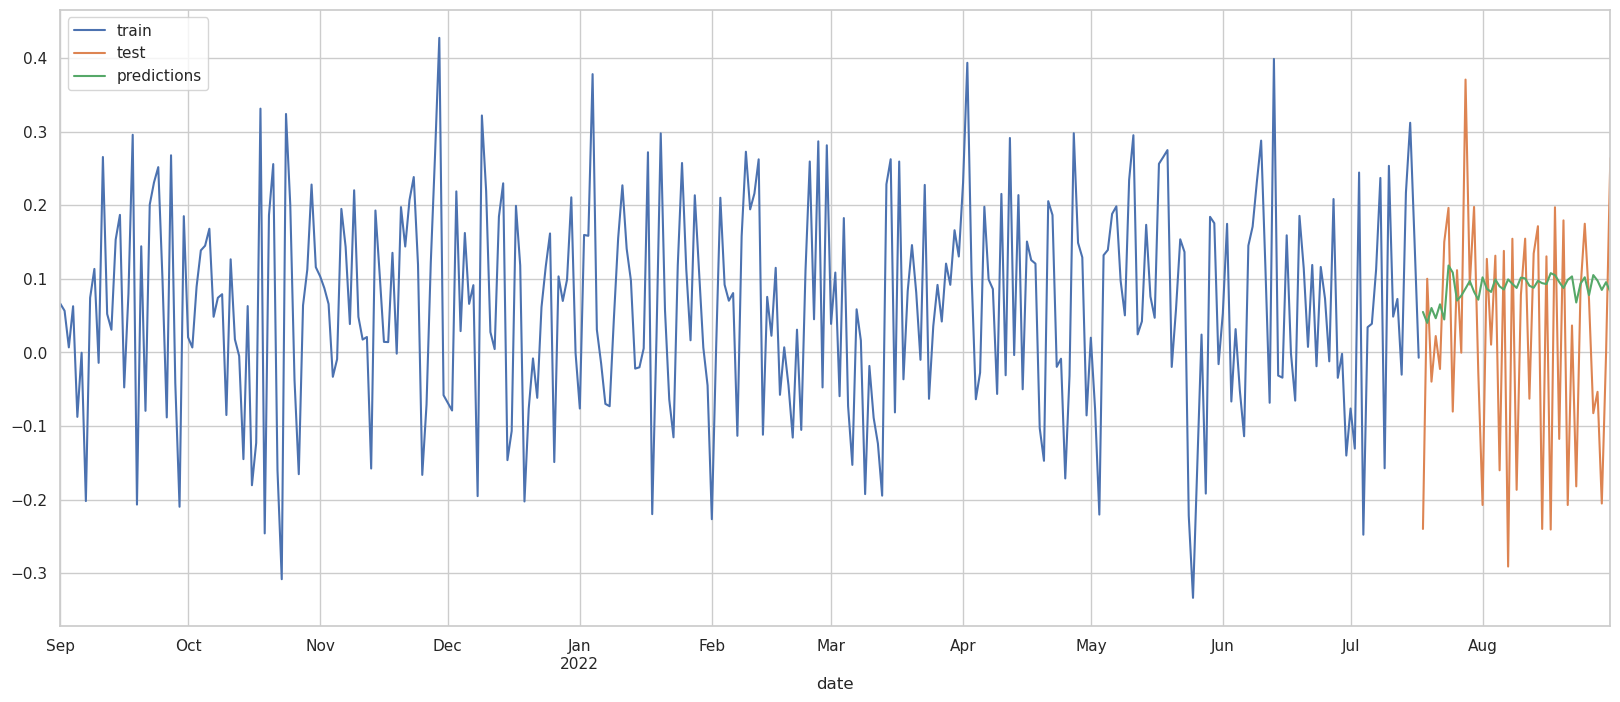

In [15]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 8))
data_train["average sentiment"].plot(ax=ax, label='train')
data_test["average sentiment"].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [16]:
# Test error
error_mse = mean_squared_error(
                y_true = data_test["average sentiment"],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.0301175030203841


In [17]:
# Hyperparameter Grid search
steps = 45
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 40]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train["average sentiment"],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = "mean_squared_error",
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.019934567954501176



In [18]:
# Grid Search results
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.019935,5,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.019946,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.019964,3,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.020014,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.020063,10,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.020088,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.020122,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.020140,10,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.020149,10,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.020182,3,100


<br>

- ***final model***

In [19]:
# Create and train forecaster with the best hyperparameters
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data_train["average sentiment"])

In [20]:
# Predictions
predictions = forecaster.predict(steps=steps)

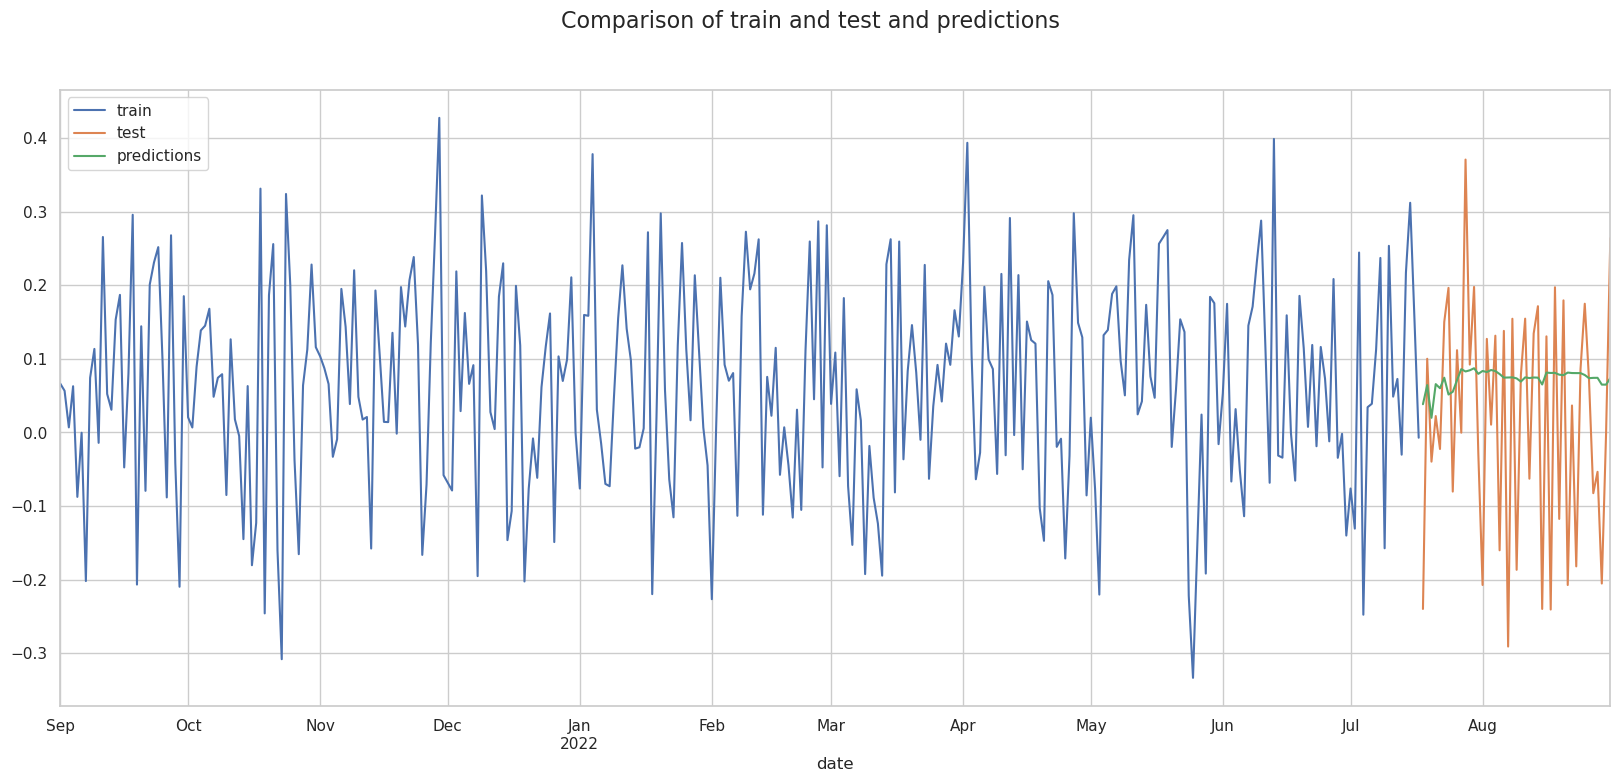

In [21]:
# Plot
fig, ax = plt.subplots(figsize=(20, 8))
fig.suptitle("Comparison of train and test and predictions", fontsize=16)
data_train["average sentiment"].plot(ax=ax, label="train")
data_test["average sentiment"].plot(ax=ax, label="test")
predictions.plot(ax=ax, label="predictions")
ax.legend();

In [22]:
# Test error
error_mse = mean_squared_error(
                y_true = data_test["average sentiment"],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.02739754663703852


*The test error has reduced comparing to the initially random start.*

<br>

- ***backtesting***

In [23]:
steps = 45
n_backtesting = 45*7 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data["average sentiment"],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps      = steps,
                                    metric     = "mean_squared_error",
                                    refit      = True,
                                    verbose    = True
                                    )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 50
Number of observations used for backtesting: 315
    Number of folds: 7
    Number of steps per fold: 45
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2021-09-01 00:00:00 -- 2021-10-20 00:00:00  (n=50)
    Validation: 2021-10-21 00:00:00 -- 2021-12-04 00:00:00  (n=45)
Fold: 1
    Training:   2021-09-01 00:00:00 -- 2021-12-04 00:00:00  (n=95)
    Validation: 2021-12-05 00:00:00 -- 2022-01-18 00:00:00  (n=45)
Fold: 2
    Training:   2021-09-01 00:00:00 -- 2022-01-18 00:00:00  (n=140)
    Validation: 2022-01-19 00:00:00 -- 2022-03-04 00:00:00  (n=45)
Fold: 3
    Training:   2021-09-01 00:00:00 -- 2022-03-04 00:00:00  (n=185)
    Validation: 2022-03-05 00:00:00 -- 2022-04-18 00:00:00  (n=45)
Fold: 4
    Training:   2021-09-01 00:00:00 -- 2022-04-18 00:00:00  (n=230)
    Validation: 2022-04-19 00:00:00 -- 202

  0%|          | 0/7 [00:00<?, ?it/s]

Backtest error: 0.021730112861420833


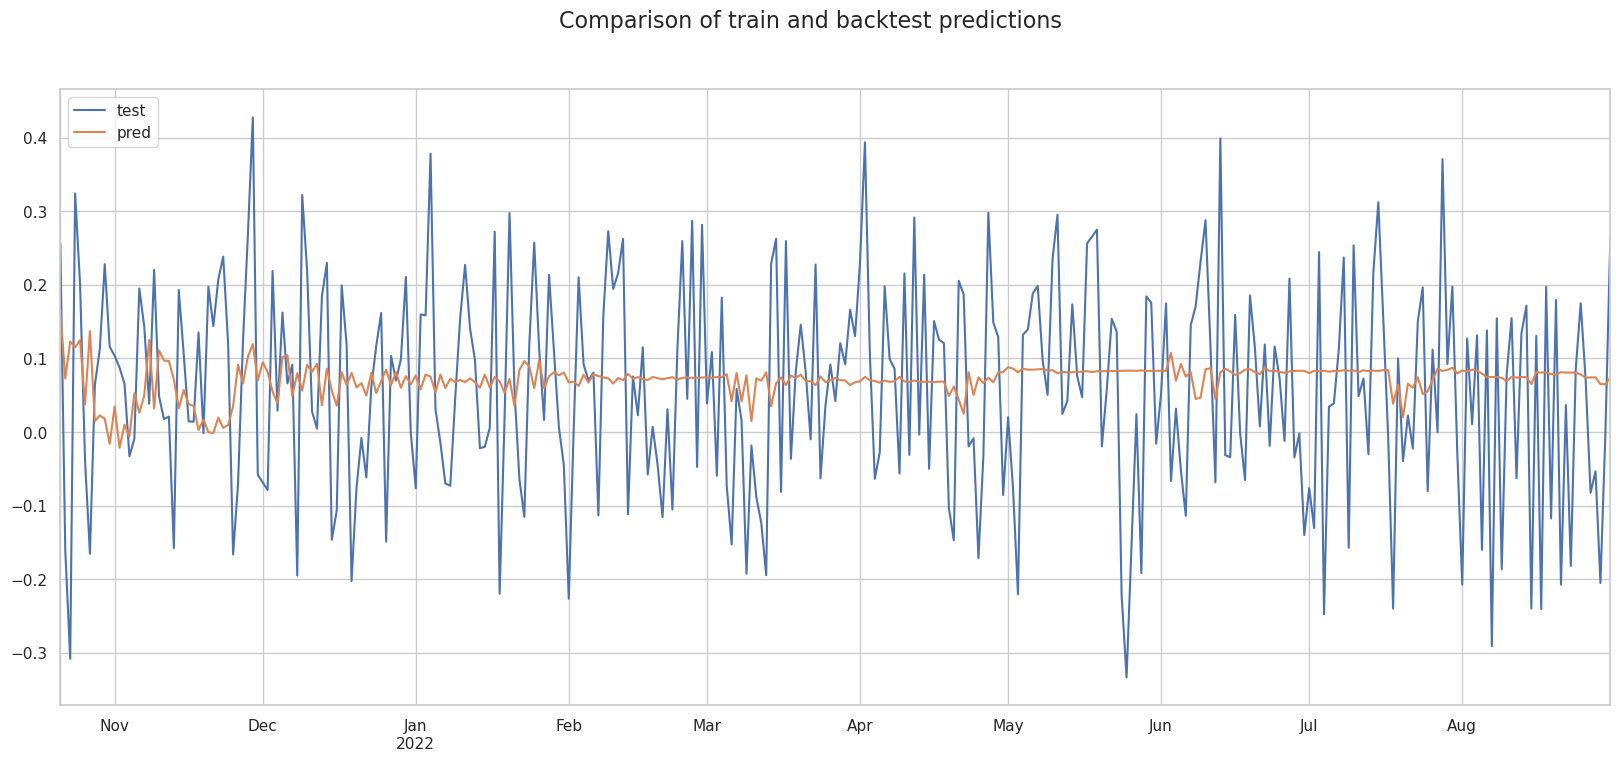

In [24]:
# Plot
fig, ax = plt.subplots(figsize=(20, 8))
fig.suptitle("Comparison of train and backtest predictions", fontsize=16)

data.loc[predictions_backtest.index, "average sentiment"].plot(ax=ax, label="test")
predictions_backtest.plot(ax=ax, label="predictions")
ax.legend(loc="upper left");

<br>

- **Autoregressive Integrated Moving Average**

In [25]:
#!pip3 install statsmodels

In [32]:
df_arima = pd.read_csv("climate_change_sentiment.csv", parse_dates=["date"], index_col="date")
df_arima.head()

,average sentiment
date,
2021-09-01,0.066240
2021-09-02,0.056645
2021-09-03,0.006905
2021-09-04,0.062800
2021-09-05,-0.087550


In [30]:
import datetime
from statsmodels.tsa.arima_model import ARIMA

In [31]:
# Relax the display limits on columns and rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [33]:
# Split into train and test
train = df_arima[df_arima.index < pd.to_datetime("2022-07-01", format='%Y-%m-%d')]
test = df_arima[df_arima.index >= pd.to_datetime("2022-07-01", format='%Y-%m-%d')]
test.head()

,average sentiment
date,
2022-07-01,-0.076160
2022-07-02,-0.130675
2022-07-03,0.244470
2022-07-04,-0.247640
2022-07-05,0.034325


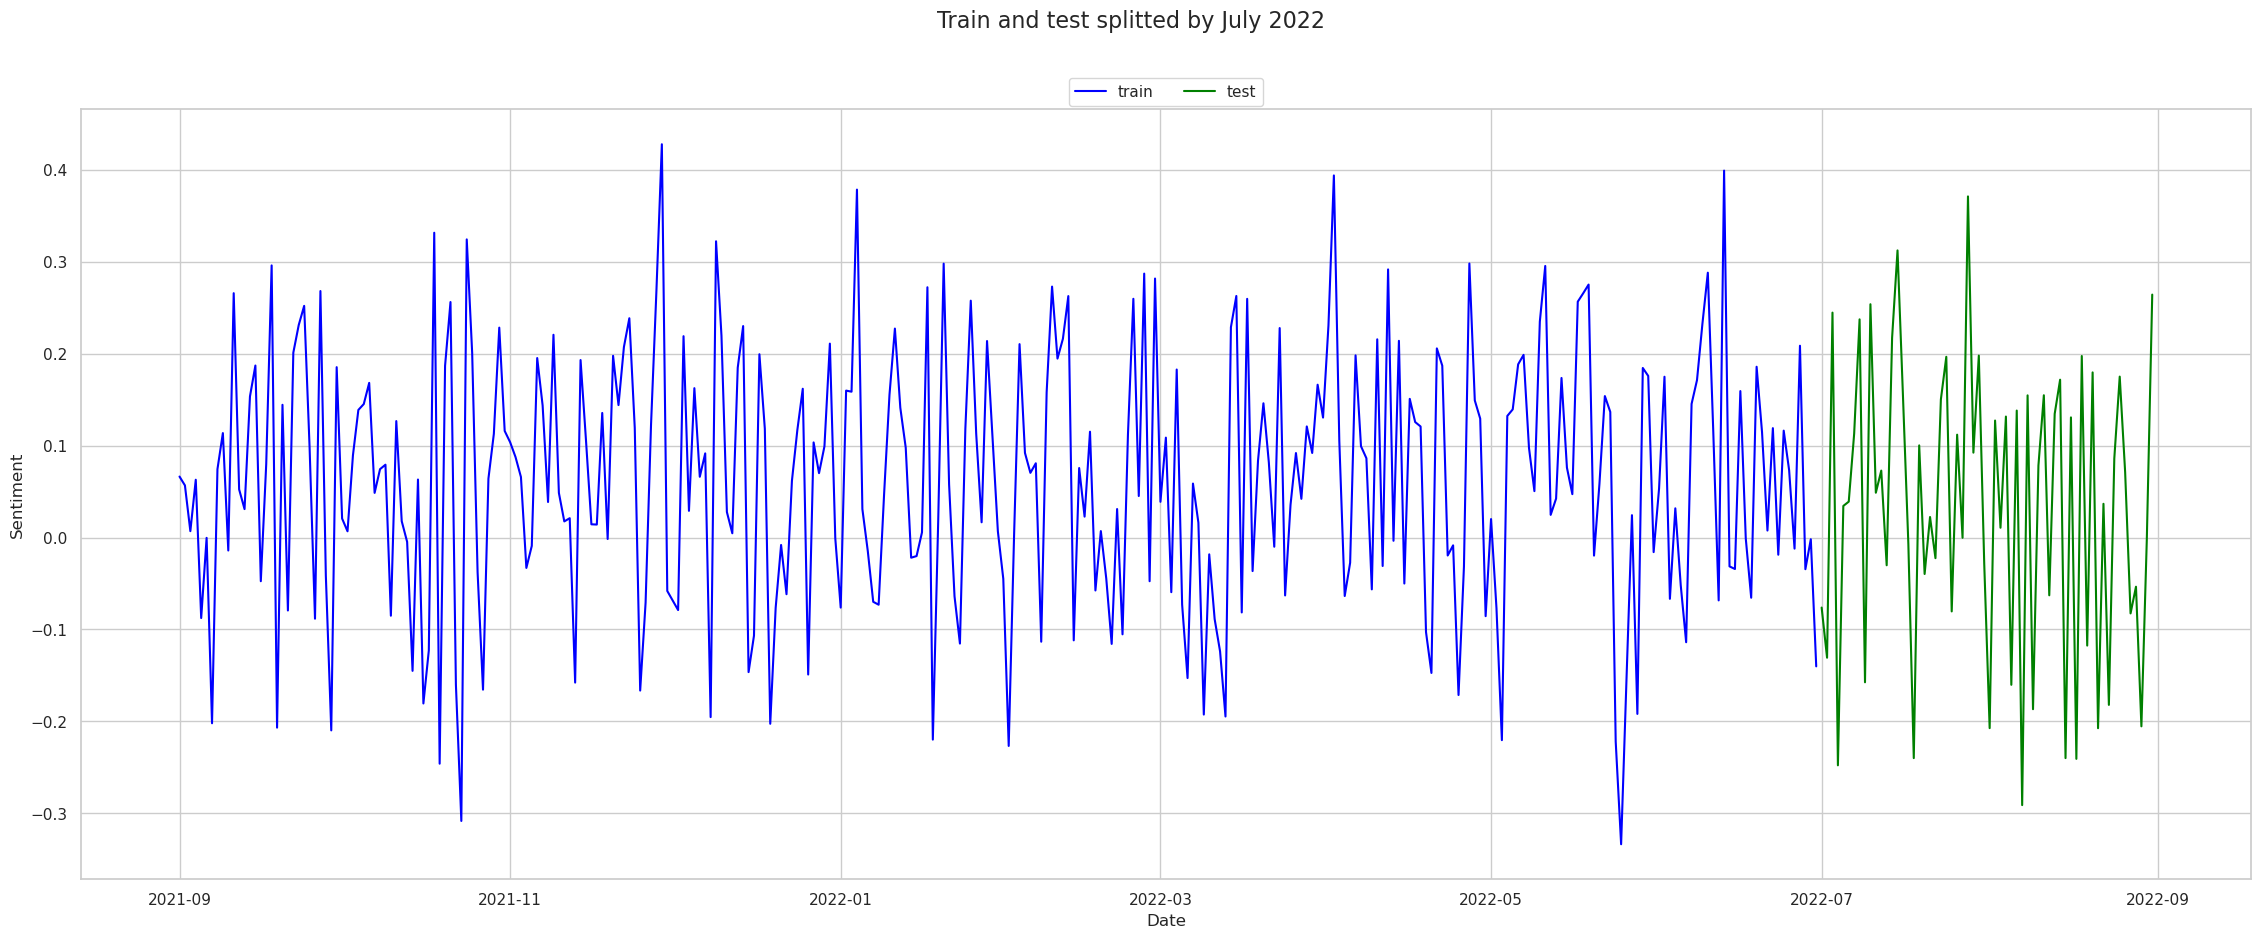

In [34]:
# Visualise train and test
train_test_lineplot("Train and test splitted by July 2022", train, test)

In [35]:
y = train["average sentiment"] # for hypertuning and model fitting

In [36]:
# Apply ARIMA model
ARIMAmodel = SARIMAX(y, order = (2, 0, 20))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARIMA = y_pred_df["Predictions"].rename_axis("date").reset_index(name="prediction")
y_pred_outARIMA.set_index("date", inplace=True)
y_pred_outARIMA.head()

NameError: name 'SARIMAX' is not defined

In [ ]:
# hyper-tuning for ARMA
import itertools
from sklearn.model_selection import ParameterGrid

# Define the range of parameter values to explore
param_grid = {
    'order': [(p, d, q) for p in range(1, 60) for d in range(2) for q in range(20)],
    'seasonal_order': [((P, D, Q, S) if sum((P, D, Q, S)) > 0 else None)
                       for P in range(2) for D in range(2) for Q in range(2) for S in [7]],
}

# Generate all possible combinations of parameters
param_combinations = list(ParameterGrid(param_grid))

# Initialize variables to track best parameters and performance
best_score = float('inf')
best_params = None

# Iterate over all parameter combinations
for params in param_combinations:
    try:
        # Create and fit the SARIMAX model
        model = SARIMAX(y, order=params['order'], seasonal_order=params['seasonal_order'])
        model = model.fit()

        # Make predictions
        y_pred = model.get_forecast(len(test.index))
        y_pred_df = y_pred.conf_int(alpha=0.05)
        y_pred_df['Predictions'] = model.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
        y_pred_df.index = test.index

        # Calculate the performance metric (e.g., mean squared error)
        error = np.mean((y_pred_df['Predictions'] - test['average sentiment']) ** 2)

        # Check if the current parameters yield better performance
        if error < best_score:
            best_score = error
            best_params = params
    except:
        # Ignore any exceptions and continue to the next parameter combination
        continue

# Print the best parameters and their corresponding performance
print("Best Parameters:", best_params)
print("Best Score:", best_score)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.79713D-01    |proj g|=  1.83579D-02

At iterate    5    f= -4.79715D-01    |proj g|=  2.33633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     12      1     0     0   1.149D-06  -4.797D-01
  F = -0.47971460633636198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -4.84424D-01    |proj g|=  7.45508D-03

At iterate   10    f= -4.84455D-01    |proj g|=  2.55471D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   1.293D-04  -4.845D-01
  F = -0.48445535564184933     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88790D-01    |proj g|=  1.67356D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -4.58667D-01    |proj g|=  6.59979D-02

At iterate   10    f= -4.68650D-01    |proj g|=  7.69019D-01

At iterate   15    f= -4.92934D-01    |proj g|=  6.05086D-01

At iterate   20    f= -4.98409D-01    |proj g|=  1.04718D-01

At iterate   25    f= -4.99173D-01    |proj g|=  1.43313D-03

At iterate   30    f= -4.99251D-01    |proj g|=  1.63486D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     47      1     0     0   7.653D-04  -4.993D-01
  F = -0.49925169425017413     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.94353D-01    |proj g|=  2.15579D-01

At iterate    5    f= -5.03117D-01    |proj g|=  2.08204D-02


 This problem is unconstrained.



At iterate   10    f= -5.03272D-01    |proj g|=  1.25391D-01

At iterate   15    f= -5.04747D-01    |proj g|=  1.85496D-01

At iterate   20    f= -5.16397D-01    |proj g|=  1.90339D-02

At iterate   25    f= -5.26393D-01    |proj g|=  4.47721D-02

At iterate   30    f= -5.29212D-01    |proj g|=  8.41934D-02

At iterate   35    f= -5.29798D-01    |proj g|=  5.85963D-02

At iterate   40    f= -5.30088D-01    |proj g|=  4.84170D-03

At iterate   45    f= -5.30136D-01    |proj g|=  4.77721D-03

At iterate   50    f= -5.30158D-01    |proj g|=  2.99840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     61   

 This problem is unconstrained.



At iterate    5    f= -3.23712D-01    |proj g|=  3.18278D-03

At iterate   10    f= -3.23723D-01    |proj g|=  4.66894D-04

At iterate   15    f= -3.23723D-01    |proj g|=  3.09648D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   3.096D-04  -3.237D-01
  F = -0.32372321146896138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.87123D-01    |proj g|=  2.08933D+00

At iterate    5    f= -4.52464D-01    |proj g|=  8.08189D-02

At iterate   10    f= -4.65382D-01    |proj g|=  4.07434D-01

At iterate   15    f= -4.93582D-01    |proj g|=  7.70270D-02

At iterate   20    f= -4.98638D-01    |proj g|=  7.12490D-02

At iterate   25    f= -4.99430D-01    |proj g|=  6.35395D-03

At iterate   30    f= -4.99511D-01    |proj g|=  1.40748D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   30    f= -5.40132D-01    |proj g|=  9.66954D-03

At iterate   35    f= -5.40711D-01    |proj g|=  3.29825D-03

At iterate   40    f= -5.41008D-01    |proj g|=  3.47943D-03

At iterate   45    f= -5.41047D-01    |proj g|=  6.30563D-03

At iterate   50    f= -5.41064D-01    |proj g|=  8.20259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     58      1     0     0   8.203D-04  -5.411D-01
  F = -0.54106436803423807     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f= -4.91339D-01    |proj g|=  1.22636D-01

At iterate   15    f= -5.10787D-01    |proj g|=  1.14669D+00

At iterate   20    f= -5.29326D-01    |proj g|=  1.20271D-02

At iterate   25    f= -5.29927D-01    |proj g|=  8.53756D-03

At iterate   30    f= -5.35635D-01    |proj g|=  3.82024D-02

At iterate   35    f= -5.38921D-01    |proj g|=  5.39730D-03

At iterate   40    f= -5.40684D-01    |proj g|=  4.21356D-02

At iterate   45    f= -5.40986D-01    |proj g|=  4.07774D-02

At iterate   50    f= -5.41107D-01    |proj g|=  6.86280D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     58   

 This problem is unconstrained.



At iterate   15    f= -1.87937D-01    |proj g|=  3.42466D-02

At iterate   20    f= -1.88407D-01    |proj g|=  1.63176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     29      1     0     0   7.826D-06  -1.884D-01
  F = -0.18840900976510483     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.87710D-01    |proj g|=  2.11247D+00


 This problem is unconstrained.



At iterate    5    f= -4.53565D-01    |proj g|=  6.90213D-02

At iterate   10    f= -4.70909D-01    |proj g|=  6.95412D-01

At iterate   15    f= -4.84703D-01    |proj g|=  5.70668D-01

At iterate   20    f= -4.97009D-01    |proj g|=  5.46610D-02

At iterate   25    f= -4.97692D-01    |proj g|=  1.97536D-03

At iterate   30    f= -4.97718D-01    |proj g|=  1.14884D-02

At iterate   35    f= -4.99950D-01    |proj g|=  3.76372D-01

At iterate   40    f= -5.01618D-01    |proj g|=  1.10641D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     59      1     0     0   1.106D-03  -5.016D-01
  F = -0.501618023446

 This problem is unconstrained.



At iterate   25    f= -5.23297D-01    |proj g|=  1.59654D-01

At iterate   30    f= -5.35612D-01    |proj g|=  5.00603D-02

At iterate   35    f= -5.39763D-01    |proj g|=  7.46905D-03

At iterate   40    f= -5.40659D-01    |proj g|=  3.36377D-02

At iterate   45    f= -5.41044D-01    |proj g|=  4.69552D-03

At iterate   50    f= -5.41112D-01    |proj g|=  1.03049D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     56      1     0     0   1.030D-02  -5.411D-01
  F = -0.54111245574348321     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -5.04400D-01    |proj g|=  4.91237D-02

At iterate   15    f= -5.07924D-01    |proj g|=  3.90640D-01

At iterate   20    f= -5.16921D-01    |proj g|=  2.50668D-01

At iterate   25    f= -5.25248D-01    |proj g|=  4.69208D-03

At iterate   30    f= -5.35080D-01    |proj g|=  9.86040D-02

At iterate   35    f= -5.36278D-01    |proj g|=  7.87441D-02
  ys=-5.325E-03  -gs= 9.560E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -5.37604D-01    |proj g|=  2.26365D-03

At iterate   45    f= -5.37818D-01    |proj g|=  1.44611D-01

At iterate   50    f= -5.39497D-01    |proj g|=  7.62861D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     92      2     1     0   7.629D-04  -5.395D-01
  F = -0.53949732267482953     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.02367D-01    |proj g|=  1.19299D+00

At iter

 This problem is unconstrained.



At iterate   10    f= -3.22639D-01    |proj g|=  1.51304D-02

At iterate   15    f= -3.22872D-01    |proj g|=  6.25571D-02

At iterate   20    f= -3.22909D-01    |proj g|=  2.76767D-03

At iterate   25    f= -3.23709D-01    |proj g|=  1.76543D-01

At iterate   30    f= -3.25630D-01    |proj g|=  8.05965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     49      1     0     0   9.563D-06  -3.256D-01
  F = -0.32563064839944361     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f= -4.53606D-01    |proj g|=  1.39353D-01

At iterate   10    f= -4.89068D-01    |proj g|=  6.72786D-02

At iterate   15    f= -4.97585D-01    |proj g|=  5.94616D-03

At iterate   20    f= -4.98959D-01    |proj g|=  6.70256D-03

At iterate   25    f= -5.01982D-01    |proj g|=  3.63225D-02

At iterate   30    f= -5.01991D-01    |proj g|=  7.39004D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     43      1     0     0   7.390D-06  -5.020D-01
  F = -0.50199099477468523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f= -5.24304D-01    |proj g|=  1.54669D-02

At iterate   25    f= -5.25655D-01    |proj g|=  2.23375D-01

At iterate   30    f= -5.35854D-01    |proj g|=  3.12669D-02

At iterate   35    f= -5.37289D-01    |proj g|=  5.94986D-02

At iterate   40    f= -5.41151D-01    |proj g|=  1.64383D-01

At iterate   45    f= -5.42642D-01    |proj g|=  1.73539D-02

At iterate   50    f= -5.42872D-01    |proj g|=  2.66770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     58      1     0     0   2.668D-03  -5.429D-01
  F = -0.54287157551366594     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f= -5.21651D-01    |proj g|=  4.78926D-02

At iterate   20    f= -5.24320D-01    |proj g|=  5.79901D-03

At iterate   25    f= -5.24433D-01    |proj g|=  3.08789D-02

At iterate   30    f= -5.28106D-01    |proj g|=  1.35027D-01

At iterate   35    f= -5.32687D-01    |proj g|=  1.09625D-02

At iterate   40    f= -5.37769D-01    |proj g|=  5.72256D-02

At iterate   45    f= -5.41153D-01    |proj g|=  5.15315D-02

At iterate   50    f= -5.42646D-01    |proj g|=  3.69952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   3.700D-03  -5.426D-01
  F = -0.542646332978

 This problem is unconstrained.



At iterate   10    f= -1.89545D-01    |proj g|=  1.07105D-02

At iterate   15    f= -1.90056D-01    |proj g|=  1.42829D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     46      2     0     0   2.712D-05  -1.901D-01
  F = -0.19005764338984044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.91345D-01    |proj g|=  2.15821D+00

At iterate    5    f= -4.60784D-01    |proj g|=  6.64354D-02

At iterate   10    f= -4.70359D-01    |proj g|=  6.43913D-01

At iterate   15    f= -4.98475D-01    |proj g|=  2.02900D-01

At iter

 This problem is unconstrained.



At iterate    5    f= -5.19602D-01    |proj g|=  7.30544D-02

At iterate   10    f= -5.23817D-01    |proj g|=  2.49405D-01

At iterate   15    f= -5.24339D-01    |proj g|=  1.87338D-02

At iterate   20    f= -5.26685D-01    |proj g|=  2.34189D-01

At iterate   25    f= -5.34791D-01    |proj g|=  5.65632D-02

At iterate   30    f= -5.39931D-01    |proj g|=  1.44049D-02

At iterate   35    f= -5.41904D-01    |proj g|=  6.68469D-02

At iterate   40    f= -5.42778D-01    |proj g|=  1.65849D-02

At iterate   45    f= -5.42968D-01    |proj g|=  6.90229D-03

At iterate   50    f= -5.43031D-01    |proj g|=  3.61508D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.21876D-01    |proj g|=  2.61905D-01

At iterate   10    f= -5.22875D-01    |proj g|=  1.88785D-01

At iterate   15    f= -5.24010D-01    |proj g|=  1.20953D-01

At iterate   20    f= -5.25311D-01    |proj g|=  4.89397D-02

At iterate   25    f= -5.25359D-01    |proj g|=  8.63900D-03

At iterate   30    f= -5.25575D-01    |proj g|=  1.09897D-01

At iterate   35    f= -5.33925D-01    |proj g|=  8.92770D-02

At iterate   40    f= -5.40442D-01    |proj g|=  8.42336D-02

At iterate   45    f= -5.41606D-01    |proj g|=  1.03103D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     67   

 This problem is unconstrained.



At iterate    5    f= -3.25716D-01    |proj g|=  4.50536D-03

At iterate   10    f= -3.25759D-01    |proj g|=  1.75082D-02

At iterate   15    f= -3.26245D-01    |proj g|=  9.67657D-02

At iterate   20    f= -3.26701D-01    |proj g|=  8.79043D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   9.375D-05  -3.267D-01
  F = -0.32670062663301103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.87582D-01    |proj g|=  2.10897D+00

At iterate    5    f= -4.57993D-01    |proj g|=  1.81320D-01

At iterate   10    f= -4.96396D-01    |proj g|=  2.10369D-01

At iterate   15    f= -5.02395D-01    |proj g|=  6.24683D-02

At iterate   20    f= -5.03803D-01    |proj g|=  7.08915D-03

At iterate   25    f= -5.03874D-01    |proj g|=  5.02388D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     32      1     0     0   

 This problem is unconstrained.



At iterate   20    f= -5.20552D-01    |proj g|=  2.07093D-01

At iterate   25    f= -5.35629D-01    |proj g|=  8.01170D-02

At iterate   30    f= -5.40679D-01    |proj g|=  9.01650D-02

At iterate   35    f= -5.44437D-01    |proj g|=  2.07910D-01

At iterate   40    f= -5.45627D-01    |proj g|=  3.08289D-02

At iterate   45    f= -5.46036D-01    |proj g|=  8.52779D-02

At iterate   50    f= -5.46414D-01    |proj g|=  1.19936D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   1.199D-02  -5.464D-01
  F = -0.54641416397078968     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f= -5.09548D-01    |proj g|=  3.75647D-02

At iterate   10    f= -5.10306D-01    |proj g|=  7.34235D-02

At iterate   15    f= -5.19034D-01    |proj g|=  7.68484D-01

At iterate   20    f= -5.42076D-01    |proj g|=  1.49998D-01

At iterate   25    f= -5.43047D-01    |proj g|=  1.30090D-03

At iterate   30    f= -5.43072D-01    |proj g|=  1.62539D-02

At iterate   35    f= -5.44167D-01    |proj g|=  4.48832D-02

At iterate   40    f= -5.45969D-01    |proj g|=  1.51864D-02

At iterate   45    f= -5.46548D-01    |proj g|=  2.04702D-03

At iterate   50    f= -5.46643D-01    |proj g|=  4.77125D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.90384D-01    |proj g|=  6.06829D-03

At iterate   10    f= -1.90388D-01    |proj g|=  4.19436D-03

At iterate   15    f= -1.90493D-01    |proj g|=  6.24664D-02

At iterate   20    f= -1.90685D-01    |proj g|=  1.74965D-02

At iterate   25    f= -1.90703D-01    |proj g|=  2.85138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   2.154D-04  -1.907D-01
  F = -0.19070257826501899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -4.61764D-01    |proj g|=  5.04341D-01

At iterate   10    f= -4.68108D-01    |proj g|=  3.93465D-01

At iterate   15    f= -4.91251D-01    |proj g|=  4.82868D-01

At iterate   20    f= -4.99167D-01    |proj g|=  3.37322D-01

At iterate   25    f= -5.02958D-01    |proj g|=  5.69597D-02

At iterate   30    f= -5.03256D-01    |proj g|=  1.33235D-02

At iterate   35    f= -5.03329D-01    |proj g|=  4.90586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     56      1     0     0   5.116D-04  -5.033D-01
  F = -0.50332941467889536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f= -5.11864D-01    |proj g|=  2.37801D-01

At iterate   20    f= -5.25392D-01    |proj g|=  1.39611D-01

At iterate   25    f= -5.37353D-01    |proj g|=  8.33280D-02

At iterate   30    f= -5.37958D-01    |proj g|=  9.78044D-03

At iterate   35    f= -5.42025D-01    |proj g|=  8.16077D-02

At iterate   40    f= -5.45240D-01    |proj g|=  6.78330D-02

At iterate   45    f= -5.46370D-01    |proj g|=  2.91380D-02

At iterate   50    f= -5.46484D-01    |proj g|=  2.08245D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   2.082D-02  -5.465D-01
  F = -0.546483768551

 This problem is unconstrained.



At iterate    5    f= -5.14777D-01    |proj g|=  1.62926D-02

At iterate   10    f= -5.14926D-01    |proj g|=  1.02853D-01

At iterate   15    f= -5.15150D-01    |proj g|=  7.93958D-02

At iterate   20    f= -5.16037D-01    |proj g|=  3.50020D-02

At iterate   25    f= -5.18633D-01    |proj g|=  1.68349D-01

At iterate   30    f= -5.23607D-01    |proj g|=  2.19849D-01

At iterate   35    f= -5.39717D-01    |proj g|=  2.84056D-02

At iterate   40    f= -5.41689D-01    |proj g|=  1.92859D-02

At iterate   45    f= -5.42331D-01    |proj g|=  1.08933D-01

At iterate   50    f= -5.42475D-01    |proj g|=  6.69650D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.26530D-01    |proj g|=  2.11377D-01

At iterate   10    f= -3.27079D-01    |proj g|=  4.58972D-02

At iterate   15    f= -3.27109D-01    |proj g|=  8.74574D-03

At iterate   20    f= -3.27125D-01    |proj g|=  2.50195D-02

At iterate   25    f= -3.27270D-01    |proj g|=  1.18547D-02

At iterate   30    f= -3.27621D-01    |proj g|=  1.30820D-02

At iterate   35    f= -3.27678D-01    |proj g|=  4.78336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     47      1     0     0   3.738D-04  -3.277D-01
  F = -0.32767763809449724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -4.60406D-01    |proj g|=  5.95638D-01

At iterate   10    f= -4.71850D-01    |proj g|=  1.94647D-01

At iterate   15    f= -5.00486D-01    |proj g|=  8.79990D-02

At iterate   20    f= -5.03459D-01    |proj g|=  1.20681D-02

At iterate   25    f= -5.03801D-01    |proj g|=  2.52369D-02

At iterate   30    f= -5.03877D-01    |proj g|=  5.29957D-03

At iterate   35    f= -5.03882D-01    |proj g|=  4.75732D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     51      1     0     0   4.714D-04  -5.039D-01
  F = -0.50388223282183719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.07400D-01    |proj g|=  1.00689D-01

At iterate   10    f= -5.07943D-01    |proj g|=  1.05344D-01

At iterate   15    f= -5.09922D-01    |proj g|=  1.69381D-01

At iterate   20    f= -5.21904D-01    |proj g|=  7.49086D-02

At iterate   25    f= -5.38204D-01    |proj g|=  2.60954D-02

At iterate   30    f= -5.42197D-01    |proj g|=  2.11093D-01

At iterate   35    f= -5.45378D-01    |proj g|=  2.76458D-02

At iterate   40    f= -5.46236D-01    |proj g|=  6.58687D-03

At iterate   45    f= -5.46311D-01    |proj g|=  1.15126D-03

At iterate   50    f= -5.46463D-01    |proj g|=  7.35498D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.06740D-01    |proj g|=  1.54929D-01

At iterate    5    f= -5.07522D-01    |proj g|=  1.18830D-01

At iterate   10    f= -5.07788D-01    |proj g|=  5.69903D-02

At iterate   15    f= -5.08455D-01    |proj g|=  9.16283D-02

At iterate   20    f= -5.10681D-01    |proj g|=  3.91333D-01

At iterate   25    f= -5.28298D-01    |proj g|=  6.38667D-02

At iterate   30    f= -5.38949D-01    |proj g|=  1.66689D-02

At iterate   35    f= -5.39032D-01    |proj g|=  1.64679D-02

At iterate   40    f= -5.42351D-01    |proj g|=  9.45157D-02

At iterate   45    f= -5.45035D-01    |proj g|=  8.87762D-03

At iterate   50    f= -5.45545D-01    |proj g|=  1.72183D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.02426D-01    |proj g|=  2.27552D-01

At iterate   10    f= -2.19259D-01    |proj g|=  6.14236D-02

At iterate   15    f= -2.25138D-01    |proj g|=  2.33122D-01

At iterate   20    f= -2.30567D-01    |proj g|=  1.56367D-01

At iterate   25    f= -2.40563D-01    |proj g|=  1.11490D-01

At iterate   30    f= -2.48695D-01    |proj g|=  4.16627D-01

At iterate   35    f= -2.64362D-01    |proj g|=  1.15411D-01

At iterate   40    f= -2.77451D-01    |proj g|=  1.84493D-01

At iterate   45    f= -2.80247D-01    |proj g|=  7.96897D-03

At iterate   50    f= -2.81409D-01    |proj g|=  1.32152D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.63096D-01    |proj g|=  6.48185D-02

At iterate   10    f= -4.71042D-01    |proj g|=  4.11106D-01

At iterate   15    f= -4.95379D-01    |proj g|=  2.48616D-01

At iterate   20    f= -5.03093D-01    |proj g|=  3.73884D-02

At iterate   25    f= -5.04278D-01    |proj g|=  1.38324D-02

At iterate   30    f= -5.05882D-01    |proj g|=  3.99580D-02

At iterate   35    f= -5.06134D-01    |proj g|=  1.67653D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     43      1     0     0   6.068D-05  -5.061D-01
  F = -0.50613420237194928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   25    f= -5.40542D-01    |proj g|=  4.28947D-03

At iterate   30    f= -5.40603D-01    |proj g|=  3.31775D-02

At iterate   35    f= -5.42593D-01    |proj g|=  1.83878D-02

At iterate   40    f= -5.45027D-01    |proj g|=  1.56565D-02

At iterate   45    f= -5.46392D-01    |proj g|=  1.73909D-02

At iterate   50    f= -5.46540D-01    |proj g|=  1.63841D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.638D-02  -5.465D-01
  F = -0.54653968890313254     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.13531D-01    |proj g|=  1.48541D-01

At iterate   10    f= -5.13908D-01    |proj g|=  7.47719D-02

At iterate   15    f= -5.14150D-01    |proj g|=  8.51092D-02

At iterate   20    f= -5.15022D-01    |proj g|=  8.58102D-02

At iterate   25    f= -5.17070D-01    |proj g|=  5.74408D-02

At iterate   30    f= -5.21349D-01    |proj g|=  2.33314D-01

At iterate   35    f= -5.30441D-01    |proj g|=  1.37926D-01

At iterate   40    f= -5.42443D-01    |proj g|=  5.02270D-02

At iterate   45    f= -5.43315D-01    |proj g|=  1.71988D-02

At iterate   50    f= -5.44129D-01    |proj g|=  4.40940D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -3.30832D-01    |proj g|=  2.54966D-02

At iterate   15    f= -3.31028D-01    |proj g|=  1.88099D-02

At iterate   20    f= -3.39921D-01    |proj g|=  4.88813D-01

At iterate   25    f= -3.49541D-01    |proj g|=  2.05865D-02

At iterate   30    f= -3.53611D-01    |proj g|=  3.93161D-02

At iterate   35    f= -3.53944D-01    |proj g|=  1.71775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     43      1     0     0   4.573D-05  -3.539D-01
  F = -0.35394358645702678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -4.60635D-01    |proj g|=  1.65736D-01

At iterate   10    f= -4.95697D-01    |proj g|=  1.54931D-01

At iterate   15    f= -5.03268D-01    |proj g|=  1.43345D-01

At iterate   20    f= -5.04704D-01    |proj g|=  1.45366D-02

At iterate   25    f= -5.06176D-01    |proj g|=  1.32055D-02

At iterate   30    f= -5.06191D-01    |proj g|=  4.42769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     42      1     0     0   9.764D-05  -5.062D-01
  F = -0.50619100358520863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -5.10604D-01    |proj g|=  2.55774D-01

At iterate   15    f= -5.19098D-01    |proj g|=  2.12706D-02

At iterate   20    f= -5.19368D-01    |proj g|=  6.99656D-02

At iterate   25    f= -5.24676D-01    |proj g|=  6.88818D-01

At iterate   30    f= -5.36404D-01    |proj g|=  1.92893D-02

At iterate   35    f= -5.37462D-01    |proj g|=  1.91566D-02

At iterate   40    f= -5.43024D-01    |proj g|=  1.13983D-02

At iterate   45    f= -5.45630D-01    |proj g|=  3.13036D-02

At iterate   50    f= -5.46121D-01    |proj g|=  9.38261D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.58910D-01    |proj g|=  6.33207D-01

At iterate    5    f= -5.02534D-01    |proj g|=  6.41104D-02

At iterate   10    f= -5.09845D-01    |proj g|=  2.58447D-01

At iterate   15    f= -5.17248D-01    |proj g|=  1.98078D-01

At iterate   20    f= -5.19120D-01    |proj g|=  2.73825D-02

At iterate   25    f= -5.19289D-01    |proj g|=  3.90036D-02

At iterate   30    f= -5.21830D-01    |proj g|=  4.41630D-02

At iterate   35    f= -5.35540D-01    |proj g|=  5.82657D-02

At iterate   40    f= -5.43127D-01    |proj g|=  9.60228D-02

At iterate   45    f= -5.43760D-01    |proj g|=  6.87570D-03

At iterate   50    f= -5.43940D-01    |proj g|=  3.07991D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f= -2.38595D-01    |proj g|=  2.74645D-02

At iterate   15    f= -2.49494D-01    |proj g|=  2.27118D-01

At iterate   20    f= -2.65190D-01    |proj g|=  5.86877D-02

At iterate   25    f= -2.72455D-01    |proj g|=  1.96004D-01

At iterate   30    f= -2.76455D-01    |proj g|=  5.54874D-02

At iterate   35    f= -2.77440D-01    |proj g|=  1.66366D-02

At iterate   40    f= -2.77603D-01    |proj g|=  1.29403D-02

At iterate   45    f= -2.78316D-01    |proj g|=  9.59285D-02

At iterate   50    f= -2.89857D-01    |proj g|=  1.46441D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.92674D-01    |proj g|=  2.19752D+00

At iterate    5    f= -4.65978D-01    |proj g|=  6.45023D-02

At iterate   10    f= -4.78458D-01    |proj g|=  3.29313D-01

At iterate   15    f= -4.96318D-01    |proj g|=  6.98182D-02

At iterate   20    f= -5.06071D-01    |proj g|=  4.97182D-02

At iterate   25    f= -5.07976D-01    |proj g|=  1.54132D-02

At iterate   30    f= -5.08254D-01    |proj g|=  7.84510D-04

At iterate   35    f= -5.08255D-01    |proj g|=  5.48779D-04

At iterate   40    f= -5.08256D-01    |proj g|=  9.30670D-04

At iterate   45    f= -5.08259D-01    |proj g|=  2.78876D-04

At iterate   50    f= -5.08263D-01    |proj g|=  1.15817D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f= -5.09533D-01    |proj g|=  2.48957D-01

At iterate   15    f= -5.13579D-01    |proj g|=  3.20275D-01

At iterate   20    f= -5.18848D-01    |proj g|=  1.28767D-02

At iterate   25    f= -5.19347D-01    |proj g|=  1.75477D-02

At iterate   30    f= -5.23798D-01    |proj g|=  2.28953D-01

At iterate   35    f= -5.39730D-01    |proj g|=  5.40991D-02

At iterate   40    f= -5.40040D-01    |proj g|=  2.31720D-02

At iterate   45    f= -5.40608D-01    |proj g|=  6.37745D-02

At iterate   50    f= -5.42127D-01    |proj g|=  3.50332D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.78614D-01    |proj g|=  3.62323D-01

At iterate    5    f= -5.13391D-01    |proj g|=  2.56507D-02

At iterate   10    f= -5.19252D-01    |proj g|=  8.93468D-02

At iterate   15    f= -5.21602D-01    |proj g|=  1.39953D-02

At iterate   20    f= -5.22002D-01    |proj g|=  9.70707D-03

At iterate   25    f= -5.32463D-01    |proj g|=  3.40147D-01

At iterate   30    f= -5.43151D-01    |proj g|=  1.41368D-02

At iterate   35    f= -5.44829D-01    |proj g|=  1.43214D-02

At iterate   40    f= -5.47124D-01    |proj g|=  2.84923D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   10    f= -3.33853D-01    |proj g|=  9.14093D-03

At iterate   15    f= -3.34013D-01    |proj g|=  1.49350D-02

At iterate   20    f= -3.37178D-01    |proj g|=  2.02248D-01

At iterate   25    f= -3.48981D-01    |proj g|=  1.93477D-01

At iterate   30    f= -3.59248D-01    |proj g|=  6.30195D-02

At iterate   35    f= -3.60007D-01    |proj g|=  6.27374D-03

At iterate   40    f= -3.60023D-01    |proj g|=  6.62253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     53      1     0     0   1.245D-05  -3.600D-01
  F = -0.36002339785234816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -4.63642D-01    |proj g|=  7.18003D-02

At iterate   10    f= -4.97507D-01    |proj g|=  2.08591D-01

At iterate   15    f= -5.05995D-01    |proj g|=  1.65695D-01

At iterate   20    f= -5.08069D-01    |proj g|=  2.22829D-02

At iterate   25    f= -5.08288D-01    |proj g|=  1.19967D-03

At iterate   30    f= -5.08288D-01    |proj g|=  1.57433D-03

At iterate   35    f= -5.08289D-01    |proj g|=  4.03606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     44      1     0     0   3.203D-03  -5.083D-01
  F = -0.50828851565036004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.17462D-01    |proj g|=  6.17008D-03

At iterate   10    f= -5.24267D-01    |proj g|=  5.59369D-02

At iterate   15    f= -5.41245D-01    |proj g|=  3.56977D-02

At iterate   20    f= -5.42284D-01    |proj g|=  5.19160D-03

At iterate   25    f= -5.43359D-01    |proj g|=  9.68270D-02

At iterate   30    f= -5.47398D-01    |proj g|=  7.20794D-02

At iterate   35    f= -5.49150D-01    |proj g|=  6.32203D-02

At iterate   40    f= -5.49606D-01    |proj g|=  8.44291D-03

At iterate   45    f= -5.49927D-01    |proj g|=  2.55862D-02

At iterate   50    f= -5.50008D-01    |proj g|=  1.56725D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.17040D-01    |proj g|=  1.03030D-02

At iterate   10    f= -5.17920D-01    |proj g|=  1.57440D-02

At iterate   15    f= -5.20627D-01    |proj g|=  6.31052D-02

At iterate   20    f= -5.34809D-01    |proj g|=  1.50598D-01

At iterate   25    f= -5.41558D-01    |proj g|=  1.62832D-02

At iterate   30    f= -5.41892D-01    |proj g|=  1.15247D-02

At iterate   35    f= -5.43989D-01    |proj g|=  1.20924D-01

At iterate   40    f= -5.47917D-01    |proj g|=  6.40183D-02

At iterate   45    f= -5.49379D-01    |proj g|=  5.77501D-03

At iterate   50    f= -5.49563D-01    |proj g|=  1.44853D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f= -2.39034D-01    |proj g|=  3.25541D-01

At iterate   20    f= -2.74434D-01    |proj g|=  1.37707D-01

At iterate   25    f= -2.76555D-01    |proj g|=  5.93995D-02

At iterate   30    f= -2.82354D-01    |proj g|=  6.64911D-02

At iterate   35    f= -2.82808D-01    |proj g|=  1.48859D-02

At iterate   40    f= -2.82864D-01    |proj g|=  1.97879D-03

At iterate   45    f= -2.82868D-01    |proj g|=  1.01254D-02

At iterate   50    f= -2.83091D-01    |proj g|=  2.35991D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   2.360D-02  -2.831D-01
  F = -0.283091110152

 This problem is unconstrained.



At iterate    5    f= -4.67271D-01    |proj g|=  6.38941D-02

At iterate   10    f= -4.83814D-01    |proj g|=  4.93406D-02

At iterate   15    f= -5.04113D-01    |proj g|=  1.01059D-01

At iterate   20    f= -5.07214D-01    |proj g|=  2.95525D-02

At iterate   25    f= -5.08320D-01    |proj g|=  8.70491D-03

At iterate   30    f= -5.08382D-01    |proj g|=  3.97766D-03

At iterate   35    f= -5.08393D-01    |proj g|=  4.28295D-03

At iterate   40    f= -5.08394D-01    |proj g|=  1.34220D-03

At iterate   45    f= -5.08402D-01    |proj g|=  2.70520D-03

At iterate   50    f= -5.08426D-01    |proj g|=  8.43078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.16714D-01    |proj g|=  2.04344D-02

At iterate   15    f= -5.17048D-01    |proj g|=  6.88390D-02

At iterate   20    f= -5.17745D-01    |proj g|=  1.36040D-02

At iterate   25    f= -5.18048D-01    |proj g|=  8.97589D-02

At iterate   30    f= -5.22088D-01    |proj g|=  1.03499D-01

At iterate   35    f= -5.38570D-01    |proj g|=  4.49495D-02

At iterate   40    f= -5.39666D-01    |proj g|=  4.48114D-03

At iterate   45    f= -5.42671D-01    |proj g|=  4.34717D-02

At iterate   50    f= -5.46865D-01    |proj g|=  1.46950D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59   

 This problem is unconstrained.



At iterate    5    f= -5.20554D-01    |proj g|=  6.94002D-03

At iterate   10    f= -5.24600D-01    |proj g|=  1.31816D-02

At iterate   15    f= -5.41074D-01    |proj g|=  2.98361D-02

At iterate   20    f= -5.41837D-01    |proj g|=  1.10835D-02

At iterate   25    f= -5.45385D-01    |proj g|=  4.28932D-02
  ys=-4.974E-02  -gs= 4.278E-03 BFGS update SKIPPED
  ys=-2.832E-16  -gs= 7.006E-17 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -5.46641D-01    |proj g|=  4.20371D-02

At iterate   35    f= -5.48262D-01    |proj g|=  1.11758D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -5.48268D-01    |proj g|=  1.45310D-02
  ys=-2.177E-09  -gs= 6.168E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     41    155      4     3     0   1.453D-02  -5.483D-01
  F = -0.54826828905373837     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12241D-01    |proj g|=  1.31029D+00


 This problem is unconstrained.



At iterate    5    f= -3.35061D-01    |proj g|=  1.78234D-01

At iterate   10    f= -3.37689D-01    |proj g|=  5.99273D-02

At iterate   15    f= -3.38440D-01    |proj g|=  8.13323D-02

At iterate   20    f= -3.46715D-01    |proj g|=  2.69686D-01

At iterate   25    f= -3.65053D-01    |proj g|=  1.76493D-01

At iterate   30    f= -3.67990D-01    |proj g|=  1.62508D-02

At iterate   35    f= -3.68324D-01    |proj g|=  1.38502D-03

At iterate   40    f= -3.68325D-01    |proj g|=  6.80002D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     54      1     0     0   1.933D-04  -3.683D-01
  F = -0.368324647127

 This problem is unconstrained.



At iterate    5    f= -4.66112D-01    |proj g|=  1.25322D-01

At iterate   10    f= -5.02653D-01    |proj g|=  1.72022D-01

At iterate   15    f= -5.07352D-01    |proj g|=  1.01901D-01

At iterate   20    f= -5.08493D-01    |proj g|=  2.89473D-02

At iterate   25    f= -5.08681D-01    |proj g|=  4.92482D-03

At iterate   30    f= -5.08697D-01    |proj g|=  6.04862D-04

At iterate   35    f= -5.08698D-01    |proj g|=  4.17569D-04

At iterate   40    f= -5.08699D-01    |proj g|=  3.80269D-03

At iterate   45    f= -5.08703D-01    |proj g|=  3.87815D-03

At iterate   50    f= -5.08706D-01    |proj g|=  1.53840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.24480D-01    |proj g|=  2.95023D-02

At iterate   10    f= -5.25195D-01    |proj g|=  2.95048D-02

At iterate   15    f= -5.25444D-01    |proj g|=  6.55885D-03

At iterate   20    f= -5.28526D-01    |proj g|=  4.89417D-02

At iterate   25    f= -5.43564D-01    |proj g|=  4.67026D-02

At iterate   30    f= -5.44829D-01    |proj g|=  3.63628D-03

At iterate   35    f= -5.44857D-01    |proj g|=  1.51010D-02

At iterate   40    f= -5.44948D-01    |proj g|=  5.28291D-02

At iterate   45    f= -5.45607D-01    |proj g|=  2.35808D-02

At iterate   50    f= -5.46032D-01    |proj g|=  6.31635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.59389D-01    |proj g|=  7.67594D-01

At iterate    5    f= -4.65453D-01    |proj g|=  5.35568D-02

At iterate   10    f= -4.78036D-01    |proj g|=  6.17735D-01

At iterate   15    f= -4.90440D-01    |proj g|=  1.43145D-01

At iterate   20    f= -4.98051D-01    |proj g|=  6.15801D-02

At iterate   25    f= -4.98748D-01    |proj g|=  3.58564D-02

At iterate   30    f= -4.99596D-01    |proj g|=  1.96097D-02

At iterate   35    f= -4.99852D-01    |proj g|=  2.98020D-02

At iterate   40    f= -4.99970D-01    |proj g|=  1.66448D-02

At iterate   45    f= -5.00023D-01    |proj g|=  5.53108D-03

At iterate   50    f= -5.00058D-01    |proj g|=  1.71452D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.24032D-01    |proj g|=  1.10062D-01

At iterate   10    f= -5.24603D-01    |proj g|=  4.27759D-02

At iterate   15    f= -5.24752D-01    |proj g|=  3.71056D-02

At iterate   20    f= -5.25300D-01    |proj g|=  7.41880D-03

At iterate   25    f= -5.26028D-01    |proj g|=  5.33273D-02

At iterate   30    f= -5.30896D-01    |proj g|=  8.38453D-02

At iterate   35    f= -5.45766D-01    |proj g|=  8.59024D-02

At iterate   40    f= -5.46819D-01    |proj g|=  1.15057D-02

At iterate   45    f= -5.46968D-01    |proj g|=  3.78305D-03

At iterate   50    f= -5.47271D-01    |proj g|=  4.54539D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.23860D-01    |proj g|=  4.32943D-01

At iterate   10    f= -4.74110D-01    |proj g|=  3.92737D-02

At iterate   15    f= -4.79882D-01    |proj g|=  2.19676D-01

At iterate   20    f= -4.93455D-01    |proj g|=  1.44780D-01

At iterate   25    f= -4.96852D-01    |proj g|=  9.32135D-02

At iterate   30    f= -4.98830D-01    |proj g|=  1.83705D-02

At iterate   35    f= -4.99716D-01    |proj g|=  3.03477D-02

At iterate   40    f= -4.99912D-01    |proj g|=  3.76276D-02

At iterate   45    f= -5.00169D-01    |proj g|=  1.88618D-02

At iterate   50    f= -5.00243D-01    |proj g|=  2.21023D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.08751D-01    |proj g|=  3.03780D-01

At iterate   10    f= -5.13781D-01    |proj g|=  1.83444D-01

At iterate   15    f= -5.25051D-01    |proj g|=  4.92866D-02

At iterate   20    f= -5.25161D-01    |proj g|=  1.61507D-02

At iterate   25    f= -5.25552D-01    |proj g|=  5.73681D-02

At iterate   30    f= -5.41361D-01    |proj g|=  4.30223D-01

At iterate   35    f= -5.43620D-01    |proj g|=  3.10198D-02

At iterate   40    f= -5.45766D-01    |proj g|=  4.69748D-02

At iterate   45    f= -5.47579D-01    |proj g|=  2.87805D-02

At iterate   50    f= -5.49844D-01    |proj g|=  7.37035D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.67461D-01    |proj g|=  5.14007D-02

At iterate   10    f= -4.96804D-01    |proj g|=  2.24055D-01

At iterate   15    f= -5.00482D-01    |proj g|=  3.65508D-02

At iterate   20    f= -5.00606D-01    |proj g|=  4.11987D-03

At iterate   25    f= -5.00652D-01    |proj g|=  1.24173D-02

At iterate   30    f= -5.01054D-01    |proj g|=  2.36027D-02

At iterate   35    f= -5.01356D-01    |proj g|=  3.21050D-02

At iterate   40    f= -5.01516D-01    |proj g|=  1.79182D-02

At iterate   45    f= -5.01661D-01    |proj g|=  2.02663D-02

At iterate   50    f= -5.01807D-01    |proj g|=  1.39738D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.08614D-01    |proj g|=  8.18324D-01

At iterate   10    f= -5.16808D-01    |proj g|=  1.00340D-01

At iterate   15    f= -5.21750D-01    |proj g|=  1.58295D-01

At iterate   20    f= -5.22690D-01    |proj g|=  1.15508D-01

At iterate   25    f= -5.23168D-01    |proj g|=  2.29057D-02

At iterate   30    f= -5.23737D-01    |proj g|=  1.83421D-02

At iterate   35    f= -5.31557D-01    |proj g|=  6.07840D-02

At iterate   40    f= -5.37867D-01    |proj g|=  4.65738D-02

At iterate   45    f= -5.40313D-01    |proj g|=  5.66347D-02

At iterate   50    f= -5.42722D-01    |proj g|=  6.29197D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.25743D-01    |proj g|=  5.21897D-01

At iterate   10    f= -4.76128D-01    |proj g|=  7.11347D-02

At iterate   15    f= -4.85649D-01    |proj g|=  9.95192D-02

At iterate   20    f= -4.97970D-01    |proj g|=  9.92665D-02

At iterate   25    f= -5.01099D-01    |proj g|=  3.98766D-02

At iterate   30    f= -5.01326D-01    |proj g|=  9.46324D-03

At iterate   35    f= -5.01396D-01    |proj g|=  1.55627D-03

At iterate   40    f= -5.01406D-01    |proj g|=  5.37644D-03

At iterate   45    f= -5.01596D-01    |proj g|=  3.15387D-02

At iterate   50    f= -5.01857D-01    |proj g|=  1.27275D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.21522D-01    |proj g|=  8.04707D-02

At iterate   15    f= -5.24003D-01    |proj g|=  2.09572D-02

At iterate   20    f= -5.24386D-01    |proj g|=  7.09151D-02

At iterate   25    f= -5.32737D-01    |proj g|=  4.42862D-01

At iterate   30    f= -5.42152D-01    |proj g|=  6.34258D-02

At iterate   35    f= -5.44492D-01    |proj g|=  9.72422D-03

At iterate   40    f= -5.46333D-01    |proj g|=  2.54419D-02

At iterate   45    f= -5.50226D-01    |proj g|=  4.36108D-02

At iterate   50    f= -5.52515D-01    |proj g|=  4.78998D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     54   

 This problem is unconstrained.



At iterate    5    f= -4.69138D-01    |proj g|=  1.89218D-01

At iterate   10    f= -4.77755D-01    |proj g|=  1.38906D-01

At iterate   15    f= -4.93308D-01    |proj g|=  1.35901D-01

At iterate   20    f= -4.99972D-01    |proj g|=  1.60906D-01

At iterate   25    f= -5.00888D-01    |proj g|=  1.50044D-02

At iterate   30    f= -5.00972D-01    |proj g|=  8.10365D-03

At iterate   35    f= -5.01003D-01    |proj g|=  1.55124D-03

At iterate   40    f= -5.01013D-01    |proj g|=  4.30980D-03

At iterate   45    f= -5.01103D-01    |proj g|=  4.20812D-02

At iterate   50    f= -5.01485D-01    |proj g|=  2.86459D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.21713D-01    |proj g|=  1.01427D-01

At iterate   10    f= -5.22843D-01    |proj g|=  5.87583D-02

At iterate   15    f= -5.24202D-01    |proj g|=  4.68632D-03

At iterate   20    f= -5.24309D-01    |proj g|=  4.16661D-03

At iterate   25    f= -5.24836D-01    |proj g|=  1.35201D-01

At iterate   30    f= -5.30510D-01    |proj g|=  5.14595D-02

At iterate   35    f= -5.39316D-01    |proj g|=  2.37116D-01

At iterate   40    f= -5.42393D-01    |proj g|=  1.12796D-01

At iterate   45    f= -5.43544D-01    |proj g|=  3.91963D-02

At iterate   50    f= -5.43833D-01    |proj g|=  8.73819D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.23826D-01    |proj g|=  4.15138D-01

At iterate   10    f= -4.76110D-01    |proj g|=  5.82829D-02

At iterate   15    f= -4.83144D-01    |proj g|=  6.59069D-02

At iterate   20    f= -4.97191D-01    |proj g|=  1.46771D-01

At iterate   25    f= -5.00899D-01    |proj g|=  2.83464D-02

At iterate   30    f= -5.01581D-01    |proj g|=  4.00030D-02

At iterate   35    f= -5.01691D-01    |proj g|=  3.60458D-03

At iterate   40    f= -5.01699D-01    |proj g|=  1.45054D-03

At iterate   45    f= -5.01757D-01    |proj g|=  2.74201D-02

At iterate   50    f= -5.01979D-01    |proj g|=  4.60342D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51153D-01    |proj g|=  5.15462D+00

At iterate    5    f= -3.30691D-01    |proj g|=  6.75795D-01

At iterate   10    f= -5.17480D-01    |proj g|=  1.14696D-01

At iterate   15    f= -5.31009D-01    |proj g|=  6.59247D-03

At iterate   20    f= -5.31055D-01    |proj g|=  5.86540D-03

At iterate   25    f= -5.32890D-01    |proj g|=  4.28192D-02

At iterate   30    f= -5.41502D-01    |proj g|=  3.03210D-01

At iterate   35    f= -5.49179D-01    |proj g|=  1.11945D-01

At iterate   40    f= -5.50313D-01    |proj g|=  4.19006D-02

At iterate   45    f= -5.50365D-01    |proj g|=  8.36920D-03

At iterate   50    f= -5.50404D-01    |proj g|=  6.89213D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.51192D-01    |proj g|=  6.49992D-01

At iterate    5    f= -4.68438D-01    |proj g|=  1.04347D-01

At iterate   10    f= -4.79359D-01    |proj g|=  1.17121D-01

At iterate   15    f= -4.98446D-01    |proj g|=  1.37118D-01

At iterate   20    f= -5.01763D-01    |proj g|=  3.11846D-02

At iterate   25    f= -5.03891D-01    |proj g|=  8.68013D-02

At iterate   30    f= -5.04788D-01    |proj g|=  5.82984D-02

At iterate   35    f= -5.05352D-01    |proj g|=  4.50125D-02

At iterate   40    f= -5.05637D-01    |proj g|=  7.93530D-03

At iterate   45    f= -5.05684D-01    |proj g|=  1.48968D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     49     78      1     0     0   1.041D-03  -5.057D-01
  F = -0.50568375041701030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25696D-01    |proj g|=  5.49948D+00

At iterate    5    f= -3.08801D-01    |proj g|=  4.85999D-01

At iterate   10    f= -5.07672D-01    |proj g|=  1.13083D-01

At iterate   15    f= -5.30845D-01    |proj g|=  4.77726D-03

At iter

 This problem is unconstrained.



At iterate    5    f= -4.23824D-01    |proj g|=  2.12840D-01

At iterate   10    f= -4.75619D-01    |proj g|=  5.58725D-02

At iterate   15    f= -4.79875D-01    |proj g|=  9.12533D-02

At iterate   20    f= -4.89617D-01    |proj g|=  1.63789D-01

At iterate   25    f= -4.95776D-01    |proj g|=  1.49769D-01

At iterate   30    f= -5.01606D-01    |proj g|=  6.39713D-02

At iterate   35    f= -5.03832D-01    |proj g|=  1.11500D-01

At iterate   40    f= -5.04354D-01    |proj g|=  2.50911D-02

At iterate   45    f= -5.05213D-01    |proj g|=  3.95745D-02

At iterate   50    f= -5.05517D-01    |proj g|=  2.92895D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.24013D-01    |proj g|=  1.97303D-02

At iterate   10    f= -5.24894D-01    |proj g|=  5.59744D-03

At iterate   15    f= -5.25112D-01    |proj g|=  4.41643D-03

At iterate   20    f= -5.25390D-01    |proj g|=  9.78156D-03

At iterate   25    f= -5.41211D-01    |proj g|=  4.60183D-01

At iterate   30    f= -5.49467D-01    |proj g|=  1.36661D-01

At iterate   35    f= -5.50395D-01    |proj g|=  1.94505D-02

At iterate   40    f= -5.50459D-01    |proj g|=  6.86186D-03

At iterate   45    f= -5.51395D-01    |proj g|=  5.11768D-02

At iterate   50    f= -5.55264D-01    |proj g|=  6.61643D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.32509D-01    |proj g|=  3.18147D-01

At iterate   10    f= -4.78030D-01    |proj g|=  6.68768D-02

At iterate   15    f= -4.98380D-01    |proj g|=  9.71701D-02

At iterate   20    f= -5.01414D-01    |proj g|=  4.80236D-02

At iterate   25    f= -5.02939D-01    |proj g|=  5.36961D-02

At iterate   30    f= -5.03262D-01    |proj g|=  1.07249D-01

At iterate   35    f= -5.03592D-01    |proj g|=  3.37321D-02

At iterate   40    f= -5.03976D-01    |proj g|=  4.90701D-02

At iterate   45    f= -5.04260D-01    |proj g|=  3.18715D-02

At iterate   50    f= -5.04360D-01    |proj g|=  1.88695D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.91806D-01    |proj g|=  3.57721D-01

At iterate    5    f= -5.23972D-01    |proj g|=  2.34549D-02

At iterate   10    f= -5.24878D-01    |proj g|=  5.66811D-03

At iterate   15    f= -5.24981D-01    |proj g|=  2.31153D-02

At iterate   20    f= -5.25050D-01    |proj g|=  1.95131D-02

At iterate   25    f= -5.25134D-01    |proj g|=  7.58283D-03

At iterate   30    f= -5.25248D-01    |proj g|=  8.15651D-03

At iterate   35    f= -5.26299D-01    |proj g|=  1.07633D-01

At iterate   40    f= -5.36683D-01    |proj g|=  3.62049D-01

At iterate   45    f= -5.39992D-01    |proj g|=  7.19306D-02

At iterate   50    f= -5.41722D-01    |proj g|=  2.23087D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.36398D-01    |proj g|=  1.05690D+00

At iterate   10    f= -4.28896D-01    |proj g|=  4.01240D-01

At iterate   15    f= -4.81103D-01    |proj g|=  1.13727D-01

At iterate   20    f= -4.88776D-01    |proj g|=  1.33275D-01

At iterate   25    f= -4.98013D-01    |proj g|=  7.40033D-02

At iterate   30    f= -5.00667D-01    |proj g|=  8.10627D-02

At iterate   35    f= -5.03003D-01    |proj g|=  2.11880D-02

At iterate   40    f= -5.03668D-01    |proj g|=  1.95295D-02

At iterate   45    f= -5.04017D-01    |proj g|=  4.97105D-02

At iterate   50    f= -5.04464D-01    |proj g|=  2.81536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.26318D-01    |proj g|=  1.10159D-02

At iterate   10    f= -5.26642D-01    |proj g|=  3.46939D-03

At iterate   15    f= -5.26684D-01    |proj g|=  1.20595D-03

At iterate   20    f= -5.26721D-01    |proj g|=  3.90852D-03

At iterate   25    f= -5.27754D-01    |proj g|=  1.76808D-01

At iterate   30    f= -5.45061D-01    |proj g|=  2.88826D-02

At iterate   35    f= -5.53330D-01    |proj g|=  5.60099D-02

At iterate   40    f= -5.53632D-01    |proj g|=  1.24926D-03

At iterate   45    f= -5.53666D-01    |proj g|=  1.11140D-02

At iterate   50    f= -5.53972D-01    |proj g|=  6.27560D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.94666D-02    |proj g|=  5.64846D+00

At iterate    5    f= -2.63150D-01    |proj g|=  3.90728D-01

At iterate   10    f= -4.73172D-01    |proj g|=  4.29160D-01

At iterate   15    f= -4.91405D-01    |proj g|=  1.93084D-01

At iterate   20    f= -5.02283D-01    |proj g|=  5.90169D-02

At iterate   25    f= -5.03833D-01    |proj g|=  3.71264D-02

At iterate   30    f= -5.05934D-01    |proj g|=  2.26226D-02

At iterate   35    f= -5.06711D-01    |proj g|=  4.37235D-02

At iterate   40    f= -5.07330D-01    |proj g|=  1.47375D-02

At iterate   45    f= -5.07741D-01    |proj g|=  3.29945D-02

At iterate   50    f= -5.08078D-01    |proj g|=  2.86147D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

 This problem is unconstrained.



At iterate    5    f= -5.26179D-01    |proj g|=  2.24581D-02

At iterate   10    f= -5.26808D-01    |proj g|=  2.68718D-02

At iterate   15    f= -5.26857D-01    |proj g|=  2.60060D-03

At iterate   20    f= -5.26871D-01    |proj g|=  6.73109D-03

At iterate   25    f= -5.26885D-01    |proj g|=  2.61002D-03

At iterate   30    f= -5.26908D-01    |proj g|=  3.97859D-03

At iterate   35    f= -5.26931D-01    |proj g|=  5.60111D-03

At iterate   40    f= -5.27080D-01    |proj g|=  7.01189D-02

At iterate   45    f= -5.28342D-01    |proj g|=  1.76436D-02

At iterate   50    f= -5.31469D-01    |proj g|=  3.06109D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.41583D-01    |proj g|=  1.29292D+00

At iterate   10    f= -3.70528D-01    |proj g|=  6.94900D-01

At iterate   15    f= -4.66180D-01    |proj g|=  3.95449D-01

At iterate   20    f= -4.82616D-01    |proj g|=  1.82929D-01

At iterate   25    f= -4.90308D-01    |proj g|=  1.81451D-01

At iterate   30    f= -4.98991D-01    |proj g|=  6.25401D-02

At iterate   35    f= -5.06365D-01    |proj g|=  1.09335D-01

At iterate   40    f= -5.08187D-01    |proj g|=  2.32595D-02

At iterate   45    f= -5.08524D-01    |proj g|=  3.89253D-02

At iterate   50    f= -5.08926D-01    |proj g|=  2.64058D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.18532D-01    |proj g|=  2.79720D-01

At iterate   10    f= -5.26711D-01    |proj g|=  2.50901D-02

At iterate   15    f= -5.28053D-01    |proj g|=  2.65828D-02

At iterate   20    f= -5.28149D-01    |proj g|=  2.48023D-02

At iterate   25    f= -5.31693D-01    |proj g|=  2.92557D-01

At iterate   30    f= -5.38563D-01    |proj g|=  1.24115D-01

At iterate   35    f= -5.52684D-01    |proj g|=  1.85193D-02

At iterate   40    f= -5.55071D-01    |proj g|=  9.69956D-03

At iterate   45    f= -5.55324D-01    |proj g|=  2.54343D-03

At iterate   50    f= -5.55339D-01    |proj g|=  1.01548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.26146D-02    |proj g|=  5.07845D+00

At iterate    5    f= -3.13547D-01    |proj g|=  5.48879D-01

At iterate   10    f= -4.87815D-01    |proj g|=  1.64947D-01

At iterate   15    f= -5.01553D-01    |proj g|=  1.60838D-01

At iterate   20    f= -5.06481D-01    |proj g|=  4.10424D-02

At iterate   25    f= -5.07896D-01    |proj g|=  2.04590D-02

At iterate   30    f= -5.08480D-01    |proj g|=  2.12029D-02

At iterate   35    f= -5.08957D-01    |proj g|=  2.63463D-02

At iterate   40    f= -5.09250D-01    |proj g|=  4.74306D-02

At iterate   45    f= -5.09366D-01    |proj g|=  1.38456D-02

At iterate   50    f= -5.09464D-01    |proj g|=  1.09329D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.17575D-01    |proj g|=  5.83139D-01

At iterate   10    f= -5.27006D-01    |proj g|=  3.71824D-02

At iterate   15    f= -5.28358D-01    |proj g|=  2.79529D-02

At iterate   20    f= -5.28530D-01    |proj g|=  2.77438D-03

At iterate   25    f= -5.29245D-01    |proj g|=  1.77513D-02

At iterate   30    f= -5.34801D-01    |proj g|=  5.89473D-02

At iterate   35    f= -5.39347D-01    |proj g|=  1.91042D-02

At iterate   40    f= -5.44033D-01    |proj g|=  7.76942D-02

At iterate   45    f= -5.47148D-01    |proj g|=  1.56972D-01

At iterate   50    f= -5.49036D-01    |proj g|=  6.51652D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94206D-01    |proj g|=  2.22184D+00

At iterate    5    f= -3.40449D-01    |proj g|=  1.03528D+00

At iterate   10    f= -4.07475D-01    |proj g|=  5.81031D-01

At iterate   15    f= -4.78758D-01    |proj g|=  1.41415D-01

At iterate   20    f= -4.88118D-01    |proj g|=  9.39022D-02

At iterate   25    f= -5.01953D-01    |proj g|=  5.68733D-02

At iterate   30    f= -5.06863D-01    |proj g|=  1.35007D-01

At iterate   35    f= -5.08096D-01    |proj g|=  1.90579D-02

At iterate   40    f= -5.08891D-01    |proj g|=  4.53443D-02

At iterate   45    f= -5.09223D-01    |proj g|=  2.07946D-02

At iterate   50    f= -5.09416D-01    |proj g|=  9.34116D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f= -5.16412D-01    |proj g|=  8.33643D-02

At iterate   15    f= -5.31550D-01    |proj g|=  4.74788D-03

At iterate   20    f= -5.31693D-01    |proj g|=  6.05452D-02

At iterate   25    f= -5.33427D-01    |proj g|=  1.96303D-01

At iterate   30    f= -5.43873D-01    |proj g|=  4.19701D-02

At iterate   35    f= -5.50096D-01    |proj g|=  2.31012D-01

At iterate   40    f= -5.51141D-01    |proj g|=  1.03723D-02

At iterate   45    f= -5.51226D-01    |proj g|=  6.76081D-03

At iterate   50    f= -5.51384D-01    |proj g|=  1.53520D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     57   

 This problem is unconstrained.



At iterate    5    f= -2.75249D-01    |proj g|=  4.81945D-01

At iterate   10    f= -4.79294D-01    |proj g|=  8.03555D-02

At iterate   15    f= -4.99781D-01    |proj g|=  5.81351D-02

At iterate   20    f= -5.05547D-01    |proj g|=  8.85553D-02

At iterate   25    f= -5.07350D-01    |proj g|=  2.25664D-02

At iterate   30    f= -5.08704D-01    |proj g|=  4.15323D-02

At iterate   35    f= -5.08939D-01    |proj g|=  3.27164D-02

At iterate   40    f= -5.09294D-01    |proj g|=  1.62934D-02

At iterate   45    f= -5.09417D-01    |proj g|=  2.21683D-02

At iterate   50    f= -5.09489D-01    |proj g|=  8.58887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12380D-01    |proj g|=  6.48717D+00

At iterate    5    f= -2.91015D-01    |proj g|=  3.75588D-01

At iterate   10    f= -5.03131D-01    |proj g|=  2.80637D-01

At iterate   15    f= -5.31464D-01    |proj g|=  1.02257D-01

At iterate   20    f= -5.31615D-01    |proj g|=  6.25714D-03

At iterate   25    f= -5.32241D-01    |proj g|=  6.93918D-02

At iterate   30    f= -5.41309D-01    |proj g|=  1.38962D-01

At iterate   35    f= -5.51056D-01    |proj g|=  7.01834D-02

At iterate   40    f= -5.52030D-01    |proj g|=  7.44091D-03

At iterate   45    f= -5.52390D-01    |proj g|=  1.21276D-02

At iterate   50    f= -5.53385D-01    |proj g|=  2.03021D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.86831D-01    |proj g|=  2.01364D+00

At iterate   10    f= -4.44547D-01    |proj g|=  9.98104D-01

At iterate   15    f= -4.93892D-01    |proj g|=  6.02592D-01

At iterate   20    f= -5.06880D-01    |proj g|=  2.08576D-01

At iterate   25    f= -5.10679D-01    |proj g|=  4.10155D-02

At iterate   30    f= -5.12318D-01    |proj g|=  1.89721D-01

At iterate   35    f= -5.13450D-01    |proj g|=  1.40269D-02

At iterate   40    f= -5.13830D-01    |proj g|=  7.02640D-02

At iterate   45    f= -5.14864D-01    |proj g|=  3.03986D-02

At iterate   50    f= -5.15160D-01    |proj g|=  1.27246D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.16391D-01    |proj g|=  4.39014D-01

At iterate   10    f= -5.25867D-01    |proj g|=  3.55607D-03

At iterate   15    f= -5.25995D-01    |proj g|=  1.54564D-02

At iterate   20    f= -5.27572D-01    |proj g|=  2.00497D-02

At iterate   25    f= -5.46190D-01    |proj g|=  2.33689D-01

At iterate   30    f= -5.55322D-01    |proj g|=  4.47547D-02

At iterate   35    f= -5.56096D-01    |proj g|=  7.89719D-03

At iterate   40    f= -5.56103D-01    |proj g|=  1.97305D-03

At iterate   45    f= -5.56175D-01    |proj g|=  1.34140D-02

At iterate   50    f= -5.57862D-01    |proj g|=  4.80758D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.68127D-02    |proj g|=  5.28029D+00

At iterate    5    f= -2.92596D-01    |proj g|=  5.09170D-01

At iterate   10    f= -4.86376D-01    |proj g|=  9.17763D-02

At iterate   15    f= -5.03056D-01    |proj g|=  7.39479D-02

At iterate   20    f= -5.07947D-01    |proj g|=  2.82398D-02

At iterate   25    f= -5.10241D-01    |proj g|=  1.54982D-02

At iterate   30    f= -5.11056D-01    |proj g|=  1.91043D-02

At iterate   35    f= -5.11538D-01    |proj g|=  1.67807D-02

At iterate   40    f= -5.11860D-01    |proj g|=  2.79572D-02

At iterate   45    f= -5.11950D-01    |proj g|=  5.77982D-02

At iterate   50    f= -5.12019D-01    |proj g|=  1.93950D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.17639D-01    |proj g|=  2.08483D-01

At iterate   10    f= -5.26478D-01    |proj g|=  6.73909D-03

At iterate   15    f= -5.26567D-01    |proj g|=  5.71010D-03

At iterate   20    f= -5.26761D-01    |proj g|=  9.39832D-03

At iterate   25    f= -5.29442D-01    |proj g|=  2.21758D-01

At iterate   30    f= -5.36699D-01    |proj g|=  1.07371D-01

At iterate   35    f= -5.42480D-01    |proj g|=  7.45496D-02

At iterate   40    f= -5.46852D-01    |proj g|=  6.98342D-02

At iterate   45    f= -5.49195D-01    |proj g|=  1.14766D-01

At iterate   50    f= -5.50255D-01    |proj g|=  5.72776D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.85932D-01    |proj g|=  1.88157D+00

At iterate   10    f= -4.41186D-01    |proj g|=  9.44511D-01

At iterate   15    f= -4.93696D-01    |proj g|=  4.23157D-01

At iterate   20    f= -5.09505D-01    |proj g|=  5.69935D-02

At iterate   25    f= -5.13012D-01    |proj g|=  2.30231D-02

At iterate   30    f= -5.13335D-01    |proj g|=  4.09882D-02

At iterate   35    f= -5.14162D-01    |proj g|=  3.82207D-02

At iterate   40    f= -5.14943D-01    |proj g|=  3.72613D-02

At iterate   45    f= -5.15206D-01    |proj g|=  3.07742D-02

At iterate   50    f= -5.15376D-01    |proj g|=  7.44489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19868D-01    |proj g|=  4.81109D+00

At iterate    5    f= -3.81615D-01    |proj g|=  7.16815D-01

At iterate   10    f= -5.22982D-01    |proj g|=  4.08487D-02

At iterate   15    f= -5.26183D-01    |proj g|=  2.83801D-03

At iterate   20    f= -5.26202D-01    |proj g|=  1.32980D-02

At iterate   25    f= -5.26678D-01    |proj g|=  1.66855D-02

At iterate   30    f= -5.29501D-01    |proj g|=  3.48141D-02

At iterate   35    f= -5.45327D-01    |proj g|=  4.73833D-02

At iterate   40    f= -5.53274D-01    |proj g|=  3.86310D-02

At iterate   45    f= -5.55478D-01    |proj g|=  4.08421D-02

At iterate   50    f= -5.55631D-01    |proj g|=  4.02800D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.21564D-01    |proj g|=  6.29324D-01

At iterate   10    f= -4.87280D-01    |proj g|=  1.73327D-01

At iterate   15    f= -5.04402D-01    |proj g|=  4.83499D-02

At iterate   20    f= -5.09774D-01    |proj g|=  1.11225D-01

At iterate   25    f= -5.11382D-01    |proj g|=  2.33708D-02

At iterate   30    f= -5.12475D-01    |proj g|=  1.35605D-02

At iterate   35    f= -5.12910D-01    |proj g|=  5.43902D-02

At iterate   40    f= -5.13277D-01    |proj g|=  2.58226D-02

At iterate   45    f= -5.13414D-01    |proj g|=  7.05631D-03

At iterate   50    f= -5.13521D-01    |proj g|=  2.84240D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.96328D-01    |proj g|=  5.14307D+00

At iterate    5    f= -3.60299D-01    |proj g|=  5.24599D-01

At iterate   10    f= -5.18759D-01    |proj g|=  7.09848D-02

At iterate   15    f= -5.26667D-01    |proj g|=  2.14738D-02

At iterate   20    f= -5.26837D-01    |proj g|=  2.18055D-02

At iterate   25    f= -5.27702D-01    |proj g|=  3.20006D-02

At iterate   30    f= -5.30542D-01    |proj g|=  2.62580D-02

At iterate   35    f= -5.35070D-01    |proj g|=  7.10411D-02

At iterate   40    f= -5.43509D-01    |proj g|=  3.64121D-01

At iterate   45    f= -5.46923D-01    |proj g|=  6.38728D-02

At iterate   50    f= -5.49805D-01    |proj g|=  2.98802D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.81203D-01    |proj g|=  1.99594D+00

At iterate   10    f= -4.47826D-01    |proj g|=  7.03969D-01

At iterate   15    f= -4.95158D-01    |proj g|=  1.89477D-01

At iterate   20    f= -5.07598D-01    |proj g|=  4.95053D-02

At iterate   25    f= -5.13090D-01    |proj g|=  9.84840D-02

At iterate   30    f= -5.14287D-01    |proj g|=  2.65411D-02

At iterate   35    f= -5.14955D-01    |proj g|=  2.57993D-02

At iterate   40    f= -5.15633D-01    |proj g|=  3.99909D-02

At iterate   45    f= -5.16070D-01    |proj g|=  2.11868D-02

At iterate   50    f= -5.16346D-01    |proj g|=  6.39954D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.16055D-01    |proj g|=  4.22612D-01

At iterate   10    f= -5.16711D-01    |proj g|=  1.96673D-01

At iterate   15    f= -5.27114D-01    |proj g|=  9.59312D-02

At iterate   20    f= -5.29234D-01    |proj g|=  1.94307D-02

At iterate   25    f= -5.29304D-01    |proj g|=  1.78847D-02

At iterate   30    f= -5.29860D-01    |proj g|=  5.65913D-02

At iterate   35    f= -5.40804D-01    |proj g|=  2.71575D-01

At iterate   40    f= -5.49350D-01    |proj g|=  1.50540D-01

At iterate   45    f= -5.53747D-01    |proj g|=  9.34775D-02

At iterate   50    f= -5.54189D-01    |proj g|=  1.10521D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.41512D-01    |proj g|=  5.42361D-01

At iterate   10    f= -4.88797D-01    |proj g|=  1.26130D-01

At iterate   15    f= -5.06283D-01    |proj g|=  1.86108D-01

At iterate   20    f= -5.12226D-01    |proj g|=  1.56386D-01

At iterate   25    f= -5.15271D-01    |proj g|=  6.98012D-02

At iterate   30    f= -5.15975D-01    |proj g|=  1.22485D-02

At iterate   35    f= -5.16248D-01    |proj g|=  1.90065D-02

At iterate   40    f= -5.16514D-01    |proj g|=  5.25923D-02

At iterate   45    f= -5.16722D-01    |proj g|=  5.85860D-02

At iterate   50    f= -5.16826D-01    |proj g|=  7.10131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.07783D-01    |proj g|=  3.65704D-01

At iterate   10    f= -5.03476D-01    |proj g|=  2.53029D-01

At iterate   15    f= -5.29237D-01    |proj g|=  7.42921D-02

At iterate   20    f= -5.29349D-01    |proj g|=  3.79662D-03

At iterate   25    f= -5.29793D-01    |proj g|=  2.20255D-02

At iterate   30    f= -5.34583D-01    |proj g|=  2.78081D-02

At iterate   35    f= -5.39595D-01    |proj g|=  6.38086D-02

At iterate   40    f= -5.41528D-01    |proj g|=  1.21693D-02

At iterate   45    f= -5.44776D-01    |proj g|=  1.60845D-01

At iterate   50    f= -5.48791D-01    |proj g|=  1.09595D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.81998D-01    |proj g|=  1.97071D+00

At iterate   10    f= -4.47701D-01    |proj g|=  7.36119D-01

At iterate   15    f= -4.93710D-01    |proj g|=  4.10295D-01

At iterate   20    f= -5.07462D-01    |proj g|=  9.55128D-02

At iterate   25    f= -5.12745D-01    |proj g|=  1.39226D-01

At iterate   30    f= -5.14649D-01    |proj g|=  4.49019D-02

At iterate   35    f= -5.15669D-01    |proj g|=  1.55096D-02

At iterate   40    f= -5.16201D-01    |proj g|=  1.51512D-02

At iterate   45    f= -5.16665D-01    |proj g|=  9.69029D-03

At iterate   50    f= -5.16961D-01    |proj g|=  2.22491D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.21389D-01    |proj g|=  4.73233D-01

At iterate   10    f= -5.15304D-01    |proj g|=  6.09870D-01

At iterate   15    f= -5.29840D-01    |proj g|=  3.06962D-02

At iterate   20    f= -5.29971D-01    |proj g|=  1.68767D-02

At iterate   25    f= -5.30072D-01    |proj g|=  2.22598D-02

At iterate   30    f= -5.33424D-01    |proj g|=  8.25771D-02

At iterate   35    f= -5.46792D-01    |proj g|=  7.83684D-02

At iterate   40    f= -5.57030D-01    |proj g|=  4.92596D-02

At iterate   45    f= -5.59477D-01    |proj g|=  1.54472D-02

At iterate   50    f= -5.61633D-01    |proj g|=  7.01222D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.35086D-01    |proj g|=  6.02994D-01

At iterate   10    f= -4.87638D-01    |proj g|=  7.21105D-02

At iterate   15    f= -5.05538D-01    |proj g|=  7.97153D-02

At iterate   20    f= -5.11108D-01    |proj g|=  8.66668D-02

At iterate   25    f= -5.16807D-01    |proj g|=  3.96299D-02

At iterate   30    f= -5.18203D-01    |proj g|=  3.59020D-02

At iterate   35    f= -5.19452D-01    |proj g|=  1.65779D-02

At iterate   40    f= -5.20048D-01    |proj g|=  8.06858D-02

At iterate   45    f= -5.20280D-01    |proj g|=  1.44008D-02

At iterate   50    f= -5.20469D-01    |proj g|=  1.49756D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.11746D-01    |proj g|=  3.60179D-01

At iterate   10    f= -5.03516D-01    |proj g|=  2.72189D-01

At iterate   15    f= -5.29782D-01    |proj g|=  1.14771D-01

At iterate   20    f= -5.29981D-01    |proj g|=  4.27559D-03

At iterate   25    f= -5.30181D-01    |proj g|=  2.29116D-02

At iterate   30    f= -5.33324D-01    |proj g|=  5.59830D-02

At iterate   35    f= -5.48591D-01    |proj g|=  1.86039D-01

At iterate   40    f= -5.53795D-01    |proj g|=  2.09606D-02

At iterate   45    f= -5.56316D-01    |proj g|=  7.88502D-03

At iterate   50    f= -5.57439D-01    |proj g|=  2.24296D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.81147D-01    |proj g|=  2.04924D+00

At iterate   10    f= -4.51399D-01    |proj g|=  6.91361D-01

At iterate   15    f= -4.95144D-01    |proj g|=  3.44111D-01

At iterate   20    f= -5.06773D-01    |proj g|=  6.78305D-02

At iterate   25    f= -5.12210D-01    |proj g|=  2.15968D-01

At iterate   30    f= -5.14890D-01    |proj g|=  5.79603D-02

At iterate   35    f= -5.15671D-01    |proj g|=  3.87738D-02

At iterate   40    f= -5.16287D-01    |proj g|=  4.93848D-02

At iterate   45    f= -5.16680D-01    |proj g|=  1.25906D-02

At iterate   50    f= -5.17070D-01    |proj g|=  3.85716D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.59618D-01    |proj g|=  6.36768D-01

At iterate   10    f= -5.17973D-01    |proj g|=  5.06659D-01

At iterate   15    f= -5.25488D-01    |proj g|=  2.72281D-01

At iterate   20    f= -5.28066D-01    |proj g|=  2.23879D-02

At iterate   25    f= -5.28152D-01    |proj g|=  3.31095D-03

At iterate   30    f= -5.28965D-01    |proj g|=  4.01146D-02

At iterate   35    f= -5.34063D-01    |proj g|=  3.98752D-02

At iterate   40    f= -5.50279D-01    |proj g|=  3.32219D-02

At iterate   45    f= -5.55822D-01    |proj g|=  1.75344D-02

At iterate   50    f= -5.56931D-01    |proj g|=  5.13606D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.30005D-01    |proj g|=  4.33845D-01

At iterate   10    f= -4.90657D-01    |proj g|=  2.60483D-01

At iterate   15    f= -5.07019D-01    |proj g|=  1.11597D-01

At iterate   20    f= -5.11913D-01    |proj g|=  3.41751D-02

At iterate   25    f= -5.17064D-01    |proj g|=  6.60598D-02

At iterate   30    f= -5.18976D-01    |proj g|=  3.07373D-02

At iterate   35    f= -5.19804D-01    |proj g|=  5.08664D-02

At iterate   40    f= -5.20272D-01    |proj g|=  2.23781D-02

At iterate   45    f= -5.20596D-01    |proj g|=  2.49014D-02

At iterate   50    f= -5.20762D-01    |proj g|=  2.88945D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.44023D-01    |proj g|=  4.66816D-01

At iterate   10    f= -5.16429D-01    |proj g|=  1.04167D-01

At iterate   15    f= -5.27957D-01    |proj g|=  2.76740D-02

At iterate   20    f= -5.28020D-01    |proj g|=  8.78755D-03

At iterate   25    f= -5.29201D-01    |proj g|=  3.26029D-02

At iterate   30    f= -5.38491D-01    |proj g|=  1.44387D-01

At iterate   35    f= -5.47612D-01    |proj g|=  5.26039D-02

At iterate   40    f= -5.49435D-01    |proj g|=  2.31803D-02

At iterate   45    f= -5.50509D-01    |proj g|=  9.12868D-03

At iterate   50    f= -5.51167D-01    |proj g|=  4.99094D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.81629D-01    |proj g|=  2.22999D+00

At iterate   10    f= -4.45295D-01    |proj g|=  6.42342D-01

At iterate   15    f= -4.92766D-01    |proj g|=  1.83320D-01

At iterate   20    f= -5.05787D-01    |proj g|=  1.47906D-01

At iterate   25    f= -5.13379D-01    |proj g|=  1.58128D-01

At iterate   30    f= -5.16450D-01    |proj g|=  1.96027D-01

At iterate   35    f= -5.17450D-01    |proj g|=  4.01793D-02

At iterate   40    f= -5.18386D-01    |proj g|=  9.68635D-03

At iterate   45    f= -5.18773D-01    |proj g|=  2.09739D-02

At iterate   50    f= -5.18952D-01    |proj g|=  2.72636D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.25594D-01    |proj g|=  7.61560D-02

At iterate    5    f= -3.28543D-01    |proj g|=  1.97323D-03

At iterate   10    f= -3.28546D-01    |proj g|=  3.84384D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   3.844D-05  -3.285D-01
  F = -0.32854614249265879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43281D-02    |proj g|=  1.31674D-02

At iterate    5    f=  1.43241D-02    |proj g|=  8.18767D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     12      1     0     0   4.885D-05   1.432D-02
  F =   1.4324129165111671E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.90215D-01    |proj g|=  1.78746D+00


 This problem is unconstrained.



At iterate    5    f= -2.63158D-01    |proj g|=  1.01589D-01

At iterate   10    f= -2.68641D-01    |proj g|=  1.37154D-01

At iterate   15    f= -2.83813D-01    |proj g|=  2.03250D-02

At iterate   20    f= -2.85282D-01    |proj g|=  2.22511D-02

At iterate   25    f= -2.85609D-01    |proj g|=  1.14895D-02

At iterate   30    f= -2.85635D-01    |proj g|=  2.71573D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     78      2     0     0   2.807D-05  -2.856D-01
  F = -0.28563527483402823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28237D-01    |proj g|=  2.44741D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -3.28542D-01    |proj g|=  3.85038D-04

At iterate   10    f= -3.28542D-01    |proj g|=  3.41677D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   3.417D-04  -3.285D-01
  F = -0.32854186191269008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.25596D-01    |proj g|=  7.66508D-02

At iterate    5    f= -3.28533D-01    |proj g|=  9.00178D-04


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   5.884D-05  -3.285D-01
  F = -0.32853365042186949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.58968D-02    |proj g|=  9.36418D-01

At iterate    5    f= -1.12281D-01    |proj g|=  4.81365D-02

At iterate   10    f= -1.12489D-01    |proj g|=  9.60993D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63361D-01    |proj g|=  1.52751D+00

At iterate    5    f= -2.14846D-01    |proj g|=  1.85054D-01

At iterate   10    f= -2.51498D-01    |proj g|=  8.33260D-02

At iterate   15    f= -2.81663D-01    |proj g|=  3.12920D-02

At iterate   20    f= -2.83783D-01    |proj g|=  2.75345D-02

At iterate   25    f= -2.85508D-01    |proj g|=  1.18823D-02

At iterate   30    f= -2.85581D-01    |proj g|=  5.97800D-02

At iterate   35    f= -2.85625D-01    |proj g|=  6.25481D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.83281D-01    |proj g|=  7.26358D-01

At iterate    5    f= -5.03438D-01    |proj g|=  1.83958D-01

At iterate   10    f= -5.04766D-01    |proj g|=  3.43996D-01

At iterate   15    f= -5.33843D-01    |proj g|=  1.27182D-01

At iterate   20    f= -5.37758D-01    |proj g|=  1.72689D-02

At iterate   25    f= -5.38175D-01    |proj g|=  2.15125D-03

At iterate   30    f= -5.38216D-01    |proj g|=  1.04628D-03

At iterate   35    f= -5.38224D-01    |proj g|=  1.25746D-03

At iterate   40    f= -5.38229D-01    |proj g|=  5.89342D-04

At iterate   45    f= -5.38229D-01    |proj g|=  6.01194D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate   10    f= -5.06215D-01    |proj g|=  4.29215D-01

At iterate   15    f= -5.21723D-01    |proj g|=  5.53953D-01

At iterate   20    f= -5.33486D-01    |proj g|=  2.72026D-01

At iterate   25    f= -5.37656D-01    |proj g|=  3.29940D-02

At iterate   30    f= -5.38216D-01    |proj g|=  2.46536D-02

At iterate   35    f= -5.38289D-01    |proj g|=  6.91995D-04

At iterate   40    f= -5.38294D-01    |proj g|=  1.42658D-03

At iterate   45    f= -5.38295D-01    |proj g|=  8.27823D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     57      1     0     0   2.625D-04  -5.383D-01
  F = -0.538295185180

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     46      1     0     0   2.104D-04  -1.773D-01
  F = -0.17733076906973180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13298D-01    |proj g|=  2.23488D+00

At iterate    5    f= -4.25121D-01    |proj g|=  3.08815D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -4.69501D-01    |proj g|=  1.17653D-01

At iterate   15    f= -4.77251D-01    |proj g|=  4.62131D-02

At iterate   20    f= -4.78213D-01    |proj g|=  2.35682D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -4.78317D-01    |proj g|=  4.98588D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     44      1     0     0   4.986D-03  -4.783D-01
  F = -0.47831712866144582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.83366D-01    |proj g|=  7.27578D-01

At iterate    5    f= -5.03649D-01    |proj g|=  1.87920D-01

At iterate   10    f= -5.04933D-01    |proj g|=  3.29563D-01

At iter

 This problem is unconstrained.



At iterate    5    f= -5.03853D-01    |proj g|=  1.68289D-01

At iterate   10    f= -5.04611D-01    |proj g|=  2.31986D-01

At iterate   15    f= -5.16746D-01    |proj g|=  7.13113D-01

At iterate   20    f= -5.36766D-01    |proj g|=  1.19297D-01

At iterate   25    f= -5.38142D-01    |proj g|=  4.81534D-03

At iterate   30    f= -5.38283D-01    |proj g|=  3.83227D-03

At iterate   35    f= -5.38299D-01    |proj g|=  1.89251D-03

At iterate   40    f= -5.38306D-01    |proj g|=  6.40349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     63      1     0     0   2.189D-04  -5.383D-01
  F = -0.538307989040

 This problem is unconstrained.



At iterate   15    f= -2.78818D-01    |proj g|=  5.54277D-01

At iterate   20    f= -2.99902D-01    |proj g|=  6.20698D-02

At iterate   25    f= -3.09150D-01    |proj g|=  5.37120D-02

At iterate   30    f= -3.10402D-01    |proj g|=  1.83103D-02

At iterate   35    f= -3.10473D-01    |proj g|=  3.57275D-03

At iterate   40    f= -3.10496D-01    |proj g|=  3.04556D-03

At iterate   45    f= -3.10497D-01    |proj g|=  1.28170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     56      1     0     0   3.192D-04  -3.105D-01
  F = -0.31049733698176563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f= -4.61977D-01    |proj g|=  1.20789D-02

At iterate   25    f= -4.76356D-01    |proj g|=  4.10110D-02

At iterate   30    f= -4.78137D-01    |proj g|=  7.67977D-03

At iterate   35    f= -4.78489D-01    |proj g|=  2.01852D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     59      1     0     0   2.019D-02  -4.785D-01
  F = -0.47848925414076637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -5.37175D-01    |proj g|=  2.31587D-04

At iterate   25    f= -5.37497D-01    |proj g|=  2.22784D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     39      1     0     0   2.228D-04  -5.375D-01
  F = -0.53749722585142834     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.01056D-01    |proj g|=  4.17099D-01

At iterate    5    f= -5.11763D-01    |proj g|=  1.80163D-01


 This problem is unconstrained.



At iterate   10    f= -5.23234D-01    |proj g|=  4.65817D-01

At iterate   15    f= -5.36448D-01    |proj g|=  6.55210D-02

At iterate   20    f= -5.37287D-01    |proj g|=  5.41937D-03

At iterate   25    f= -5.37602D-01    |proj g|=  3.16877D-03

At iterate   30    f= -5.37682D-01    |proj g|=  2.03856D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     42      1     0     0   4.849D-05  -5.377D-01
  F = -0.53768165383823097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f= -1.26029D-01    |proj g|=  1.15418D-01

At iterate   15    f= -1.68753D-01    |proj g|=  3.14112D-01

At iterate   20    f= -1.77946D-01    |proj g|=  7.64853D-03

At iterate   25    f= -1.77958D-01    |proj g|=  4.66650D-03

At iterate   30    f= -1.78066D-01    |proj g|=  3.33802D-02

At iterate   35    f= -1.78226D-01    |proj g|=  6.42504D-03

At iterate   40    f= -1.78239D-01    |proj g|=  1.57373D-04

At iterate   45    f= -1.78245D-01    |proj g|=  6.06150D-04

At iterate   50    f= -1.78245D-01    |proj g|=  1.61976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     62   

 This problem is unconstrained.



At iterate    5    f= -6.76871D-02    |proj g|=  1.74999D+00

At iterate   10    f= -4.38770D-01    |proj g|=  2.26144D-01

At iterate   15    f= -4.45558D-01    |proj g|=  6.41019D-01

At iterate   20    f= -4.76545D-01    |proj g|=  2.71513D-01

At iterate   25    f= -4.77628D-01    |proj g|=  3.28717D-03

At iterate   30    f= -4.79694D-01    |proj g|=  1.02343D-02

At iterate   35    f= -4.80551D-01    |proj g|=  8.83178D-03

At iterate   40    f= -4.80667D-01    |proj g|=  3.05215D-04
  ys=-7.150E-07  -gs= 2.757E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -4.80670D-01    |proj g|=  4.15842D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     85      2     1     0   9.730D-05  -4.807D-01
  F = -0.48067054112416352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.01080D-01    |proj g|=  4.16104D-01


 This problem is unconstrained.



At iterate    5    f= -5.12144D-01    |proj g|=  1.16397D-01

At iterate   10    f= -5.37086D-01    |proj g|=  1.19573D-02

At iterate   15    f= -5.37326D-01    |proj g|=  1.63544D-02

At iterate   20    f= -5.37408D-01    |proj g|=  1.97865D-04

At iterate   25    f= -5.37410D-01    |proj g|=  1.92178D-03

At iterate   30    f= -5.37906D-01    |proj g|=  1.06765D-02

At iterate   35    f= -5.39080D-01    |proj g|=  7.46075D-02

At iterate   40    f= -5.40421D-01    |proj g|=  6.23044D-04

At iterate   45    f= -5.40422D-01    |proj g|=  9.63255D-03

At iterate   50    f= -5.40428D-01    |proj g|=  7.48091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.36915D-01    |proj g|=  5.03775D-03

At iterate   15    f= -5.37424D-01    |proj g|=  1.84687D-03

At iterate   20    f= -5.37434D-01    |proj g|=  1.60694D-03

At iterate   25    f= -5.37558D-01    |proj g|=  6.06794D-02

At iterate   30    f= -5.39036D-01    |proj g|=  4.45450D-01

At iterate   35    f= -5.40160D-01    |proj g|=  8.85902D-03

At iterate   40    f= -5.40303D-01    |proj g|=  6.26026D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     78      1     0     0   1.067D-01  -5.403D-01
  F = -0.54033005542073309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -3.12112D-01    |proj g|=  2.98336D-03

At iterate   25    f= -3.12138D-01    |proj g|=  4.09822D-04

At iterate   30    f= -3.12148D-01    |proj g|=  1.28490D-02

At iterate   35    f= -3.12334D-01    |proj g|=  2.65867D-02

At iterate   40    f= -3.12364D-01    |proj g|=  3.43267D-03

At iterate   45    f= -3.12375D-01    |proj g|=  6.30142D-03

At iterate   50    f= -3.12377D-01    |proj g|=  1.54027D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   1.540D-04  -3.124D-01
  F = -0.31237724801759054     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  4.71818D-02    |proj g|=  1.76304D+00

At iterate   10    f= -4.32915D-01    |proj g|=  3.88396D-01

At iterate   15    f= -4.39549D-01    |proj g|=  6.26436D-01

At iterate   20    f= -4.76228D-01    |proj g|=  2.63185D-02

At iterate   25    f= -4.79683D-01    |proj g|=  1.61671D-02

At iterate   30    f= -4.79709D-01    |proj g|=  2.51172D-03

At iterate   35    f= -4.80199D-01    |proj g|=  7.96140D-02

At iterate   40    f= -4.80877D-01    |proj g|=  3.58095D-02

At iterate   45    f= -4.80937D-01    |proj g|=  1.45291D-02

At iterate   50    f= -4.80960D-01    |proj g|=  3.08329D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.17597D-01    |proj g|=  2.54790D-01

At iterate   15    f= -5.37060D-01    |proj g|=  1.49109D-01

At iterate   20    f= -5.38484D-01    |proj g|=  1.16211D-02

At iterate   25    f= -5.38614D-01    |proj g|=  2.22337D-02

At iterate   30    f= -5.38804D-01    |proj g|=  2.67986D-02

At iterate   35    f= -5.38959D-01    |proj g|=  4.93415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     45      1     0     0   1.060D-04  -5.390D-01
  F = -0.53895921942452596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.11845D-01    |proj g|=  3.90686D-01

At iterate   10    f= -5.17410D-01    |proj g|=  2.51558D-01

At iterate   15    f= -5.33542D-01    |proj g|=  2.55574D-01

At iterate   20    f= -5.37312D-01    |proj g|=  4.53060D-02

At iterate   25    f= -5.38322D-01    |proj g|=  2.57144D-02

At iterate   30    f= -5.38936D-01    |proj g|=  2.79640D-03

At iterate   35    f= -5.38954D-01    |proj g|=  1.32077D-02

At iterate   40    f= -5.39085D-01    |proj g|=  2.39823D-02

At iterate   45    f= -5.39091D-01    |proj g|=  4.46250D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     53   

 This problem is unconstrained.



At iterate   20    f= -1.81778D-01    |proj g|=  9.05292D-04

At iterate   25    f= -1.82111D-01    |proj g|=  3.06150D-02

At iterate   30    f= -1.82487D-01    |proj g|=  5.06886D-03

At iterate   35    f= -1.82554D-01    |proj g|=  1.06875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     48      1     0     0   5.676D-03  -1.826D-01
  F = -0.18255798421004643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -3.32730D-01    |proj g|=  7.39772D-01

At iterate   10    f= -4.01989D-01    |proj g|=  1.67942D-01

At iterate   15    f= -4.63916D-01    |proj g|=  2.59636D-02

At iterate   20    f= -4.75591D-01    |proj g|=  4.08620D-02

At iterate   25    f= -4.78459D-01    |proj g|=  1.51490D-02

At iterate   30    f= -4.78856D-01    |proj g|=  1.73879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     49      1     0     0   6.665D-04  -4.789D-01
  F = -0.47888701186989879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -5.11978D-01    |proj g|=  3.60665D-01

At iterate   10    f= -5.21981D-01    |proj g|=  4.79519D-01

At iterate   15    f= -5.37612D-01    |proj g|=  2.90916D-02

At iterate   20    f= -5.38606D-01    |proj g|=  2.98098D-02

At iterate   25    f= -5.38657D-01    |proj g|=  6.60168D-03

At iterate   30    f= -5.38879D-01    |proj g|=  1.23834D-02

At iterate   35    f= -5.38994D-01    |proj g|=  3.00207D-02

At iterate   40    f= -5.39088D-01    |proj g|=  2.68951D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     48      1     0     0   2.690D-04  -5.391D-01
  F = -0.539087740333

 This problem is unconstrained.



At iterate   10    f= -5.17434D-01    |proj g|=  4.42314D-01

At iterate   15    f= -5.30621D-01    |proj g|=  4.56946D-01

At iterate   20    f= -5.38337D-01    |proj g|=  1.27729D-02

At iterate   25    f= -5.38657D-01    |proj g|=  1.10320D-02

At iterate   30    f= -5.38888D-01    |proj g|=  6.60250D-03

At iterate   35    f= -5.39007D-01    |proj g|=  3.01537D-02

At iterate   40    f= -5.39098D-01    |proj g|=  1.11246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     50      1     0     0   1.112D-04  -5.391D-01
  F = -0.53909781184195182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -2.45597D-01    |proj g|=  2.59129D-01

At iterate   10    f= -3.06029D-01    |proj g|=  1.55009D-02

At iterate   15    f= -3.10418D-01    |proj g|=  1.16284D-02

At iterate   20    f= -3.11623D-01    |proj g|=  3.94966D-03

At iterate   25    f= -3.11972D-01    |proj g|=  4.81913D-03

At iterate   30    f= -3.12404D-01    |proj g|=  1.16084D-02

At iterate   35    f= -3.12414D-01    |proj g|=  1.15835D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     52      1     0     0   1.158D-05  -3.124D-01
  F = -0.31241369127112922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f= -4.21408D-01    |proj g|=  1.82391D-01

At iterate   15    f= -4.71672D-01    |proj g|=  1.59819D-01

At iterate   20    f= -4.78482D-01    |proj g|=  5.55092D-03

At iterate   25    f= -4.79292D-01    |proj g|=  3.17877D-03

At iterate   30    f= -4.79294D-01    |proj g|=  5.97259D-03

At iterate   35    f= -4.79295D-01    |proj g|=  1.91370D-03

At iterate   40    f= -4.79352D-01    |proj g|=  1.22599D-02

At iterate   45    f= -4.79429D-01    |proj g|=  4.14068D-03

At iterate   50    f= -4.79475D-01    |proj g|=  7.31765D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67   

 This problem is unconstrained.



At iterate   25    f= -5.42572D-01    |proj g|=  1.91440D-03

At iterate   30    f= -5.42637D-01    |proj g|=  1.14127D-03

At iterate   35    f= -5.42638D-01    |proj g|=  1.94740D-03

At iterate   40    f= -5.42650D-01    |proj g|=  9.56767D-03

At iterate   45    f= -5.43268D-01    |proj g|=  6.75835D-02

At iterate   50    f= -5.43337D-01    |proj g|=  4.69899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.699D-03  -5.433D-01
  F = -0.54333740272270370     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09136D-01    |proj g|=  4.19560D-01

At iterate    5    f= -5.13064D-01    |proj g|=  4.05133D-01

At iterate   10    f= -5.23675D-01    |proj g|=  5.10055D-01

At iterate   15    f= -5.39485D-01    |proj g|=  1.63595D-01

At iterate   20    f= -5.41027D-01    |proj g|=  1.25632D-01

At iterate   25    f= -5.41349D-01    |proj g|=  9.42006D-02

At iterate   30    f= -5.42366D-01    |proj g|=  1.88371D-02

At iterate   35    f= -5.42578D-01    |proj g|=  9.00763D-03

At iterate   40    f= -5.42685D-01    |proj g|=  1.99314D-04

At iterate   45    f= -5.42686D-01    |proj g|=  8.67021D-04

At iterate   50    f= -5.42719D-01    |proj g|=  3.24547D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   20    f= -2.18224D-01    |proj g|=  4.34524D-03

At iterate   25    f= -2.18318D-01    |proj g|=  1.49019D-03

At iterate   30    f= -2.18319D-01    |proj g|=  4.17665D-04

At iterate   35    f= -2.18344D-01    |proj g|=  2.46581D-03

At iterate   40    f= -2.18403D-01    |proj g|=  3.73025D-03

At iterate   45    f= -2.18426D-01    |proj g|=  8.16265D-04

At iterate   50    f= -2.18431D-01    |proj g|=  6.42370D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   6.424D-04  -2.184D-01
  F = -0.21843054706071827     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f= -4.38446D-01    |proj g|=  1.07327D-01

At iterate   10    f= -4.70753D-01    |proj g|=  1.41869D-01

At iterate   15    f= -4.80016D-01    |proj g|=  1.88210D-01

At iterate   20    f= -4.81856D-01    |proj g|=  5.36208D-02

At iterate   25    f= -4.82190D-01    |proj g|=  6.09487D-02

At iterate   30    f= -4.82241D-01    |proj g|=  1.87568D-03

At iterate   35    f= -4.82246D-01    |proj g|=  1.72210D-02

At iterate   40    f= -4.82345D-01    |proj g|=  1.58976D-02

At iterate   45    f= -4.83532D-01    |proj g|=  8.80791D-02

At iterate   50    f= -4.83949D-01    |proj g|=  4.02098D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f= -5.41177D-01    |proj g|=  1.61367D-02

At iterate   25    f= -5.42566D-01    |proj g|=  1.06622D-01

At iterate   30    f= -5.42676D-01    |proj g|=  1.54965D-03

At iterate   35    f= -5.42681D-01    |proj g|=  8.04129D-04

At iterate   40    f= -5.42685D-01    |proj g|=  8.13407D-03

At iterate   45    f= -5.43185D-01    |proj g|=  2.58550D-02

At iterate   50    f= -5.43356D-01    |proj g|=  2.48601D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   2.486D-02  -5.434D-01
  F = -0.54335606499294298     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f= -5.34341D-01    |proj g|=  4.39723D-01

At iterate   20    f= -5.40579D-01    |proj g|=  6.55483D-02

At iterate   25    f= -5.42290D-01    |proj g|=  1.75614D-02

At iterate   30    f= -5.42679D-01    |proj g|=  2.27276D-02

At iterate   35    f= -5.42694D-01    |proj g|=  4.81020D-04

At iterate   40    f= -5.42697D-01    |proj g|=  4.65962D-03

At iterate   45    f= -5.42888D-01    |proj g|=  2.29509D-02

At iterate   50    f= -5.43223D-01    |proj g|=  3.94048D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   3.940D-03  -5.432D-01
  F = -0.543222812574

 This problem is unconstrained.



At iterate    5    f= -2.77930D-01    |proj g|=  6.83617D-02

At iterate   10    f= -2.86511D-01    |proj g|=  1.97262D-01

At iterate   15    f= -3.07726D-01    |proj g|=  1.66721D-01

At iterate   20    f= -3.13269D-01    |proj g|=  7.45261D-02

At iterate   25    f= -3.15021D-01    |proj g|=  8.34792D-03

At iterate   30    f= -3.15078D-01    |proj g|=  1.56269D-02

At iterate   35    f= -3.15118D-01    |proj g|=  7.81734D-03

At iterate   40    f= -3.15345D-01    |proj g|=  6.53172D-03

At iterate   45    f= -3.15885D-01    |proj g|=  2.53840D-02

At iterate   50    f= -3.16574D-01    |proj g|=  6.01203D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.86619D-01    |proj g|=  3.21769D-01

At iterate   10    f= -4.16420D-01    |proj g|=  1.82570D-01

At iterate   15    f= -4.63438D-01    |proj g|=  5.84512D-01

At iterate   20    f= -4.74460D-01    |proj g|=  5.17660D-02

At iterate   25    f= -4.82442D-01    |proj g|=  1.91338D-02

At iterate   30    f= -4.83269D-01    |proj g|=  1.39898D-02

At iterate   35    f= -4.83378D-01    |proj g|=  6.90767D-03

At iterate   40    f= -4.83388D-01    |proj g|=  7.75834D-04

At iterate   45    f= -4.83446D-01    |proj g|=  2.31435D-02

At iterate   50    f= -4.83867D-01    |proj g|=  7.58991D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.39876D-01    |proj g|=  3.97438D-01

At iterate   10    f= -5.40986D-01    |proj g|=  5.26805D-02

At iterate   15    f= -5.41661D-01    |proj g|=  2.06428D-01

At iterate   20    f= -5.43412D-01    |proj g|=  4.85594D-03

At iterate   25    f= -5.43420D-01    |proj g|=  4.53194D-04

At iterate   30    f= -5.43425D-01    |proj g|=  3.37806D-03

At iterate   35    f= -5.43449D-01    |proj g|=  2.47366D-02

At iterate   40    f= -5.43862D-01    |proj g|=  2.46339D-02

At iterate   45    f= -5.44217D-01    |proj g|=  9.72477D-04

At iterate   50    f= -5.44276D-01    |proj g|=  7.68193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.40889D-01    |proj g|=  6.35902D-03

At iterate   10    f= -5.42898D-01    |proj g|=  1.49264D-02

At iterate   15    f= -5.43423D-01    |proj g|=  1.59759D-03

At iterate   20    f= -5.43434D-01    |proj g|=  2.67724D-03

At iterate   25    f= -5.43637D-01    |proj g|=  2.75394D-02

At iterate   30    f= -5.44104D-01    |proj g|=  4.28967D-03

At iterate   35    f= -5.44275D-01    |proj g|=  3.46247D-03

At iterate   40    f= -5.44289D-01    |proj g|=  3.65373D-03

At iterate   45    f= -5.44294D-01    |proj g|=  4.12721D-04

At iterate   50    f= -5.44295D-01    |proj g|=  2.33683D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59380D-01    |proj g|=  5.96927D-01

At iterate    5    f= -1.86838D-01    |proj g|=  8.41913D-01

At iterate   10    f= -2.43581D-01    |proj g|=  4.96743D-02

At iterate   15    f= -2.47274D-01    |proj g|=  3.75602D-02

At iterate   20    f= -2.55640D-01    |proj g|=  1.25676D-01

At iterate   25    f= -2.66864D-01    |proj g|=  1.40642D-02

At iterate   30    f= -2.69655D-01    |proj g|=  2.29952D-02

At iterate   35    f= -2.70725D-01    |proj g|=  1.24553D-02

At iterate   40    f= -2.71044D-01    |proj g|=  1.23836D-02

At iterate   45    f= -2.71156D-01    |proj g|=  2.22358D-03

At iterate   50    f= -2.71185D-01    |proj g|=  4.35099D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.34693D-01    |proj g|=  2.34146D+00

At iterate    5    f= -4.50119D-01    |proj g|=  1.20722D-01

At iterate   10    f= -4.61234D-01    |proj g|=  5.68133D-01

At iterate   15    f= -4.79007D-01    |proj g|=  3.39250D-02

At iterate   20    f= -4.81919D-01    |proj g|=  3.91843D-02

At iterate   25    f= -4.82313D-01    |proj g|=  1.85281D-03

At iterate   30    f= -4.82333D-01    |proj g|=  3.39548D-03

At iterate   35    f= -4.83563D-01    |proj g|=  8.73983D-02

At iterate   40    f= -4.84312D-01    |proj g|=  4.08075D-02

At iterate   45    f= -4.84847D-01    |proj g|=  1.73640D-02

At iterate   50    f= -4.84978D-01    |proj g|=  5.37465D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.39925D-01    |proj g|=  3.77621D-01

At iterate   10    f= -5.40964D-01    |proj g|=  5.17893D-02

At iterate   15    f= -5.41103D-01    |proj g|=  9.01956D-02

At iterate   20    f= -5.41511D-01    |proj g|=  1.03578D-01

At iterate   25    f= -5.43084D-01    |proj g|=  7.87204D-02

At iterate   30    f= -5.43389D-01    |proj g|=  4.80639D-03

At iterate   35    f= -5.43424D-01    |proj g|=  1.54354D-03

At iterate   40    f= -5.43428D-01    |proj g|=  4.60632D-04

At iterate   45    f= -5.43430D-01    |proj g|=  5.89135D-03

At iterate   50    f= -5.43485D-01    |proj g|=  3.73074D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.40228D-01    |proj g|=  5.49932D-02

At iterate   10    f= -5.40960D-01    |proj g|=  2.58880D-02

At iterate   15    f= -5.41008D-01    |proj g|=  4.74155D-02

At iterate   20    f= -5.42048D-01    |proj g|=  1.80325D-01

At iterate   25    f= -5.43390D-01    |proj g|=  4.77967D-03

At iterate   30    f= -5.43425D-01    |proj g|=  3.96916D-03

At iterate   35    f= -5.43426D-01    |proj g|=  1.63965D-03

At iterate   40    f= -5.43427D-01    |proj g|=  7.93328D-04

At iterate   45    f= -5.43447D-01    |proj g|=  5.89149D-03

At iterate   50    f= -5.43635D-01    |proj g|=  9.88781D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.58898D-01    |proj g|=  1.54395D+00

At iterate    5    f= -2.98927D-01    |proj g|=  2.02912D-01

At iterate   10    f= -3.13411D-01    |proj g|=  7.43638D-02

At iterate   15    f= -3.37989D-01    |proj g|=  1.64595D-01

At iterate   20    f= -3.39040D-01    |proj g|=  2.22242D-02

At iterate   25    f= -3.39949D-01    |proj g|=  1.90585D-02

At iterate   30    f= -3.40459D-01    |proj g|=  1.58217D-03

At iterate   35    f= -3.40808D-01    |proj g|=  1.06483D-02

At iterate   40    f= -3.41201D-01    |proj g|=  4.31270D-02

At iterate   45    f= -3.41277D-01    |proj g|=  5.33698D-03

At iterate   50    f= -3.41293D-01    |proj g|=  9.08483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f= -4.30774D-01    |proj g|=  9.29840D-02

At iterate   15    f= -4.51973D-01    |proj g|=  6.53492D-01

At iterate   20    f= -4.67531D-01    |proj g|=  4.75346D-01

At iterate   25    f= -4.81910D-01    |proj g|=  5.43535D-02

At iterate   30    f= -4.83337D-01    |proj g|=  7.01437D-03

At iterate   35    f= -4.83446D-01    |proj g|=  2.45069D-03

At iterate   40    f= -4.83476D-01    |proj g|=  7.12564D-03

At iterate   45    f= -4.83479D-01    |proj g|=  7.19455D-04

At iterate   50    f= -4.83483D-01    |proj g|=  6.66627D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

 This problem is unconstrained.



At iterate    0    f= -5.25944D-01    |proj g|=  2.79651D-01

At iterate    5    f= -5.27553D-01    |proj g|=  2.48409D-01

At iterate   10    f= -5.30694D-01    |proj g|=  4.54057D-01

At iterate   15    f= -5.41208D-01    |proj g|=  9.76038D-02

At iterate   20    f= -5.42700D-01    |proj g|=  3.09508D-02

At iterate   25    f= -5.43018D-01    |proj g|=  1.24493D-02

At iterate   30    f= -5.43058D-01    |proj g|=  2.24960D-03

At iterate   35    f= -5.43061D-01    |proj g|=  3.25041D-04

At iterate   40    f= -5.43065D-01    |proj g|=  8.61304D-04

At iterate   45    f= -5.43663D-01    |proj g|=  3.37187D-02

At iterate   50    f= -5.45299D-01    |proj g|=  8.38050D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate    5    f= -5.31908D-01    |proj g|=  3.20197D-02

At iterate   10    f= -5.42797D-01    |proj g|=  1.22515D-02

At iterate   15    f= -5.43071D-01    |proj g|=  2.04517D-03

At iterate   20    f= -5.43081D-01    |proj g|=  9.97568D-04

At iterate   25    f= -5.43083D-01    |proj g|=  2.44256D-03

At iterate   30    f= -5.43086D-01    |proj g|=  5.01680D-03

At iterate   35    f= -5.43200D-01    |proj g|=  1.22302D-02

At iterate   40    f= -5.44331D-01    |proj g|=  3.03533D-02

At iterate   45    f= -5.45636D-01    |proj g|=  6.31732D-03

At iterate   50    f= -5.45917D-01    |proj g|=  5.15175D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f= -2.50219D-01    |proj g|=  5.04274D-02

At iterate   20    f= -2.62628D-01    |proj g|=  4.03307D-02

At iterate   25    f= -2.64883D-01    |proj g|=  2.91142D-02

At iterate   30    f= -2.66844D-01    |proj g|=  6.72117D-02

At iterate   35    f= -2.69312D-01    |proj g|=  3.97782D-02

At iterate   40    f= -2.70561D-01    |proj g|=  3.75526D-03

At iterate   45    f= -2.70959D-01    |proj g|=  3.97433D-02

At iterate   50    f= -2.71140D-01    |proj g|=  6.12171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   6.122D-03  -2.711D-01
  F = -0.271139507333

 This problem is unconstrained.



At iterate    5    f= -4.51872D-01    |proj g|=  3.33137D-02

At iterate   10    f= -4.80155D-01    |proj g|=  7.34987D-03

At iterate   15    f= -4.82050D-01    |proj g|=  1.12576D-02

At iterate   20    f= -4.82229D-01    |proj g|=  3.59687D-03

At iterate   25    f= -4.82299D-01    |proj g|=  1.85924D-03

At iterate   30    f= -4.82300D-01    |proj g|=  3.25914D-03

At iterate   35    f= -4.82321D-01    |proj g|=  8.79433D-03

At iterate   40    f= -4.82724D-01    |proj g|=  9.81516D-02

At iterate   45    f= -4.84914D-01    |proj g|=  1.47072D-01

At iterate   50    f= -4.86322D-01    |proj g|=  1.39186D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.25939D-01    |proj g|=  2.79860D-01

At iterate    5    f= -5.27532D-01    |proj g|=  2.44613D-01

At iterate   10    f= -5.30536D-01    |proj g|=  4.41795D-01

At iterate   15    f= -5.41503D-01    |proj g|=  7.85926D-02

At iterate   20    f= -5.42858D-01    |proj g|=  1.12966D-02

At iterate   25    f= -5.43045D-01    |proj g|=  3.83832D-03

At iterate   30    f= -5.43067D-01    |proj g|=  2.65409D-03

At iterate   35    f= -5.43068D-01    |proj g|=  1.31849D-03

At iterate   40    f= -5.43100D-01    |proj g|=  7.74398D-03

At iterate   45    f= -5.44173D-01    |proj g|=  7.73680D-02

At iterate   50    f= -5.45767D-01    |proj g|=  1.25684D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.31181D-01    |proj g|=  2.37460D-02

At iterate   10    f= -5.42447D-01    |proj g|=  5.07034D-02

At iterate   15    f= -5.43004D-01    |proj g|=  7.77586D-03

At iterate   20    f= -5.43078D-01    |proj g|=  9.30180D-03

At iterate   25    f= -5.43082D-01    |proj g|=  5.96812D-04

At iterate   30    f= -5.43084D-01    |proj g|=  1.75241D-03

At iterate   35    f= -5.43086D-01    |proj g|=  5.23448D-03

At iterate   40    f= -5.43124D-01    |proj g|=  1.77675D-02

At iterate   45    f= -5.43871D-01    |proj g|=  3.89431D-02

At iterate   50    f= -5.45423D-01    |proj g|=  5.58610D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.40186D-01    |proj g|=  1.52600D+00

At iterate    5    f= -2.81434D-01    |proj g|=  1.32572D-01

At iterate   10    f= -3.13404D-01    |proj g|=  1.19965D-01

At iterate   15    f= -3.39737D-01    |proj g|=  3.81347D-02

At iterate   20    f= -3.42334D-01    |proj g|=  1.78324D-02

At iterate   25    f= -3.43653D-01    |proj g|=  1.33491D-02

At iterate   30    f= -3.44440D-01    |proj g|=  4.04589D-03

At iterate   35    f= -3.44698D-01    |proj g|=  2.66181D-02

At iterate   40    f= -3.46301D-01    |proj g|=  9.11568D-03

At iterate   45    f= -3.46637D-01    |proj g|=  6.54298D-03

At iterate   50    f= -3.46755D-01    |proj g|=  1.34873D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97348D-01    |proj g|=  2.08622D+00

At iterate    5    f= -3.85580D-01    |proj g|=  3.33033D-01

At iterate   10    f= -4.31383D-01    |proj g|=  1.68766D-01

At iterate   15    f= -4.56215D-01    |proj g|=  2.86861D-01

At iterate   20    f= -4.76757D-01    |proj g|=  1.05629D-01

At iterate   25    f= -4.82710D-01    |proj g|=  9.75167D-02

At iterate   30    f= -4.83106D-01    |proj g|=  7.16810D-03

At iterate   35    f= -4.83134D-01    |proj g|=  2.45314D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -5.35853D-01    |proj g|=  5.59408D-02

At iterate   10    f= -5.36886D-01    |proj g|=  2.18717D-01

At iterate   15    f= -5.41035D-01    |proj g|=  1.07115D-01

At iterate   20    f= -5.45008D-01    |proj g|=  3.14915D-02

At iterate   25    f= -5.45476D-01    |proj g|=  6.03447D-03

At iterate   30    f= -5.45691D-01    |proj g|=  2.40517D-02

At iterate   35    f= -5.45767D-01    |proj g|=  4.48929D-03

At iterate   40    f= -5.46002D-01    |proj g|=  1.61748D-02

At iterate   45    f= -5.46105D-01    |proj g|=  7.48836D-03

At iterate   50    f= -5.46110D-01    |proj g|=  1.66377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -9.96159D-02    |proj g|=  4.07903D-01

At iterate   10    f= -3.00946D-01    |proj g|=  1.65254D-01

At iterate   15    f= -3.05169D-01    |proj g|=  4.09271D-02

At iterate   20    f= -3.06943D-01    |proj g|=  5.28905D-02

At iterate   25    f= -3.09991D-01    |proj g|=  7.99398D-02

At iterate   30    f= -3.11478D-01    |proj g|=  2.79730D-02

At iterate   35    f= -3.12346D-01    |proj g|=  2.39990D-02

At iterate   40    f= -3.12900D-01    |proj g|=  6.63418D-02

At iterate   45    f= -3.13388D-01    |proj g|=  4.83564D-02

At iterate   50    f= -3.13635D-01    |proj g|=  2.30782D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30509D-01    |proj g|=  1.94715D-01

At iterate    5    f= -5.35919D-01    |proj g|=  3.83603D-02

At iterate   10    f= -5.36930D-01    |proj g|=  1.24291D-01

At iterate   15    f= -5.43689D-01    |proj g|=  2.90740D-02

At iterate   20    f= -5.44847D-01    |proj g|=  6.88662D-02

At iterate   25    f= -5.45251D-01    |proj g|=  7.35466D-03

At iterate   30    f= -5.45623D-01    |proj g|=  3.40735D-02

At iterate   35    f= -5.45829D-01    |proj g|=  8.78664D-03

At iterate   40    f= -5.45991D-01    |proj g|=  6.35073D-03

At iterate   45    f= -5.46005D-01    |proj g|=  2.83468D-03

At iterate   50    f= -5.46015D-01    |proj g|=  1.06687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.42718D-01    |proj g|=  1.99268D+00

At iterate   10    f= -3.36822D-01    |proj g|=  1.31965D-01

At iterate   15    f= -3.46697D-01    |proj g|=  1.27381D-01

At iterate   20    f= -3.51578D-01    |proj g|=  1.86530D-02

At iterate   25    f= -3.53216D-01    |proj g|=  2.13183D-02

At iterate   30    f= -3.53373D-01    |proj g|=  1.05889D-02

At iterate   35    f= -3.54132D-01    |proj g|=  7.95637D-03

At iterate   40    f= -3.54910D-01    |proj g|=  8.77590D-03

At iterate   45    f= -3.55703D-01    |proj g|=  3.75282D-03

At iterate   50    f= -3.55772D-01    |proj g|=  3.64380D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.27751D-01    |proj g|=  1.04839D-01

At iterate   15    f= -5.44950D-01    |proj g|=  1.04876D-01

At iterate   20    f= -5.46188D-01    |proj g|=  3.18970D-02

At iterate   25    f= -5.46408D-01    |proj g|=  3.70780D-03

At iterate   30    f= -5.46483D-01    |proj g|=  4.77488D-03

At iterate   35    f= -5.46773D-01    |proj g|=  2.48677D-02

At iterate   40    f= -5.46944D-01    |proj g|=  1.49902D-03

At iterate   45    f= -5.46946D-01    |proj g|=  1.01188D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     46     55      1     0     0   1.083D-03  -5.469D-01
  F = -0.546945854479

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58249D-01    |proj g|=  6.41094D+00

At iterate    5    f= -1.81123D-01    |proj g|=  7.74656D-01

At iterate   10    f= -3.41522D-01    |proj g|=  1.50830D-01

At iterate   15    f= -4.12749D-01    |proj g|=  2.33958D-01

At iterate   20    f= -4.46161D-01    |proj g|=  6.54675D-02

At iterate   25    f= -4.59970D-01    |proj g|=  4.67082D-01

At iterate   30    f= -4.64208D-01    |proj g|=  1.57604D-01

At iterate   35    f= -4.70718D-01    |proj g|=  1.42822D-01

At iterate   40    f= -4.74333D-01    |proj g|=  1.53181D-01

At iterate   45    f= -4.76602D-01    |proj g|=  8.46758D-02

At iterate   50    f= -4.77992D-01    |proj g|=  4.96652D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


At iterate   10    f= -5.28874D-01    |proj g|=  1.08482D-01

At iterate   15    f= -5.44599D-01    |proj g|=  6.40285D-02

At iterate   20    f= -5.46263D-01    |proj g|=  1.86186D-02

At iterate   25    f= -5.46573D-01    |proj g|=  2.85972D-02

At iterate   30    f= -5.46678D-01    |proj g|=  6.97151D-03

At iterate   35    f= -5.46717D-01    |proj g|=  9.32828D-03

At iterate   40    f= -5.46777D-01    |proj g|=  2.56981D-02

At iterate   45    f= -5.47051D-01    |proj g|=  8.49385D-03

At iterate   50    f= -5.47080D-01    |proj g|=  6.66455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56    

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10055D-03    |proj g|=  3.51623D+00

At iterate    5    f= -2.30967D-01    |proj g|=  2.84227D-01

At iterate   10    f= -3.70727D-01    |proj g|=  2.67639D-01

At iterate   15    f= -3.99362D-01    |proj g|=  7.74069D-01

At iterate   20    f= -4.32181D-01    |proj g|=  8.60642D-02

At iterate   25    f= -4.66224D-01    |proj g|=  1.21783D-01

At iterate   30    f= -4.78050D-01    |proj g|=  9.02155D-02

At iterate   35    f= -4.79501D-01    |proj g|=  6.80739D-02

At iterate   40    f= -4.80039D-01    |proj g|=  6.17053D-02

At iterate   45    f= -4.80142D-01    |proj g|=  1.47391D-02

At iterate   50    f= -4.80163D-01    |proj g|=  1.02588D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

 This problem is unconstrained.



At iterate    5    f= -4.23458D-01    |proj g|=  2.19713D+00

At iterate   10    f= -4.99955D-01    |proj g|=  6.31724D-01

At iterate   15    f= -5.36038D-01    |proj g|=  7.68869D-02

At iterate   20    f= -5.44804D-01    |proj g|=  2.06870D-02

At iterate   25    f= -5.46373D-01    |proj g|=  5.83113D-03

At iterate   30    f= -5.46674D-01    |proj g|=  3.49046D-03

At iterate   35    f= -5.46762D-01    |proj g|=  4.47551D-03

At iterate   40    f= -5.46952D-01    |proj g|=  1.60591D-02

At iterate   45    f= -5.46994D-01    |proj g|=  1.36587D-03

At iterate   50    f= -5.46996D-01    |proj g|=  6.12095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81723D-01    |proj g|=  6.06275D+00

At iterate    5    f= -1.24678D-01    |proj g|=  2.11748D+00

At iterate   10    f= -4.19719D-01    |proj g|=  5.15921D-01

At iterate   15    f= -4.47838D-01    |proj g|=  7.38097D-02

At iterate   20    f= -4.68251D-01    |proj g|=  2.70730D-01

At iterate   25    f= -4.75292D-01    |proj g|=  3.73688D-02

At iterate   30    f= -4.77200D-01    |proj g|=  3.59522D-02

At iterate   35    f= -4.77409D-01    |proj g|=  3.93763D-03

At iterate   40    f= -4.77657D-01    |proj g|=  2.66396D-02

At iterate   45    f= -4.77740D-01    |proj g|=  2.58697D-02

At iterate   50    f= -4.77764D-01    |proj g|=  6.97763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.86128D-01    |proj g|=  3.23474D+00

At iterate    5    f= -4.23599D-01    |proj g|=  2.16321D+00

At iterate   10    f= -4.99920D-01    |proj g|=  6.10861D-01

At iterate   15    f= -5.37408D-01    |proj g|=  6.59160D-02

At iterate   20    f= -5.45750D-01    |proj g|=  1.61416D-02

At iterate   25    f= -5.46893D-01    |proj g|=  1.30436D-02

At iterate   30    f= -5.47145D-01    |proj g|=  5.18495D-03

At iterate   35    f= -5.47564D-01    |proj g|=  3.75546D-02

At iterate   40    f= -5.48365D-01    |proj g|=  8.27246D-02

At iterate   45    f= -5.48537D-01    |proj g|=  6.88740D-03

At iterate   50    f= -5.48547D-01    |proj g|=  9.62109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.77719D-01    |proj g|=  8.36468D-01

At iterate   10    f= -4.27810D-01    |proj g|=  5.75251D-01

At iterate   15    f= -4.59448D-01    |proj g|=  2.46360D-01

At iterate   20    f= -4.65955D-01    |proj g|=  1.67407D-01

At iterate   25    f= -4.73450D-01    |proj g|=  1.02377D-01

At iterate   30    f= -4.74137D-01    |proj g|=  1.19000D-01

At iterate   35    f= -4.75955D-01    |proj g|=  6.00233D-02

At iterate   40    f= -4.77429D-01    |proj g|=  1.76897D-01

At iterate   45    f= -4.78279D-01    |proj g|=  4.51166D-02

At iterate   50    f= -4.78381D-01    |proj g|=  1.22739D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.18206D-01    |proj g|=  2.03919D+00

At iterate   10    f= -4.87833D-01    |proj g|=  6.88922D-01

At iterate   15    f= -5.39626D-01    |proj g|=  4.60553D-02

At iterate   20    f= -5.46837D-01    |proj g|=  2.65402D-02

At iterate   25    f= -5.49117D-01    |proj g|=  2.22335D-02

At iterate   30    f= -5.49251D-01    |proj g|=  3.27795D-03

At iterate   35    f= -5.49289D-01    |proj g|=  4.91662D-03

At iterate   40    f= -5.49483D-01    |proj g|=  6.37546D-02

At iterate   45    f= -5.49595D-01    |proj g|=  1.19270D-03

At iterate   50    f= -5.49604D-01    |proj g|=  1.06626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.58712D-01    |proj g|=  8.72146D-01

At iterate   10    f= -4.08765D-01    |proj g|=  4.30000D-01

At iterate   15    f= -4.60945D-01    |proj g|=  3.42914D-01

At iterate   20    f= -4.75893D-01    |proj g|=  1.51051D-01

At iterate   25    f= -4.78755D-01    |proj g|=  5.13857D-02

At iterate   30    f= -4.79516D-01    |proj g|=  9.74996D-02

At iterate   35    f= -4.79771D-01    |proj g|=  2.40923D-03

At iterate   40    f= -4.79786D-01    |proj g|=  1.87446D-02

At iterate   45    f= -4.79831D-01    |proj g|=  1.00840D-02

At iterate   50    f= -4.79838D-01    |proj g|=  3.31448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.18318D-01    |proj g|=  2.01484D+00

At iterate   10    f= -4.88423D-01    |proj g|=  6.76725D-01

At iterate   15    f= -5.40735D-01    |proj g|=  3.58760D-02

At iterate   20    f= -5.48237D-01    |proj g|=  3.49578D-02

At iterate   25    f= -5.48892D-01    |proj g|=  1.48751D-03

At iterate   30    f= -5.48934D-01    |proj g|=  3.65791D-03

At iterate   35    f= -5.49527D-01    |proj g|=  3.98902D-02

At iterate   40    f= -5.52828D-01    |proj g|=  3.06005D-02

At iterate   45    f= -5.54934D-01    |proj g|=  1.73288D-02

At iterate   50    f= -5.55970D-01    |proj g|=  6.82410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -4.01041D-01    |proj g|=  5.53885D-01

At iterate   15    f= -4.55486D-01    |proj g|=  8.17844D-02

At iterate   20    f= -4.67509D-01    |proj g|=  9.84180D-02

At iterate   25    f= -4.71547D-01    |proj g|=  1.50496D-01

At iterate   30    f= -4.77508D-01    |proj g|=  1.64353D-01

At iterate   35    f= -4.78956D-01    |proj g|=  3.03001D-02

At iterate   40    f= -4.79268D-01    |proj g|=  1.20821D-02

At iterate   45    f= -4.79806D-01    |proj g|=  2.93331D-02

At iterate   50    f= -4.79996D-01    |proj g|=  5.98180D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58   

 This problem is unconstrained.



At iterate    5    f= -4.17184D-01    |proj g|=  1.97657D+00

At iterate   10    f= -4.86759D-01    |proj g|=  6.94613D-01

At iterate   15    f= -5.40580D-01    |proj g|=  4.18757D-02

At iterate   20    f= -5.48565D-01    |proj g|=  1.80393D-02

At iterate   25    f= -5.50697D-01    |proj g|=  5.41102D-03

At iterate   30    f= -5.51156D-01    |proj g|=  3.39638D-03

At iterate   35    f= -5.51182D-01    |proj g|=  1.58938D-03

At iterate   40    f= -5.51280D-01    |proj g|=  2.64778D-03

At iterate   45    f= -5.51304D-01    |proj g|=  1.03028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     47     60   

 This problem is unconstrained.



At iterate    5    f= -1.17815D-01    |proj g|=  1.91660D+00

At iterate   10    f= -4.26409D-01    |proj g|=  3.29292D-01

At iterate   15    f= -4.58403D-01    |proj g|=  2.41335D-01

At iterate   20    f= -4.79169D-01    |proj g|=  1.55600D-01

At iterate   25    f= -4.81706D-01    |proj g|=  5.53365D-02

At iterate   30    f= -4.83047D-01    |proj g|=  1.46328D-01

At iterate   35    f= -4.83688D-01    |proj g|=  5.61562D-02

At iterate   40    f= -4.83911D-01    |proj g|=  8.89434D-03

At iterate   45    f= -4.83974D-01    |proj g|=  1.76160D-03

At iterate   50    f= -4.83980D-01    |proj g|=  3.76364D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88024D-01    |proj g|=  3.15495D+00

At iterate    5    f= -4.17337D-01    |proj g|=  1.95371D+00

At iterate   10    f= -4.87392D-01    |proj g|=  6.84719D-01

At iterate   15    f= -5.42037D-01    |proj g|=  8.42581D-02

At iterate   20    f= -5.49003D-01    |proj g|=  1.13902D-01

At iterate   25    f= -5.50278D-01    |proj g|=  2.76594D-02

At iterate   30    f= -5.50558D-01    |proj g|=  1.17427D-02

At iterate   35    f= -5.50642D-01    |proj g|=  2.70097D-03

At iterate   40    f= -5.50774D-01    |proj g|=  8.47142D-03

At iterate   45    f= -5.51582D-01    |proj g|=  3.81590D-02

At iterate   50    f= -5.53166D-01    |proj g|=  2.59734D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90518D-02    |proj g|=  4.14897D+00

At iterate    5    f= -2.57897D-01    |proj g|=  1.50271D+00

At iterate   10    f= -4.02206D-01    |proj g|=  1.92791D-01

At iterate   15    f= -4.61847D-01    |proj g|=  8.18596D-02

At iterate   20    f= -4.69846D-01    |proj g|=  3.71242D-02

At iterate   25    f= -4.75828D-01    |proj g|=  3.45978D-01

At iterate   30    f= -4.80579D-01    |proj g|=  1.92536D-01

At iterate   35    f= -4.82406D-01    |proj g|=  1.85655D-02

At iterate   40    f= -4.83170D-01    |proj g|=  4.79609D-02

At iterate   45    f= -4.84342D-01    |proj g|=  1.30419D-02

At iterate   50    f= -4.84374D-01    |proj g|=  8.02861D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33368D-01    |proj g|=  9.10354D-02

At iterate    5    f= -5.52322D-01    |proj g|=  4.89541D-02

At iterate   10    f= -5.56197D-01    |proj g|=  2.10605D-02

At iterate   15    f= -5.56494D-01    |proj g|=  9.66438D-04

At iterate   20    f= -5.56502D-01    |proj g|=  3.99773D-03

At iterate   25    f= -5.56520D-01    |proj g|=  5.06774D-03

At iterate   30    f= -5.56613D-01    |proj g|=  9.01850D-03

At iterate   35    f= -5.56620D-01    |proj g|=  1.04274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.20634D-01    |proj g|=  7.47121D-01

At iterate    5    f= -4.35495D-01    |proj g|=  8.46502D-02

At iterate   10    f= -4.62884D-01    |proj g|=  1.79490D-01

At iterate   15    f= -4.74846D-01    |proj g|=  2.81095D-02

At iterate   20    f= -4.77581D-01    |proj g|=  5.07070D-02

At iterate   25    f= -4.81330D-01    |proj g|=  2.86683D-01

At iterate   30    f= -4.83700D-01    |proj g|=  5.28267D-02

At iterate   35    f= -4.84656D-01    |proj g|=  8.43752D-02

At iterate   40    f= -4.84917D-01    |proj g|=  5.73262D-03

At iterate   45    f= -4.84924D-01    |proj g|=  3.49465D-03

At iterate   50    f= -4.84938D-01    |proj g|=  7.78956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33551D-01    |proj g|=  9.24954D-02

At iterate    5    f= -5.52392D-01    |proj g|=  1.18263D-01

At iterate   10    f= -5.55764D-01    |proj g|=  3.36120D-02

At iterate   15    f= -5.56188D-01    |proj g|=  5.71860D-02

At iterate   20    f= -5.58420D-01    |proj g|=  2.23640D-02

At iterate   25    f= -5.61823D-01    |proj g|=  1.98550D-02

At iterate   30    f= -5.62146D-01    |proj g|=  1.24609D-02

At iterate   35    f= -5.62755D-01    |proj g|=  7.49031D-03

At iterate   40    f= -5.62853D-01    |proj g|=  1.04233D-02

At iterate   45    f= -5.62876D-01    |proj g|=  2.14098D-03

At iterate   50    f= -5.62892D-01    |proj g|=  5.18124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -4.19054D-01    |proj g|=  3.22610D-01

At iterate   10    f= -4.46403D-01    |proj g|=  8.96070D-02

At iterate   15    f= -4.55542D-01    |proj g|=  1.28272D-01

At iterate   20    f= -4.72929D-01    |proj g|=  1.66545D-01

At iterate   25    f= -4.78183D-01    |proj g|=  7.93748D-02

At iterate   30    f= -4.82164D-01    |proj g|=  1.00844D-01

At iterate   35    f= -4.84081D-01    |proj g|=  6.67134D-02

At iterate   40    f= -4.85053D-01    |proj g|=  4.43630D-02

At iterate   45    f= -4.85322D-01    |proj g|=  4.92272D-02

At iterate   50    f= -4.85567D-01    |proj g|=  2.30920D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42991D-01    |proj g|=  4.47285D+00

At iterate    5    f= -4.03776D-01    |proj g|=  7.89781D-01

At iterate   10    f= -5.33957D-01    |proj g|=  1.67392D-01

At iterate   15    f= -5.53044D-01    |proj g|=  2.20140D-01

At iterate   20    f= -5.56155D-01    |proj g|=  3.86564D-02

At iterate   25    f= -5.56692D-01    |proj g|=  6.76130D-03

At iterate   30    f= -5.56843D-01    |proj g|=  2.72205D-03

At iterate   35    f= -5.56857D-01    |proj g|=  1.70319D-03

At iterate   40    f= -5.56945D-01    |proj g|=  6.63230D-03

At iterate   45    f= -5.56979D-01    |proj g|=  7.88052D-03

At iterate   50    f= -5.56986D-01    |proj g|=  1.85617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.61392D-01    |proj g|=  1.66270D+00

At iterate   10    f= -4.23197D-01    |proj g|=  6.24851D-01

At iterate   15    f= -4.56937D-01    |proj g|=  2.07470D-01

At iterate   20    f= -4.75560D-01    |proj g|=  5.58964D-02

At iterate   25    f= -4.81716D-01    |proj g|=  6.31859D-02

At iterate   30    f= -4.83664D-01    |proj g|=  1.02156D-01

At iterate   35    f= -4.84738D-01    |proj g|=  2.50003D-02

At iterate   40    f= -4.84827D-01    |proj g|=  1.28725D-02

At iterate   45    f= -4.84912D-01    |proj g|=  3.54881D-03

At iterate   50    f= -4.84959D-01    |proj g|=  1.79255D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42851D-01    |proj g|=  4.47483D+00

At iterate    5    f= -4.03809D-01    |proj g|=  7.92013D-01

At iterate   10    f= -5.33599D-01    |proj g|=  1.64839D-01

At iterate   15    f= -5.51257D-01    |proj g|=  6.00114D-01

At iterate   20    f= -5.53762D-01    |proj g|=  1.35430D-01

At iterate   25    f= -5.54923D-01    |proj g|=  1.51721D-02

At iterate   30    f= -5.57175D-01    |proj g|=  2.86666D-02

At iterate   35    f= -5.59902D-01    |proj g|=  1.53593D-02

At iterate   40    f= -5.60429D-01    |proj g|=  3.12055D-02

At iterate   45    f= -5.60635D-01    |proj g|=  2.31678D-02

At iterate   50    f= -5.60908D-01    |proj g|=  1.60559D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.08762D-03    |proj g|=  4.88112D+00

At iterate    5    f= -2.27919D-01    |proj g|=  1.54225D-01

At iterate   10    f= -4.36664D-01    |proj g|=  4.59527D-01

At iterate   15    f= -4.59837D-01    |proj g|=  8.13589D-01

At iterate   20    f= -4.69270D-01    |proj g|=  4.04267D-01

At iterate   25    f= -4.76526D-01    |proj g|=  7.35691D-02

At iterate   30    f= -4.80536D-01    |proj g|=  1.43913D-01

At iterate   35    f= -4.83115D-01    |proj g|=  2.65895D-02

At iterate   40    f= -4.84374D-01    |proj g|=  2.60952D-02

At iterate   45    f= -4.84659D-01    |proj g|=  2.09720D-02

At iterate   50    f= -4.84905D-01    |proj g|=  9.88986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = numbe

 This problem is unconstrained.



At iterate    5    f= -4.33345D-01    |proj g|=  4.67619D-01

At iterate   10    f= -5.38783D-01    |proj g|=  2.18834D-01

At iterate   15    f= -5.55011D-01    |proj g|=  1.82974D-02

At iterate   20    f= -5.56949D-01    |proj g|=  5.42491D-03

At iterate   25    f= -5.57222D-01    |proj g|=  1.78080D-02

At iterate   30    f= -5.57282D-01    |proj g|=  1.61903D-03

At iterate   35    f= -5.57302D-01    |proj g|=  3.21326D-03

At iterate   40    f= -5.57415D-01    |proj g|=  9.20907D-03

At iterate   45    f= -5.57488D-01    |proj g|=  2.76461D-03

At iterate   50    f= -5.57492D-01    |proj g|=  1.88411D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53212D-01    |proj g|=  8.14076D+00

At iterate    5    f= -1.91740D-01    |proj g|=  1.39764D+00

At iterate   10    f= -4.10547D-01    |proj g|=  3.59468D-01

At iterate   15    f= -4.56604D-01    |proj g|=  3.85925D-01

At iterate   20    f= -4.68414D-01    |proj g|=  2.55594D-01

At iterate   25    f= -4.80365D-01    |proj g|=  3.92403D-02

At iterate   30    f= -4.83887D-01    |proj g|=  1.25487D-01

At iterate   35    f= -4.85161D-01    |proj g|=  9.41423D-02

At iterate   40    f= -4.85680D-01    |proj g|=  1.27315D-02

At iterate   45    f= -4.86086D-01    |proj g|=  2.97904D-02

At iterate   50    f= -4.86256D-01    |proj g|=  4.45424D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.65503D-01    |proj g|=  4.22943D+00

At iterate    5    f= -4.32791D-01    |proj g|=  4.65571D-01

At iterate   10    f= -5.38184D-01    |proj g|=  2.04755D-01

At iterate   15    f= -5.52473D-01    |proj g|=  2.62436D-02

At iterate   20    f= -5.53989D-01    |proj g|=  2.65232D-02

At iterate   25    f= -5.58159D-01    |proj g|=  1.21415D-01

At iterate   30    f= -5.59944D-01    |proj g|=  1.50401D-01

At iterate   35    f= -5.61707D-01    |proj g|=  2.14899D-02

At iterate   40    f= -5.61866D-01    |proj g|=  5.06883D-02

At iterate   45    f= -5.62335D-01    |proj g|=  6.42463D-02

At iterate   50    f= -5.62531D-01    |proj g|=  1.71403D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.32081D-01    |proj g|=  2.62356D-01

At iterate   10    f= -3.87166D-01    |proj g|=  2.90470D-01

At iterate   15    f= -4.10211D-01    |proj g|=  3.69667D-01

At iterate   20    f= -4.33710D-01    |proj g|=  1.74875D-01

At iterate   25    f= -4.59819D-01    |proj g|=  1.42742D-01

At iterate   30    f= -4.67513D-01    |proj g|=  6.38531D-02

At iterate   35    f= -4.79284D-01    |proj g|=  9.56851D-02

At iterate   40    f= -4.83532D-01    |proj g|=  3.32428D-02

At iterate   45    f= -4.85130D-01    |proj g|=  7.93923D-02

At iterate   50    f= -4.86211D-01    |proj g|=  2.63327D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.39768D-01    |proj g|=  3.69477D-01

At iterate   10    f= -5.38303D-01    |proj g|=  3.15996D-02

At iterate   15    f= -5.53872D-01    |proj g|=  9.68082D-02

At iterate   20    f= -5.57134D-01    |proj g|=  4.42867D-03

At iterate   25    f= -5.57294D-01    |proj g|=  3.41538D-02

At iterate   30    f= -5.57461D-01    |proj g|=  1.00709D-03

At iterate   35    f= -5.57470D-01    |proj g|=  1.66791D-03

At iterate   40    f= -5.57539D-01    |proj g|=  5.95241D-03

At iterate   45    f= -5.57555D-01    |proj g|=  1.62435D-03

At iterate   50    f= -5.57556D-01    |proj g|=  4.15278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.84421D-01    |proj g|=  1.19450D+00

At iterate   10    f= -3.97788D-01    |proj g|=  5.71599D-01

At iterate   15    f= -4.43391D-01    |proj g|=  4.68186D-01

At iterate   20    f= -4.71296D-01    |proj g|=  2.04412D-01

At iterate   25    f= -4.79646D-01    |proj g|=  9.37174D-02

At iterate   30    f= -4.85245D-01    |proj g|=  4.24922D-02

At iterate   35    f= -4.87078D-01    |proj g|=  2.88838D-02

At iterate   40    f= -4.88016D-01    |proj g|=  9.03402D-02

At iterate   45    f= -4.88279D-01    |proj g|=  3.33597D-02

At iterate   50    f= -4.88410D-01    |proj g|=  9.81100D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.39381D-01    |proj g|=  3.68586D-01

At iterate   10    f= -5.39474D-01    |proj g|=  2.74974D-02

At iterate   15    f= -5.53189D-01    |proj g|=  7.94454D-02

At iterate   20    f= -5.53808D-01    |proj g|=  1.68184D-02

At iterate   25    f= -5.58591D-01    |proj g|=  2.10635D-02

At iterate   30    f= -5.61292D-01    |proj g|=  3.81160D-02

At iterate   35    f= -5.61878D-01    |proj g|=  2.94347D-02

At iterate   40    f= -5.62314D-01    |proj g|=  3.07687D-02

At iterate   45    f= -5.62689D-01    |proj g|=  8.58119D-03

At iterate   50    f= -5.62784D-01    |proj g|=  7.39029D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.57535D-03    |proj g|=  4.79776D+00

At iterate    5    f= -2.24190D-01    |proj g|=  2.63189D-01

At iterate   10    f= -4.03378D-01    |proj g|=  5.95197D-02

At iterate   15    f= -4.32731D-01    |proj g|=  7.60083D-02

At iterate   20    f= -4.42775D-01    |proj g|=  1.49062D-01

At iterate   25    f= -4.52380D-01    |proj g|=  1.03831D-01

At iterate   30    f= -4.61170D-01    |proj g|=  1.92833D-01

At iterate   35    f= -4.71091D-01    |proj g|=  3.18400D-01

At iterate   40    f= -4.79536D-01    |proj g|=  6.41302D-02

At iterate   45    f= -4.82861D-01    |proj g|=  1.07306D-01

At iterate   50    f= -4.84569D-01    |proj g|=  3.86759D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.87364D-01    |proj g|=  6.68364D-01

At iterate   10    f= -5.26024D-01    |proj g|=  7.79155D-02

At iterate   15    f= -5.40938D-01    |proj g|=  1.21221D-01

At iterate   20    f= -5.53544D-01    |proj g|=  3.01837D-01

At iterate   25    f= -5.55991D-01    |proj g|=  5.12629D-02

At iterate   30    f= -5.57655D-01    |proj g|=  5.74443D-03

At iterate   35    f= -5.57796D-01    |proj g|=  5.77830D-03

At iterate   40    f= -5.57998D-01    |proj g|=  8.19383D-03

At iterate   45    f= -5.58040D-01    |proj g|=  3.52547D-04

At iterate   50    f= -5.58040D-01    |proj g|=  4.19403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63042D-01    |proj g|=  8.17922D+00

At iterate    5    f= -2.40434D-01    |proj g|=  1.05209D+00

At iterate   10    f= -4.13596D-01    |proj g|=  3.10083D-01

At iterate   15    f= -4.52494D-01    |proj g|=  5.37752D-01

At iterate   20    f= -4.66605D-01    |proj g|=  1.11184D-01

At iterate   25    f= -4.83714D-01    |proj g|=  1.21093D-01

At iterate   30    f= -4.85904D-01    |proj g|=  2.53120D-01

At iterate   35    f= -4.87683D-01    |proj g|=  6.55304D-02

At iterate   40    f= -4.88339D-01    |proj g|=  3.49630D-02

At iterate   45    f= -4.88502D-01    |proj g|=  2.97997D-02

At iterate   50    f= -4.88770D-01    |proj g|=  1.41536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = numbe

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.46955D-01    |proj g|=  4.58341D+00

At iterate    5    f= -3.87359D-01    |proj g|=  6.69262D-01

At iterate   10    f= -5.25675D-01    |proj g|=  6.73543D-02

At iterate   15    f= -5.40713D-01    |proj g|=  1.09320D-01

At iterate   20    f= -5.53341D-01    |proj g|=  1.92202D-01

At iterate   25    f= -5.55076D-01    |proj g|=  6.45563D-02

At iterate   30    f= -5.55581D-01    |proj g|=  2.08254D-02

At iterate   35    f= -5.56048D-01    |proj g|=  1.62448D-02

At iterate   40    f= -5.57097D-01    |proj g|=  8.04016D-02

At iterate   45    f= -5.59665D-01    |proj g|=  2.84661D-02

At iterate   50    f= -5.61805D-01    |proj g|=  1.94762D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23209D-03    |proj g|=  4.88760D+00

At iterate    5    f= -2.17963D-01    |proj g|=  2.93951D-01

At iterate   10    f= -4.41602D-01    |proj g|=  1.51947D-01

At iterate   15    f= -4.75116D-01    |proj g|=  4.38155D-01

At iterate   20    f= -4.81133D-01    |proj g|=  1.40309D-01

At iterate   25    f= -4.86850D-01    |proj g|=  1.05618D-01

At iterate   30    f= -4.88450D-01    |proj g|=  8.44602D-02

At iterate   35    f= -4.88661D-01    |proj g|=  5.12950D-03

At iterate   40    f= -4.88956D-01    |proj g|=  3.71612D-02

At iterate   45    f= -4.89093D-01    |proj g|=  8.06344D-03

At iterate   50    f= -4.89316D-01    |proj g|=  3.71761D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.40257D-01    |proj g|=  4.57217D+00

At iterate    5    f= -3.91891D-01    |proj g|=  6.64560D-01

At iterate   10    f= -5.30669D-01    |proj g|=  5.93665D-02

At iterate   15    f= -5.52524D-01    |proj g|=  1.92803D-01

At iterate   20    f= -5.57034D-01    |proj g|=  1.58080D-01

At iterate   25    f= -5.58219D-01    |proj g|=  7.15257D-03

At iterate   30    f= -5.58474D-01    |proj g|=  6.17281D-03

At iterate   35    f= -5.58631D-01    |proj g|=  1.28689D-02

At iterate   40    f= -5.58752D-01    |proj g|=  2.29266D-03

At iterate   45    f= -5.58754D-01    |proj g|=  2.24959D-03

At iterate   50    f= -5.58755D-01    |proj g|=  4.26499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46111D-01    |proj g|=  7.93624D+00

At iterate    5    f= -2.15175D-01    |proj g|=  2.41088D+00

At iterate   10    f= -4.23349D-01    |proj g|=  2.31865D-01

At iterate   15    f= -4.67078D-01    |proj g|=  1.36894D-01

At iterate   20    f= -4.78685D-01    |proj g|=  1.17153D-01

At iterate   25    f= -4.85898D-01    |proj g|=  3.31327D-02

At iterate   30    f= -4.87760D-01    |proj g|=  5.77474D-02

At iterate   35    f= -4.89176D-01    |proj g|=  3.02904D-02

At iterate   40    f= -4.89673D-01    |proj g|=  1.84407D-02

At iterate   45    f= -4.89996D-01    |proj g|=  3.18674D-02

At iterate   50    f= -4.90440D-01    |proj g|=  5.11875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.91932D-01    |proj g|=  6.66996D-01

At iterate   10    f= -5.31359D-01    |proj g|=  9.79030D-02

At iterate   15    f= -5.53140D-01    |proj g|=  2.02074D-01

At iterate   20    f= -5.55540D-01    |proj g|=  1.20566D-02

At iterate   25    f= -5.56070D-01    |proj g|=  4.59866D-02

At iterate   30    f= -5.56398D-01    |proj g|=  9.14430D-03

At iterate   35    f= -5.57582D-01    |proj g|=  7.08551D-02

At iterate   40    f= -5.58797D-01    |proj g|=  1.69079D-01

At iterate   45    f= -5.61064D-01    |proj g|=  8.37392D-02

At iterate   50    f= -5.61784D-01    |proj g|=  4.35220D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.37851D-01    |proj g|=  2.68930D-01

At iterate   10    f= -4.37500D-01    |proj g|=  4.29413D-01

At iterate   15    f= -4.65646D-01    |proj g|=  2.98519D-01

At iterate   20    f= -4.83772D-01    |proj g|=  6.12625D-02

At iterate   25    f= -4.87167D-01    |proj g|=  4.18362D-02

At iterate   30    f= -4.91170D-01    |proj g|=  1.75338D-01

At iterate   35    f= -4.91769D-01    |proj g|=  3.75586D-02

At iterate   40    f= -4.93806D-01    |proj g|=  4.61611D-02

At iterate   45    f= -4.94704D-01    |proj g|=  5.14490D-02

At iterate   50    f= -4.95590D-01    |proj g|=  7.42218D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.25309D-01    |proj g|=  6.81432D-01

At iterate   10    f= -5.36994D-01    |proj g|=  4.08218D-01

At iterate   15    f= -5.50041D-01    |proj g|=  2.54341D-01

At iterate   20    f= -5.57364D-01    |proj g|=  9.79117D-03

At iterate   25    f= -5.60021D-01    |proj g|=  8.00366D-03

At iterate   30    f= -5.60190D-01    |proj g|=  1.58255D-02

At iterate   35    f= -5.60246D-01    |proj g|=  1.63569D-03

At iterate   40    f= -5.60293D-01    |proj g|=  2.96773D-03

At iterate   45    f= -5.60328D-01    |proj g|=  4.72731D-03

At iterate   50    f= -5.60338D-01    |proj g|=  1.05510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.17683D-01    |proj g|=  1.92477D+00

At iterate   10    f= -4.23030D-01    |proj g|=  2.97613D-01

At iterate   15    f= -4.66154D-01    |proj g|=  9.19376D-02

At iterate   20    f= -4.79698D-01    |proj g|=  1.90177D-01

At iterate   25    f= -4.85981D-01    |proj g|=  3.07259D-01

At iterate   30    f= -4.88002D-01    |proj g|=  2.74321D-02

At iterate   35    f= -4.89767D-01    |proj g|=  1.73163D-02

At iterate   40    f= -4.90482D-01    |proj g|=  8.43430D-02

At iterate   45    f= -4.90812D-01    |proj g|=  6.10936D-02

At iterate   50    f= -4.91265D-01    |proj g|=  1.91044D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.25230D-01    |proj g|=  6.81885D-01

At iterate   10    f= -5.34626D-01    |proj g|=  2.50228D-01

At iterate   15    f= -5.49434D-01    |proj g|=  2.74374D-01

At iterate   20    f= -5.57395D-01    |proj g|=  1.31875D-02

At iterate   25    f= -5.58823D-01    |proj g|=  5.93767D-03

At iterate   30    f= -5.59465D-01    |proj g|=  1.00498D-02

At iterate   35    f= -5.61924D-01    |proj g|=  8.57233D-03

At iterate   40    f= -5.62393D-01    |proj g|=  1.99458D-02

At iterate   45    f= -5.62734D-01    |proj g|=  6.58060D-03

At iterate   50    f= -5.62867D-01    |proj g|=  2.35653D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.47263D-01    |proj g|=  2.37069D-01

At iterate   10    f= -4.35450D-01    |proj g|=  4.71043D-01

At iterate   15    f= -4.65299D-01    |proj g|=  1.53404D-01

At iterate   20    f= -4.86821D-01    |proj g|=  7.08980D-02

At iterate   25    f= -4.90352D-01    |proj g|=  5.65005D-02

At iterate   30    f= -4.94869D-01    |proj g|=  2.04206D-02

At iterate   35    f= -4.95342D-01    |proj g|=  4.32146D-02

At iterate   40    f= -4.95654D-01    |proj g|=  2.19965D-02

At iterate   45    f= -4.96226D-01    |proj g|=  3.00205D-02

At iterate   50    f= -4.96530D-01    |proj g|=  3.47837D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.69435D-01    |proj g|=  4.07569D+00

At iterate    5    f= -4.43951D-01    |proj g|=  2.68417D-01

At iterate   10    f= -5.37709D-01    |proj g|=  5.43473D-02

At iterate   15    f= -5.59579D-01    |proj g|=  2.78492D-02

At iterate   20    f= -5.62665D-01    |proj g|=  4.94323D-02

At iterate   25    f= -5.63457D-01    |proj g|=  3.21346D-02

At iterate   30    f= -5.63478D-01    |proj g|=  6.47531D-03

At iterate   35    f= -5.63487D-01    |proj g|=  6.91423D-03

At iterate   40    f= -5.63511D-01    |proj g|=  1.92770D-03

At iterate   45    f= -5.63542D-01    |proj g|=  2.63145D-03

At iterate   50    f= -5.63544D-01    |proj g|=  2.75821D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40616D-01    |proj g|=  7.64032D+00

At iterate    5    f= -2.24051D-01    |proj g|=  1.91005D+00

At iterate   10    f= -4.19957D-01    |proj g|=  1.03979D-01

At iterate   15    f= -4.68839D-01    |proj g|=  1.03727D-01

At iterate   20    f= -4.80027D-01    |proj g|=  8.65351D-02

At iterate   25    f= -4.87577D-01    |proj g|=  9.37091D-02

At iterate   30    f= -4.89725D-01    |proj g|=  9.31432D-02

At iterate   35    f= -4.91669D-01    |proj g|=  3.15675D-02

At iterate   40    f= -4.93068D-01    |proj g|=  6.13438D-02

At iterate   45    f= -4.93580D-01    |proj g|=  4.88365D-02

At iterate   50    f= -4.94195D-01    |proj g|=  1.61915D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.69168D-01    |proj g|=  4.07952D+00

At iterate    5    f= -4.43511D-01    |proj g|=  2.59008D-01

At iterate   10    f= -5.37769D-01    |proj g|=  3.18265D-02

At iterate   15    f= -5.58418D-01    |proj g|=  1.63127D-01

At iterate   20    f= -5.61398D-01    |proj g|=  3.27016D-02

At iterate   25    f= -5.61983D-01    |proj g|=  6.58538D-03

At iterate   30    f= -5.62473D-01    |proj g|=  4.91916D-03

At iterate   35    f= -5.62683D-01    |proj g|=  8.57677D-03

At iterate   40    f= -5.62704D-01    |proj g|=  8.39102D-04

At iterate   45    f= -5.62724D-01    |proj g|=  6.74220D-03

At iterate   50    f= -5.62772D-01    |proj g|=  1.87573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35758D-02    |proj g|=  4.48479D+00

At iterate    5    f= -2.28420D-01    |proj g|=  2.65278D-01

At iterate   10    f= -4.37099D-01    |proj g|=  5.32352D-01

At iterate   15    f= -4.70611D-01    |proj g|=  1.91583D-01

At iterate   20    f= -4.86691D-01    |proj g|=  9.51959D-02

At iterate   25    f= -4.91368D-01    |proj g|=  8.83236D-02

At iterate   30    f= -4.93978D-01    |proj g|=  2.85850D-02

At iterate   35    f= -4.95104D-01    |proj g|=  5.56024D-02

At iterate   40    f= -4.95670D-01    |proj g|=  7.15648D-03

At iterate   45    f= -4.95884D-01    |proj g|=  1.88110D-02

At iterate   50    f= -4.96196D-01    |proj g|=  3.62650D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.81206D-01    |proj g|=  3.86261D-02

At iterate    5    f= -4.81214D-01    |proj g|=  1.02423D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   8.839D-06  -4.812D-01
  F = -0.48121386298533930     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f= -4.70953D-01    |proj g|=  4.23633D-01

At iterate   15    f= -4.84478D-01    |proj g|=  7.58953D-01

At iterate   20    f= -5.02361D-01    |proj g|=  4.35319D-02

At iterate   25    f= -5.03177D-01    |proj g|=  1.53559D-02

At iterate   30    f= -5.03288D-01    |proj g|=  9.46362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     43      1     0     0   1.598D-03  -5.033D-01
  F = -0.50329149674206730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.94196D-01    |proj g|=  2.13848D-01

At iterate    5    f= -5.03176D-01    |proj g|=  7.99504D-02

At iterate   10    f= -5.03343D-01    |proj g|=  1.20322D-01

At iterate   15    f= -5.05544D-01    |proj g|=  1.43305D-01

At iterate   20    f= -5.19029D-01    |proj g|=  1.45417D-01

At iterate   25    f= -5.27710D-01    |proj g|=  8.40297D-02

At iterate   30    f= -5.31614D-01    |proj g|=  2.85754D-02

At iterate   35    f= -5.32133D-01    |proj g|=  3.66990D-03

At iterate   40    f= -5.32499D-01    |proj g|=  3.94361D-03

At iterate   45    f= -5.32586D-01    |proj g|=  3.08156D-03

At iterate   50    f= -5.32620D-01    |proj g|=  1.24298D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07035D-01    |proj g|=  1.23747D+00

At iterate    5    f= -3.26035D-01    |proj g|=  2.53058D-02

At iterate   10    f= -3.26351D-01    |proj g|=  1.90494D-03

At iterate   15    f= -3.26351D-01    |proj g|=  4.81299D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   4.813D-06  -3.264D-01
  F = -0.32635107511917988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     66      1     0     0   4.840D-04  -5.038D-01
  F = -0.50383296403930988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.54862D-01    |proj g|=  4.34314D-01

At iterate    5    f= -4.80413D-01    |proj g|=  1.83585D-02

At iterate   10    f= -4.80510D-01    |proj g|=  2.39993D-02

At iterate   15    f= -4.80533D-01    |proj g|=  2.96267D-02

At iter

 This problem is unconstrained.



At iterate    5    f= -4.84896D-01    |proj g|=  7.89101D-03

At iterate   10    f= -4.84957D-01    |proj g|=  4.40901D-03

At iterate   15    f= -4.85042D-01    |proj g|=  4.22246D-02

At iterate   20    f= -4.99214D-01    |proj g|=  4.11914D-01

At iterate   25    f= -5.16641D-01    |proj g|=  1.99873D-01

At iterate   30    f= -5.31500D-01    |proj g|=  3.08162D-01

At iterate   35    f= -5.38667D-01    |proj g|=  1.20813D-02

At iterate   40    f= -5.40711D-01    |proj g|=  3.20030D-02

At iterate   45    f= -5.42001D-01    |proj g|=  3.99533D-02

At iterate   50    f= -5.42506D-01    |proj g|=  6.00674D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.08973D-02    |proj g|=  8.65151D-01

At iterate    5    f= -3.01247D-01    |proj g|=  2.68949D-01

At iterate   10    f= -4.48499D-01    |proj g|=  2.48149D-01


 This problem is unconstrained.



At iterate   15    f= -4.90908D-01    |proj g|=  4.47254D-01

At iterate   20    f= -4.98885D-01    |proj g|=  3.41379D-02

At iterate   25    f= -4.99209D-01    |proj g|=  1.45015D-02

At iterate   30    f= -4.99253D-01    |proj g|=  3.16815D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     56      1     0     0   1.170D-03  -4.993D-01
  F = -0.49925477374917759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -4.97275D-01    |proj g|=  2.10927D-01

At iterate   25    f= -5.18482D-01    |proj g|=  9.76618D-02

At iterate   30    f= -5.31372D-01    |proj g|=  5.55570D-02

At iterate   35    f= -5.38388D-01    |proj g|=  4.36607D-02

At iterate   40    f= -5.41487D-01    |proj g|=  2.78856D-03

At iterate   45    f= -5.41661D-01    |proj g|=  8.22791D-03

At iterate   50    f= -5.41983D-01    |proj g|=  1.19209D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.192D-01  -5.420D-01
  F = -0.54198338779918775     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f= -5.00906D-01    |proj g|=  3.16337D-02

At iterate   10    f= -5.07168D-01    |proj g|=  7.79857D-02

At iterate   15    f= -5.26792D-01    |proj g|=  5.84039D-02

At iterate   20    f= -5.27480D-01    |proj g|=  6.71370D-03

At iterate   25    f= -5.30276D-01    |proj g|=  3.98712D-02

At iterate   30    f= -5.30479D-01    |proj g|=  1.29806D-02

At iterate   35    f= -5.31785D-01    |proj g|=  3.19513D-02

At iterate   40    f= -5.32622D-01    |proj g|=  2.03706D-02

At iterate   45    f= -5.32855D-01    |proj g|=  2.88094D-02

At iterate   50    f= -5.32927D-01    |proj g|=  4.55362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.67475D-01    |proj g|=  1.75686D-01

At iterate   10    f= -3.00518D-01    |proj g|=  9.31871D-02

At iterate   15    f= -3.18153D-01    |proj g|=  1.54416D-01

At iterate   20    f= -3.24253D-01    |proj g|=  1.57806D-02

At iterate   25    f= -3.24466D-01    |proj g|=  2.56647D-04

At iterate   30    f= -3.24483D-01    |proj g|=  5.47018D-03

At iterate   35    f= -3.24785D-01    |proj g|=  2.85228D-02

At iterate   40    f= -3.24879D-01    |proj g|=  1.35107D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     60      1     0     0   1.665D-05  -3.249D-01
  F = -0.324878697117

 This problem is unconstrained.



At iterate    5    f= -2.94462D-01    |proj g|=  2.87924D-01

At iterate   10    f= -4.54229D-01    |proj g|=  1.17633D-01

At iterate   15    f= -4.87423D-01    |proj g|=  1.12282D-01

At iterate   20    f= -4.98778D-01    |proj g|=  1.58082D-02

At iterate   25    f= -4.99487D-01    |proj g|=  4.69521D-02

At iterate   30    f= -4.99586D-01    |proj g|=  1.45958D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     51      1     0     0   4.074D-03  -4.996D-01
  F = -0.49959468643520560     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f= -5.41710D-01    |proj g|=  1.38968D-02

At iterate   30    f= -5.42044D-01    |proj g|=  2.17526D-04

At iterate   35    f= -5.42108D-01    |proj g|=  6.32870D-03

At iterate   40    f= -5.43502D-01    |proj g|=  1.26848D-01

At iterate   45    f= -5.44509D-01    |proj g|=  8.79805D-03

At iterate   50    f= -5.44551D-01    |proj g|=  8.96226D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   8.962D-03  -5.446D-01
  F = -0.54455141401378870     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f= -5.41196D-01    |proj g|=  2.93734D-02

At iterate   25    f= -5.41710D-01    |proj g|=  1.70546D-01

At iterate   30    f= -5.42063D-01    |proj g|=  1.48153D-02

At iterate   35    f= -5.42101D-01    |proj g|=  2.50847D-04

At iterate   40    f= -5.42109D-01    |proj g|=  7.86009D-03

At iterate   45    f= -5.42865D-01    |proj g|=  9.53118D-02

At iterate   50    f= -5.44130D-01    |proj g|=  1.87624D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   1.876D-03  -5.441D-01
  F = -0.54412992584642594     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f= -1.95222D-01    |proj g|=  1.97222D-02

At iterate   10    f= -2.03657D-01    |proj g|=  4.07226D-02

At iterate   15    f= -2.05963D-01    |proj g|=  1.15081D-02

At iterate   20    f= -2.53037D-01    |proj g|=  3.44104D-01

At iterate   25    f= -2.69739D-01    |proj g|=  2.92440D-02

At iterate   30    f= -2.74721D-01    |proj g|=  8.28068D-02

At iterate   35    f= -2.75612D-01    |proj g|=  2.83673D-02

At iterate   40    f= -2.75827D-01    |proj g|=  2.89832D-03

At iterate   45    f= -2.75851D-01    |proj g|=  1.01111D-02

At iterate   50    f= -2.75857D-01    |proj g|=  2.38513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.64413D-01    |proj g|=  6.47262D-02

At iterate   10    f= -4.75177D-01    |proj g|=  5.50591D-01

At iterate   15    f= -5.01528D-01    |proj g|=  1.44817D-01

At iterate   20    f= -5.07673D-01    |proj g|=  1.23367D-01

At iterate   25    f= -5.08434D-01    |proj g|=  1.61905D-03

At iterate   30    f= -5.08565D-01    |proj g|=  5.20779D-04

At iterate   35    f= -5.08565D-01    |proj g|=  7.91321D-05

At iterate   40    f= -5.08566D-01    |proj g|=  4.51779D-03

At iterate   45    f= -5.08573D-01    |proj g|=  7.74784D-04

At iterate   50    f= -5.08585D-01    |proj g|=  4.37464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f= -5.41180D-01    |proj g|=  4.54008D-02

At iterate   35    f= -5.41758D-01    |proj g|=  2.70470D-02

At iterate   40    f= -5.41897D-01    |proj g|=  1.51057D-02

At iterate   45    f= -5.42113D-01    |proj g|=  4.30568D-03

At iterate   50    f= -5.42119D-01    |proj g|=  2.19205D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   2.192D-04  -5.421D-01
  F = -0.54211894366767821     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.23854D-01    |proj g|=  4.86364D-01

At iterate   15    f= -5.29938D-01    |proj g|=  3.17881D-01

At iterate   20    f= -5.40739D-01    |proj g|=  4.27292D-02

At iterate   25    f= -5.40967D-01    |proj g|=  1.53100D-04

At iterate   30    f= -5.41071D-01    |proj g|=  1.65464D-02

At iterate   35    f= -5.41786D-01    |proj g|=  2.11191D-01

At iterate   40    f= -5.42039D-01    |proj g|=  1.81818D-02

At iterate   45    f= -5.42044D-01    |proj g|=  2.25605D-03

At iterate   50    f= -5.42064D-01    |proj g|=  1.80484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63   

 This problem is unconstrained.



At iterate   10    f= -3.35088D-01    |proj g|=  7.30190D-02

At iterate   15    f= -3.43116D-01    |proj g|=  7.56133D-02

At iterate   20    f= -3.46517D-01    |proj g|=  1.57662D-02

At iterate   25    f= -3.46639D-01    |proj g|=  5.83958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     42      1     0     0   5.051D-04  -3.466D-01
  F = -0.34663857368935325     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -4.58567D-01    |proj g|=  1.52587D-01

At iterate   10    f= -4.84036D-01    |proj g|=  1.80939D-01

At iterate   15    f= -5.05468D-01    |proj g|=  1.48263D-01

At iterate   20    f= -5.08895D-01    |proj g|=  1.25323D-02

At iterate   25    f= -5.09083D-01    |proj g|=  6.91941D-04

At iterate   30    f= -5.09092D-01    |proj g|=  1.19936D-03

At iterate   35    f= -5.09093D-01    |proj g|=  1.26065D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     41      1     0     0   1.261D-04  -5.091D-01
  F = -0.50909321872056990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.22856D-01    |proj g|=  1.69422D-01

At iterate   10    f= -5.23273D-01    |proj g|=  5.77025D-02

At iterate   15    f= -5.25149D-01    |proj g|=  2.64984D-01

At iterate   20    f= -5.26380D-01    |proj g|=  9.13720D-02

At iterate   25    f= -5.31853D-01    |proj g|=  3.07164D-01

At iterate   30    f= -5.40472D-01    |proj g|=  1.04655D-01

At iterate   35    f= -5.42950D-01    |proj g|=  2.64042D-03

At iterate   40    f= -5.42997D-01    |proj g|=  4.17552D-03

At iterate   45    f= -5.43013D-01    |proj g|=  2.47120D-03

At iterate   50    f= -5.43055D-01    |proj g|=  9.85671D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.20066D-01    |proj g|=  2.84807D-01

At iterate    5    f= -5.23322D-01    |proj g|=  4.21301D-02

At iterate   10    f= -5.23665D-01    |proj g|=  1.33185D-02

At iterate   15    f= -5.25419D-01    |proj g|=  3.58133D-01

At iterate   20    f= -5.28810D-01    |proj g|=  2.38538D-02

At iterate   25    f= -5.39062D-01    |proj g|=  1.58948D-02

At iterate   30    f= -5.42800D-01    |proj g|=  3.38049D-02

At iterate   35    f= -5.43100D-01    |proj g|=  6.99284D-03

At iterate   40    f= -5.43115D-01    |proj g|=  2.61487D-04

At iterate   45    f= -5.43116D-01    |proj g|=  6.91621D-04

At iterate   50    f= -5.43136D-01    |proj g|=  3.55061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f= -1.90492D-01    |proj g|=  6.43896D-03

At iterate   15    f= -1.90597D-01    |proj g|=  5.09120D-02

At iterate   20    f= -2.03982D-01    |proj g|=  3.86157D-01

At iterate   25    f= -2.12269D-01    |proj g|=  4.63970D-01

At iterate   30    f= -2.41776D-01    |proj g|=  2.38088D-01

At iterate   35    f= -2.48667D-01    |proj g|=  2.27115D-02

At iterate   40    f= -2.54179D-01    |proj g|=  1.53917D-01

At iterate   45    f= -2.58014D-01    |proj g|=  5.26107D-02

At iterate   50    f= -2.59449D-01    |proj g|=  3.39627D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63   

 This problem is unconstrained.



At iterate    5    f= -4.63517D-01    |proj g|=  4.09254D-01

At iterate   10    f= -4.83466D-01    |proj g|=  6.21828D-01

At iterate   15    f= -5.01078D-01    |proj g|=  3.39152D-01

At iterate   20    f= -5.03116D-01    |proj g|=  2.12986D-02

At iterate   25    f= -5.03222D-01    |proj g|=  6.33779D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     52      1     0     0   4.511D-03  -5.032D-01
  F = -0.50322461397354379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.08534D-01    |proj g|=  1.52337D-01

At iterate    5    f= -5.23508D-01    |proj g|=  2.75005D-02

At iterate   10    f= -5.24144D-01    |proj g|=  1.86742D-01

At iterate   15    f= -5.29133D-01    |proj g|=  5.51632D-02

At iter

 This problem is unconstrained.



At iterate    5    f= -5.22954D-01    |proj g|=  1.95526D-01

At iterate   10    f= -5.24573D-01    |proj g|=  3.12021D-02

At iterate   15    f= -5.25620D-01    |proj g|=  8.57888D-02

At iterate   20    f= -5.28070D-01    |proj g|=  7.48233D-02

At iterate   25    f= -5.38190D-01    |proj g|=  1.13435D-01

At iterate   30    f= -5.42599D-01    |proj g|=  1.29787D-02

At iterate   35    f= -5.43179D-01    |proj g|=  7.35280D-02
  ys=-1.959E-03  -gs= 2.393E-04 BFGS update SKIPPED

At iterate   40    f= -5.43589D-01    |proj g|=  1.36515D-02

At iterate   45    f= -5.43765D-01    |proj g|=  6.09498D-02

At iterate   50    f= -5.43796D-01    |proj g|=  5.68586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f= -3.27229D-01    |proj g|=  7.42200D-02

At iterate   10    f= -3.27316D-01    |proj g|=  3.11979D-02

At iterate   15    f= -3.27399D-01    |proj g|=  2.59016D-02

At iterate   20    f= -3.28063D-01    |proj g|=  7.75196D-03

At iterate   25    f= -3.28092D-01    |proj g|=  1.31806D-03

At iterate   30    f= -3.28197D-01    |proj g|=  4.97230D-02

At iterate   35    f= -3.29018D-01    |proj g|=  2.97004D-01

At iterate   40    f= -3.35214D-01    |proj g|=  1.65818D-01

At iterate   45    f= -3.51446D-01    |proj g|=  2.49313D-01

At iterate   50    f= -3.53441D-01    |proj g|=  2.37927D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.56553D-01    |proj g|=  6.64523D-01

At iterate   10    f= -4.67767D-01    |proj g|=  3.24391D-01

At iterate   15    f= -4.95531D-01    |proj g|=  2.69907D-01

At iterate   20    f= -5.02199D-01    |proj g|=  5.36415D-02

At iterate   25    f= -5.03632D-01    |proj g|=  3.43737D-03

At iterate   30    f= -5.03723D-01    |proj g|=  3.13719D-03

At iterate   35    f= -5.03815D-01    |proj g|=  1.59958D-02

At iterate   40    f= -5.03954D-01    |proj g|=  1.83827D-02

At iterate   45    f= -5.05864D-01    |proj g|=  1.29731D-01

At iterate   50    f= -5.09145D-01    |proj g|=  4.03362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f= -5.26393D-01    |proj g|=  3.41582D-01

At iterate   20    f= -5.35077D-01    |proj g|=  9.63094D-02

At iterate   25    f= -5.38360D-01    |proj g|=  9.87002D-02

At iterate   30    f= -5.39785D-01    |proj g|=  5.27944D-02

At iterate   35    f= -5.43144D-01    |proj g|=  1.48083D-02

At iterate   40    f= -5.44635D-01    |proj g|=  2.49629D-02

At iterate   45    f= -5.44835D-01    |proj g|=  2.32599D-03

At iterate   50    f= -5.44838D-01    |proj g|=  9.50806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     0     0   9.508D-03  -5.448D-01
  F = -0.544837927642

 This problem is unconstrained.



At iterate   10    f= -5.17564D-01    |proj g|=  1.17305D-01

At iterate   15    f= -5.19869D-01    |proj g|=  4.84651D-01

At iterate   20    f= -5.33044D-01    |proj g|=  1.95762D-01

At iterate   25    f= -5.38216D-01    |proj g|=  8.67355D-02

At iterate   30    f= -5.43642D-01    |proj g|=  4.90880D-02

At iterate   35    f= -5.46236D-01    |proj g|=  6.68085D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -5.46637D-01    |proj g|=  6.25992D-03

At iterate   45    f= -5.46656D-01    |proj g|=  1.72854D-03

At iterate   50    f= -5.46659D-01    |proj g|=  1.10492D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     85      2     0     0   1.105D-02  -5.467D-01
  F = -0.54665898034199001     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91918D-01    |proj g|=  6.35834D-02

At iter

 This problem is unconstrained.



At iterate   20    f= -2.39480D-01    |proj g|=  2.53513D-01

At iterate   25    f= -2.44535D-01    |proj g|=  1.38234D-01

At iterate   30    f= -2.47263D-01    |proj g|=  1.27029D-01

At iterate   35    f= -2.53064D-01    |proj g|=  3.13040D-01

At iterate   40    f= -2.67379D-01    |proj g|=  2.08047D-01

At iterate   45    f= -2.76666D-01    |proj g|=  7.28771D-02

At iterate   50    f= -2.80365D-01    |proj g|=  4.96137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   4.961D-02  -2.804D-01
  F = -0.28036548132788980     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f= -4.71203D-01    |proj g|=  4.05363D-01

At iterate   15    f= -5.01264D-01    |proj g|=  4.65118D-02

At iterate   20    f= -5.04230D-01    |proj g|=  1.79565D-02

At iterate   25    f= -5.05296D-01    |proj g|=  1.07861D-02

At iterate   30    f= -5.05299D-01    |proj g|=  8.41296D-04

At iterate   35    f= -5.05302D-01    |proj g|=  1.99162D-03

At iterate   40    f= -5.05660D-01    |proj g|=  2.95140D-02

At iterate   45    f= -5.07867D-01    |proj g|=  7.69857D-02

At iterate   50    f= -5.08091D-01    |proj g|=  1.52603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60   

 This problem is unconstrained.



At iterate   15    f= -5.33413D-01    |proj g|=  2.13704D-01

At iterate   20    f= -5.39887D-01    |proj g|=  1.52574D-01

At iterate   25    f= -5.40472D-01    |proj g|=  4.49424D-02

At iterate   30    f= -5.42548D-01    |proj g|=  6.20958D-02

At iterate   35    f= -5.44877D-01    |proj g|=  8.82365D-02

At iterate   40    f= -5.46028D-01    |proj g|=  1.52737D-02

At iterate   45    f= -5.46658D-01    |proj g|=  3.65877D-03

At iterate   50    f= -5.46695D-01    |proj g|=  1.34278D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   1.343D-02  -5.467D-01
  F = -0.546695110419

 This problem is unconstrained.



At iterate    5    f= -5.20493D-01    |proj g|=  1.57070D-02

At iterate   10    f= -5.29920D-01    |proj g|=  5.42064D-02

At iterate   15    f= -5.40376D-01    |proj g|=  4.44302D-02

At iterate   20    f= -5.45300D-01    |proj g|=  6.22963D-03

At iterate   25    f= -5.46298D-01    |proj g|=  1.68139D-02

At iterate   30    f= -5.46504D-01    |proj g|=  1.14697D-02
  ys=-7.036E-05  -gs= 1.182E-05 BFGS update SKIPPED
  ys=-4.167E-09  -gs= 3.543E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34    115      2     2     0   2.332D-03  -5.465D-01
  F = -0.54650556379775372     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.09547D-01    |proj g|=  1.27186D+00

At iterate    5    f= -3.29960D-01    |proj g|=  6.56707D-02




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


At iterate   10    f= -3.30968D-01    |proj g|=  2.53707D-02

At iterate   15    f= -3.31089D-01    |proj g|=  3.18059D-02

At iterate   20    f= -3.32530D-01    |proj g|=  2.09504D-01

At iterate   25    f= -3.38963D-01    |proj g|=  1.91248D-01

At iterate   30    f= -3.41629D-01    |proj g|=  6.13144D-02

At iterate   35    f= -3.47928D-01    |proj g|=  1.78648D-01

At iterate   40    f= -3.55802D-01    |proj g|=  1.24117D-01

At iterate   45    f= -3.70380D-01    |proj g|=  1.89529D-02

At iterate   50    f= -3.71144D-01    |proj g|=  3.39027D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66    

 This problem is unconstrained.



At iterate    5    f= -4.60854D-01    |proj g|=  1.67326D-01

At iterate   10    f= -4.96083D-01    |proj g|=  1.77600D-01

At iterate   15    f= -5.03616D-01    |proj g|=  7.44150D-02

At iterate   20    f= -5.05378D-01    |proj g|=  2.67027D-02

At iterate   25    f= -5.05429D-01    |proj g|=  6.01631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     34      1     0     0   4.836D-04  -5.054D-01
  F = -0.50542870138171736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29920D-01    |proj g|=  2.53274D-01

At iterate    5    f= -5.33834D-01    |proj g|=  5.14275D-02

At iterate   10    f= -5.34298D-01    |proj g|=  1.82560D-01

At iterate   15    f= -5.40131D-01    |proj g|=  2.89484D-01

At iterate   20    f= -5.41262D-01    |proj g|=  9.25841D-02

At iterate   25    f= -5.41568D-01    |proj g|=  2.77264D-02

At iterate   30    f= -5.42062D-01    |proj g|=  7.67315D-02

At iterate   35    f= -5.45894D-01    |proj g|=  9.83127D-02

At iterate   40    f= -5.46165D-01    |proj g|=  1.70678D-02

At iterate   45    f= -5.46517D-01    |proj g|=  5.45481D-03

At iterate   50    f= -5.46534D-01    |proj g|=  5.68093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.33886D-01    |proj g|=  9.01413D-03

At iterate   10    f= -5.38372D-01    |proj g|=  3.58017D-02

At iterate   15    f= -5.42117D-01    |proj g|=  3.01192D-02

At iterate   20    f= -5.43473D-01    |proj g|=  1.31864D-02

At iterate   25    f= -5.46384D-01    |proj g|=  1.65664D-01

At iterate   30    f= -5.46586D-01    |proj g|=  3.54559D-03

At iterate   35    f= -5.46607D-01    |proj g|=  3.93120D-03

At iterate   40    f= -5.46694D-01    |proj g|=  1.39541D-03

At iterate   45    f= -5.46742D-01    |proj g|=  2.22494D-03

At iterate   50    f= -5.46745D-01    |proj g|=  1.13984D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.13159D-01    |proj g|=  2.95542D-01

At iterate   10    f= -2.72835D-01    |proj g|=  9.73839D-02

At iterate   15    f= -2.90111D-01    |proj g|=  1.38383D-01

At iterate   20    f= -3.02801D-01    |proj g|=  6.37783D-02

At iterate   25    f= -3.07829D-01    |proj g|=  1.65499D-02

At iterate   30    f= -3.09970D-01    |proj g|=  4.49650D-02

At iterate   35    f= -3.22578D-01    |proj g|=  9.28104D-02

At iterate   40    f= -3.29940D-01    |proj g|=  1.06275D-01

At iterate   45    f= -3.30546D-01    |proj g|=  6.22176D-03

At iterate   50    f= -3.30554D-01    |proj g|=  2.02369D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.66255D-01    |proj g|=  6.43340D-02

At iterate   10    f= -4.76247D-01    |proj g|=  1.65207D-01

At iterate   15    f= -4.97847D-01    |proj g|=  6.24341D-02

At iterate   20    f= -5.06795D-01    |proj g|=  1.63250D-02

At iterate   25    f= -5.07326D-01    |proj g|=  3.12835D-03

At iterate   30    f= -5.07408D-01    |proj g|=  7.59681D-03

At iterate   35    f= -5.12287D-01    |proj g|=  1.38892D-02

At iterate   40    f= -5.13167D-01    |proj g|=  2.26138D-02

At iterate   45    f= -5.15983D-01    |proj g|=  7.04014D-02

At iterate   50    f= -5.16393D-01    |proj g|=  6.07347D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.34034D-01    |proj g|=  2.93586D-02

At iterate   15    f= -5.36112D-01    |proj g|=  1.95434D-01

At iterate   20    f= -5.41627D-01    |proj g|=  2.91111D-02

At iterate   25    f= -5.43218D-01    |proj g|=  3.52896D-02

At iterate   30    f= -5.45705D-01    |proj g|=  4.30569D-02

At iterate   35    f= -5.46184D-01    |proj g|=  1.92685D-02

At iterate   40    f= -5.46673D-01    |proj g|=  5.45538D-03

At iterate   45    f= -5.46721D-01    |proj g|=  1.61780D-02

At iterate   50    f= -5.46731D-01    |proj g|=  8.73412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63   

 This problem is unconstrained.



At iterate   10    f= -5.34962D-01    |proj g|=  7.43641D-02

At iterate   15    f= -5.35191D-01    |proj g|=  9.28141D-02

At iterate   20    f= -5.36701D-01    |proj g|=  1.34590D-01

At iterate   25    f= -5.39054D-01    |proj g|=  9.54998D-02

At iterate   30    f= -5.40465D-01    |proj g|=  9.08588D-02

At iterate   35    f= -5.41933D-01    |proj g|=  8.09539D-02

At iterate   40    f= -5.45648D-01    |proj g|=  2.82284D-02

At iterate   45    f= -5.46184D-01    |proj g|=  2.92924D-02

At iterate   50    f= -5.46384D-01    |proj g|=  1.70901D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58   

 This problem is unconstrained.



At iterate    5    f= -3.32766D-01    |proj g|=  1.18201D-01

At iterate   10    f= -3.34665D-01    |proj g|=  6.17137D-02

At iterate   15    f= -3.39852D-01    |proj g|=  7.26271D-02

At iterate   20    f= -3.57428D-01    |proj g|=  2.28936D-01

At iterate   25    f= -3.71485D-01    |proj g|=  2.93366D-02

At iterate   30    f= -3.76083D-01    |proj g|=  5.38758D-02

At iterate   35    f= -3.76978D-01    |proj g|=  5.95583D-03

At iterate   40    f= -3.77153D-01    |proj g|=  6.43477D-02

At iterate   45    f= -3.78715D-01    |proj g|=  1.28252D-01

At iterate   50    f= -3.81841D-01    |proj g|=  7.56652D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.63882D-01    |proj g|=  7.15526D-02

At iterate   10    f= -4.93359D-01    |proj g|=  1.06482D-01

At iterate   15    f= -5.05645D-01    |proj g|=  1.01342D-01

At iterate   20    f= -5.07394D-01    |proj g|=  1.46099D-02

At iterate   25    f= -5.07680D-01    |proj g|=  1.08642D-02

At iterate   30    f= -5.07681D-01    |proj g|=  1.51799D-03

At iterate   35    f= -5.07704D-01    |proj g|=  1.49135D-02

At iterate   40    f= -5.08016D-01    |proj g|=  2.13254D-02

At iterate   45    f= -5.08475D-01    |proj g|=  9.57753D-03

At iterate   50    f= -5.09660D-01    |proj g|=  1.73351D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.25094D-01    |proj g|=  2.91150D-02

At iterate   10    f= -5.28665D-01    |proj g|=  1.62158D-02

At iterate   15    f= -5.31391D-01    |proj g|=  1.60840D-01

At iterate   20    f= -5.41912D-01    |proj g|=  4.23642D-02

At iterate   25    f= -5.45592D-01    |proj g|=  2.33443D-01

At iterate   30    f= -5.46482D-01    |proj g|=  1.29888D-02

At iterate   35    f= -5.46599D-01    |proj g|=  6.29416D-03

At iterate   40    f= -5.46884D-01    |proj g|=  4.08537D-03

At iterate   45    f= -5.46927D-01    |proj g|=  4.44698D-03

At iterate   50    f= -5.46932D-01    |proj g|=  2.61561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.25320D-01    |proj g|=  3.96209D-02

At iterate   10    f= -5.30219D-01    |proj g|=  1.25257D-01

At iterate   15    f= -5.37056D-01    |proj g|=  1.42137D-01

At iterate   20    f= -5.44745D-01    |proj g|=  5.12664D-02

At iterate   25    f= -5.46320D-01    |proj g|=  2.37714D-02

At iterate   30    f= -5.46571D-01    |proj g|=  2.63386D-02

At iterate   35    f= -5.47033D-01    |proj g|=  3.23494D-02

At iterate   40    f= -5.47119D-01    |proj g|=  9.18678D-04

At iterate   45    f= -5.47133D-01    |proj g|=  1.42296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     47     59   

 This problem is unconstrained.



At iterate   10    f= -2.52188D-01    |proj g|=  6.94782D-02

At iterate   15    f= -2.93430D-01    |proj g|=  5.72275D-01

At iterate   20    f= -3.13899D-01    |proj g|=  1.27642D-01

At iterate   25    f= -3.16859D-01    |proj g|=  2.74917D-02

At iterate   30    f= -3.20474D-01    |proj g|=  7.75199D-02

At iterate   35    f= -3.25261D-01    |proj g|=  1.26243D-01

At iterate   40    f= -3.28474D-01    |proj g|=  7.32080D-02

At iterate   45    f= -3.29473D-01    |proj g|=  2.99410D-02

At iterate   50    f= -3.29707D-01    |proj g|=  4.83945D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63   

 This problem is unconstrained.



At iterate    5    f= -4.67785D-01    |proj g|=  7.66617D-02

At iterate   10    f= -4.82385D-01    |proj g|=  1.49817D-01

At iterate   15    f= -5.05222D-01    |proj g|=  3.85821D-02

At iterate   20    f= -5.07568D-01    |proj g|=  2.06897D-02

At iterate   25    f= -5.07930D-01    |proj g|=  2.06142D-03

At iterate   30    f= -5.08110D-01    |proj g|=  9.55338D-02

At iterate   35    f= -5.09141D-01    |proj g|=  3.92251D-02

At iterate   40    f= -5.11008D-01    |proj g|=  4.58916D-02

At iterate   45    f= -5.11855D-01    |proj g|=  4.02971D-02

At iterate   50    f= -5.13214D-01    |proj g|=  4.47113D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.24748D-01    |proj g|=  8.89449D-02

At iterate   10    f= -5.25958D-01    |proj g|=  3.62776D-02

At iterate   15    f= -5.29004D-01    |proj g|=  1.41590D-02

At iterate   20    f= -5.30266D-01    |proj g|=  7.90687D-02

At iterate   25    f= -5.33120D-01    |proj g|=  7.84076D-02

At iterate   30    f= -5.39696D-01    |proj g|=  8.68375D-02

At iterate   35    f= -5.42510D-01    |proj g|=  3.16698D-02

At iterate   40    f= -5.44262D-01    |proj g|=  9.46424D-02

At iterate   45    f= -5.46061D-01    |proj g|=  2.84949D-02

At iterate   50    f= -5.46213D-01    |proj g|=  1.40984D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.27391D-01    |proj g|=  1.72274D-02

At iterate   10    f= -5.28041D-01    |proj g|=  1.24278D-01

At iterate   15    f= -5.33472D-01    |proj g|=  3.45662D-01

At iterate   20    f= -5.36114D-01    |proj g|=  1.28581D-01

At iterate   25    f= -5.39708D-01    |proj g|=  1.56130D-02

At iterate   30    f= -5.43410D-01    |proj g|=  5.96737D-02

At iterate   35    f= -5.45750D-01    |proj g|=  1.11368D-02

At iterate   40    f= -5.46587D-01    |proj g|=  3.64776D-02

At iterate   45    f= -5.46723D-01    |proj g|=  5.62509D-03

At iterate   50    f= -5.47138D-01    |proj g|=  3.95689D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.35116D-01    |proj g|=  1.70580D-01

At iterate   10    f= -3.36963D-01    |proj g|=  1.57674D-02

At iterate   15    f= -3.42298D-01    |proj g|=  9.22389D-02

At iterate   20    f= -3.55708D-01    |proj g|=  9.99376D-02

At iterate   25    f= -3.59548D-01    |proj g|=  3.26545D-02

At iterate   30    f= -3.60039D-01    |proj g|=  1.10677D-03

At iterate   35    f= -3.60403D-01    |proj g|=  3.65991D-02

At iterate   40    f= -3.61772D-01    |proj g|=  1.23534D-01

At iterate   45    f= -3.72124D-01    |proj g|=  8.22429D-02

At iterate   50    f= -3.76778D-01    |proj g|=  1.65093D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.66424D-01    |proj g|=  2.24843D-01

At iterate   10    f= -4.93633D-01    |proj g|=  2.14347D-01

At iterate   15    f= -5.07640D-01    |proj g|=  8.47455D-02

At iterate   20    f= -5.08856D-01    |proj g|=  2.31766D-02

At iterate   25    f= -5.09198D-01    |proj g|=  1.05888D-02

At iterate   30    f= -5.09216D-01    |proj g|=  6.71789D-04

At iterate   35    f= -5.09228D-01    |proj g|=  4.58714D-03

At iterate   40    f= -5.09750D-01    |proj g|=  5.53658D-02

At iterate   45    f= -5.10673D-01    |proj g|=  1.18956D-02

At iterate   50    f= -5.10913D-01    |proj g|=  3.07400D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.13218D-01    |proj g|=  2.32860D-01

At iterate    5    f= -5.22470D-01    |proj g|=  6.99934D-02

At iterate   10    f= -5.23304D-01    |proj g|=  1.23390D-01

At iterate   15    f= -5.29507D-01    |proj g|=  1.19018D-01

At iterate   20    f= -5.30856D-01    |proj g|=  5.02625D-02

At iterate   25    f= -5.38735D-01    |proj g|=  5.34201D-02

At iterate   30    f= -5.44716D-01    |proj g|=  4.60898D-02

At iterate   35    f= -5.48900D-01    |proj g|=  7.20243D-02

At iterate   40    f= -5.49529D-01    |proj g|=  2.56510D-02

At iterate   45    f= -5.49665D-01    |proj g|=  7.11859D-03

At iterate   50    f= -5.49955D-01    |proj g|=  5.54062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -4.67375D-01    |proj g|=  6.90304D-02

At iterate   10    f= -4.91210D-01    |proj g|=  9.75002D-02

At iterate   15    f= -4.99980D-01    |proj g|=  1.84340D-01

At iterate   20    f= -5.01632D-01    |proj g|=  1.00222D-01

At iterate   25    f= -5.02597D-01    |proj g|=  1.92542D-02

At iterate   30    f= -5.03072D-01    |proj g|=  1.14637D-01

At iterate   35    f= -5.03347D-01    |proj g|=  1.59697D-02

At iterate   40    f= -5.03502D-01    |proj g|=  3.83815D-02

At iterate   45    f= -5.03567D-01    |proj g|=  1.44763D-02

At iterate   50    f= -5.03597D-01    |proj g|=  2.47254D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.21339D-01    |proj g|=  3.63077D-02

At iterate   10    f= -5.23146D-01    |proj g|=  4.41168D-02

At iterate   15    f= -5.24852D-01    |proj g|=  1.14558D-01

At iterate   20    f= -5.30389D-01    |proj g|=  4.60898D-02

At iterate   25    f= -5.35215D-01    |proj g|=  3.20516D-02

At iterate   30    f= -5.44351D-01    |proj g|=  2.88481D-02

At iterate   35    f= -5.46306D-01    |proj g|=  2.02357D-02

At iterate   40    f= -5.48336D-01    |proj g|=  1.88623D-02

At iterate   45    f= -5.49344D-01    |proj g|=  1.31027D-01

At iterate   50    f= -5.49864D-01    |proj g|=  7.07655D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.39570D-01    |proj g|=  4.77271D-01

At iterate   10    f= -4.75578D-01    |proj g|=  3.96783D-02

At iterate   15    f= -4.87857D-01    |proj g|=  9.75082D-02

At iterate   20    f= -4.98054D-01    |proj g|=  1.67282D-01

At iterate   25    f= -5.01440D-01    |proj g|=  6.73686D-02

At iterate   30    f= -5.02346D-01    |proj g|=  2.72282D-02

At iterate   35    f= -5.03281D-01    |proj g|=  6.20070D-02

At iterate   40    f= -5.03536D-01    |proj g|=  2.90907D-02

At iterate   45    f= -5.03828D-01    |proj g|=  2.50246D-02

At iterate   50    f= -5.03882D-01    |proj g|=  2.46556D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.11312D-01    |proj g|=  1.29108D-01

At iterate   10    f= -5.19783D-01    |proj g|=  1.42577D-01

At iterate   15    f= -5.28180D-01    |proj g|=  1.38113D-02

At iterate   20    f= -5.34349D-01    |proj g|=  2.58790D-01

At iterate   25    f= -5.43264D-01    |proj g|=  4.49740D-02

At iterate   30    f= -5.49363D-01    |proj g|=  1.44179D-02

At iterate   35    f= -5.50055D-01    |proj g|=  3.00665D-02

At iterate   40    f= -5.50509D-01    |proj g|=  2.56195D-02

At iterate   45    f= -5.50763D-01    |proj g|=  1.96892D-03

At iterate   50    f= -5.50768D-01    |proj g|=  1.50051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.69010D-01    |proj g|=  9.28168D-02

At iterate   10    f= -4.93231D-01    |proj g|=  2.12924D-01

At iterate   15    f= -4.98624D-01    |proj g|=  4.26580D-02

At iterate   20    f= -5.00705D-01    |proj g|=  2.31250D-02

At iterate   25    f= -5.00815D-01    |proj g|=  2.14126D-02

At iterate   30    f= -5.00852D-01    |proj g|=  3.12670D-03

At iterate   35    f= -5.01027D-01    |proj g|=  5.57827D-02

At iterate   40    f= -5.01376D-01    |proj g|=  5.59536D-02

At iterate   45    f= -5.01872D-01    |proj g|=  3.15544D-02

At iterate   50    f= -5.02430D-01    |proj g|=  6.09638D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.11135D-01    |proj g|=  4.13858D-01

At iterate   10    f= -5.17264D-01    |proj g|=  6.45011D-02

At iterate   15    f= -5.19440D-01    |proj g|=  2.68401D-01

At iterate   20    f= -5.21370D-01    |proj g|=  1.72487D-01

At iterate   25    f= -5.23916D-01    |proj g|=  1.08343D-02

At iterate   30    f= -5.24931D-01    |proj g|=  1.62123D-01

At iterate   35    f= -5.28689D-01    |proj g|=  1.96681D-01

At iterate   40    f= -5.32427D-01    |proj g|=  9.47573D-02

At iterate   45    f= -5.32901D-01    |proj g|=  5.34257D-02

At iterate   50    f= -5.33161D-01    |proj g|=  4.33255D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.46622D-01    |proj g|=  5.36944D-01

At iterate   10    f= -4.77266D-01    |proj g|=  5.64729D-02

At iterate   15    f= -4.87498D-01    |proj g|=  6.75202D-02

At iterate   20    f= -4.96428D-01    |proj g|=  7.07446D-02

At iterate   25    f= -5.01154D-01    |proj g|=  2.33679D-02

At iterate   30    f= -5.01322D-01    |proj g|=  1.70234D-02

At iterate   35    f= -5.01503D-01    |proj g|=  8.79670D-03

At iterate   40    f= -5.01539D-01    |proj g|=  2.05553D-03

At iterate   45    f= -5.01561D-01    |proj g|=  9.97054D-03

At iterate   50    f= -5.01760D-01    |proj g|=  4.72372D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.18710D-01    |proj g|=  3.03031D-01

At iterate   10    f= -5.23196D-01    |proj g|=  8.76690D-02

At iterate   15    f= -5.28183D-01    |proj g|=  2.75128D-01

At iterate   20    f= -5.29533D-01    |proj g|=  5.26913D-02

At iterate   25    f= -5.30945D-01    |proj g|=  9.00466D-02

At iterate   30    f= -5.39095D-01    |proj g|=  8.13954D-02

At iterate   35    f= -5.44835D-01    |proj g|=  1.91956D-01

At iterate   40    f= -5.46055D-01    |proj g|=  9.96582D-02

At iterate   45    f= -5.49459D-01    |proj g|=  3.01724D-02

At iterate   50    f= -5.49824D-01    |proj g|=  1.77142D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.66192D-01    |proj g|=  7.27568D-02

At iterate   10    f= -4.84034D-01    |proj g|=  3.14465D-01

At iterate   15    f= -5.00041D-01    |proj g|=  1.23521D-01

At iterate   20    f= -5.02691D-01    |proj g|=  2.05239D-02

At iterate   25    f= -5.02917D-01    |proj g|=  1.26436D-02

At iterate   30    f= -5.03191D-01    |proj g|=  2.94407D-02

At iterate   35    f= -5.06928D-01    |proj g|=  1.56394D-01

At iterate   40    f= -5.09447D-01    |proj g|=  2.52264D-02

At iterate   45    f= -5.09911D-01    |proj g|=  1.84206D-03

At iterate   50    f= -5.09929D-01    |proj g|=  1.55085D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f= -5.28499D-01    |proj g|=  2.52863D-01

At iterate   20    f= -5.30052D-01    |proj g|=  4.67757D-02

At iterate   25    f= -5.31363D-01    |proj g|=  3.37292D-02

At iterate   30    f= -5.35015D-01    |proj g|=  1.79369D-01

At iterate   35    f= -5.39091D-01    |proj g|=  2.29832D-02

At iterate   40    f= -5.43954D-01    |proj g|=  1.10979D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.03487D-01    |proj g|=  2.12673D-01


 This problem is unconstrained.



At iterate    5    f= -4.56844D-01    |proj g|=  2.98705D-01

At iterate   10    f= -4.77312D-01    |proj g|=  4.38622D-02

At iterate   15    f= -4.97290D-01    |proj g|=  2.51718D-01

At iterate   20    f= -5.03151D-01    |proj g|=  6.26965D-02

At iterate   25    f= -5.03469D-01    |proj g|=  7.53289D-03

At iterate   30    f= -5.03591D-01    |proj g|=  2.55883D-02

At iterate   35    f= -5.04489D-01    |proj g|=  9.46689D-02

At iterate   40    f= -5.09496D-01    |proj g|=  5.02896D-02

At iterate   45    f= -5.11171D-01    |proj g|=  2.15530D-02

At iterate   50    f= -5.11318D-01    |proj g|=  3.72094D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.50202D-01    |proj g|=  1.80909D+00

At iterate   10    f= -5.20496D-01    |proj g|=  1.70492D-01

At iterate   15    f= -5.45418D-01    |proj g|=  3.46475D-02

At iterate   20    f= -5.45952D-01    |proj g|=  1.20936D-02

At iterate   25    f= -5.46054D-01    |proj g|=  1.06336D-02

At iterate   30    f= -5.47814D-01    |proj g|=  6.12089D-02

At iterate   35    f= -5.50540D-01    |proj g|=  4.18462D-02

At iterate   40    f= -5.52787D-01    |proj g|=  1.73315D-02

At iterate   45    f= -5.53005D-01    |proj g|=  6.62191D-03

At iterate   50    f= -5.53449D-01    |proj g|=  3.64797D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.71135D-01    |proj g|=  5.08005D-02

At iterate   10    f= -4.88773D-01    |proj g|=  6.32025D-02

At iterate   15    f= -4.98081D-01    |proj g|=  3.86791D-01

At iterate   20    f= -5.02387D-01    |proj g|=  4.59923D-02

At iterate   25    f= -5.06250D-01    |proj g|=  3.49512D-02

At iterate   30    f= -5.07807D-01    |proj g|=  5.98027D-02

At iterate   35    f= -5.08916D-01    |proj g|=  1.21041D-02

At iterate   40    f= -5.09563D-01    |proj g|=  1.51099D-02

At iterate   45    f= -5.09583D-01    |proj g|=  2.17898D-03

At iterate   50    f= -5.09610D-01    |proj g|=  1.06138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.26029D-01    |proj g|=  6.97240D-01

At iterate   10    f= -5.39163D-01    |proj g|=  1.50692D-01

At iterate   15    f= -5.45147D-01    |proj g|=  1.59842D-01

At iterate   20    f= -5.45717D-01    |proj g|=  2.17280D-02

At iterate   25    f= -5.46064D-01    |proj g|=  1.91014D-02

At iterate   30    f= -5.48457D-01    |proj g|=  4.54319D-02

At iterate   35    f= -5.52222D-01    |proj g|=  1.20568D-02

At iterate   40    f= -5.53656D-01    |proj g|=  2.35439D-02

At iterate   45    f= -5.55588D-01    |proj g|=  1.96203D-02

At iterate   50    f= -5.57473D-01    |proj g|=  1.42165D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.29723D-01    |proj g|=  4.15201D-01

At iterate   10    f= -4.79622D-01    |proj g|=  3.81796D-02

At iterate   15    f= -4.87836D-01    |proj g|=  4.12835D-01

At iterate   20    f= -4.93452D-01    |proj g|=  9.87748D-02

At iterate   25    f= -4.98906D-01    |proj g|=  1.54210D-01

At iterate   30    f= -5.04550D-01    |proj g|=  3.54019D-02

At iterate   35    f= -5.08098D-01    |proj g|=  1.47193D-01

At iterate   40    f= -5.10004D-01    |proj g|=  2.92559D-02

At iterate   45    f= -5.10545D-01    |proj g|=  2.36411D-02

At iterate   50    f= -5.10687D-01    |proj g|=  1.33583D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.25306D-01    |proj g|=  2.68932D-02

At iterate   10    f= -5.27919D-01    |proj g|=  1.40892D-02

At iterate   15    f= -5.29990D-01    |proj g|=  8.40415D-02

At iterate   20    f= -5.31280D-01    |proj g|=  8.32466D-02

At iterate   25    f= -5.40452D-01    |proj g|=  3.30634D-01

At iterate   30    f= -5.45821D-01    |proj g|=  4.75127D-02

At iterate   35    f= -5.50066D-01    |proj g|=  9.08385D-02

At iterate   40    f= -5.52069D-01    |proj g|=  4.81117D-02

At iterate   45    f= -5.54061D-01    |proj g|=  6.98845D-02

At iterate   50    f= -5.54784D-01    |proj g|=  1.38569D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.29904D-01    |proj g|=  1.64136D+00

At iterate   10    f= -4.65011D-01    |proj g|=  1.90785D-01

At iterate   15    f= -4.87521D-01    |proj g|=  5.54809D-02

At iterate   20    f= -5.00206D-01    |proj g|=  8.20645D-02

At iterate   25    f= -5.01718D-01    |proj g|=  1.76750D-02

At iterate   30    f= -5.03166D-01    |proj g|=  2.51857D-02

At iterate   35    f= -5.03508D-01    |proj g|=  2.62299D-02

At iterate   40    f= -5.03739D-01    |proj g|=  1.99153D-02

At iterate   45    f= -5.03907D-01    |proj g|=  9.92180D-03

At iterate   50    f= -5.04052D-01    |proj g|=  2.20767D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.88147D-01    |proj g|=  4.33078D-01

At iterate    5    f= -5.26318D-01    |proj g|=  2.74141D-02

At iterate   10    f= -5.28256D-01    |proj g|=  4.88034D-02

At iterate   15    f= -5.29360D-01    |proj g|=  8.82604D-02

At iterate   20    f= -5.31066D-01    |proj g|=  1.59322D-02

At iterate   25    f= -5.34273D-01    |proj g|=  6.76736D-02

At iterate   30    f= -5.43703D-01    |proj g|=  4.72937D-02

At iterate   35    f= -5.50151D-01    |proj g|=  5.95138D-02

At iterate   40    f= -5.54810D-01    |proj g|=  1.78300D-02

At iterate   45    f= -5.56267D-01    |proj g|=  8.01716D-03

At iterate   50    f= -5.56591D-01    |proj g|=  1.08366D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.60561D-01    |proj g|=  3.30563D-01

At iterate   10    f= -4.36293D-01    |proj g|=  1.04666D-01

At iterate   15    f= -4.81056D-01    |proj g|=  1.52878D-01

At iterate   20    f= -4.91524D-01    |proj g|=  3.92947D-02

At iterate   25    f= -5.01542D-01    |proj g|=  1.46987D-01

At iterate   30    f= -5.03255D-01    |proj g|=  5.06011D-02

At iterate   35    f= -5.04497D-01    |proj g|=  4.90980D-02

At iterate   40    f= -5.05141D-01    |proj g|=  7.59116D-02

At iterate   45    f= -5.05633D-01    |proj g|=  3.23039D-02

At iterate   50    f= -5.06356D-01    |proj g|=  6.59089D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.30516D-01    |proj g|=  3.82328D-02

At iterate   15    f= -5.31576D-01    |proj g|=  1.85411D-02

At iterate   20    f= -5.34610D-01    |proj g|=  5.28605D-02

At iterate   25    f= -5.42043D-01    |proj g|=  2.44088D-01

At iterate   30    f= -5.50258D-01    |proj g|=  7.97697D-02

At iterate   35    f= -5.56534D-01    |proj g|=  7.76575D-02

At iterate   40    f= -5.57007D-01    |proj g|=  4.94190D-02

At iterate   45    f= -5.57552D-01    |proj g|=  2.33397D-02

At iterate   50    f= -5.57620D-01    |proj g|=  1.73984D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58   

 This problem is unconstrained.



At iterate   10    f= -4.63885D-01    |proj g|=  2.39039D-01

At iterate   15    f= -4.90487D-01    |proj g|=  4.36793D-01

At iterate   20    f= -5.03203D-01    |proj g|=  1.06985D-01

At iterate   25    f= -5.06524D-01    |proj g|=  6.25700D-02

At iterate   30    f= -5.07222D-01    |proj g|=  4.25942D-02

At iterate   35    f= -5.07836D-01    |proj g|=  2.82944D-02

At iterate   40    f= -5.08237D-01    |proj g|=  3.19188D-02

At iterate   45    f= -5.08374D-01    |proj g|=  9.27345D-03

At iterate   50    f= -5.08482D-01    |proj g|=  1.38510D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     59   

 This problem is unconstrained.



At iterate    5    f= -5.30471D-01    |proj g|=  1.61020D-02

At iterate   10    f= -5.31355D-01    |proj g|=  1.07058D-02

At iterate   15    f= -5.32877D-01    |proj g|=  2.45602D-01

At iterate   20    f= -5.37193D-01    |proj g|=  1.16370D-01

At iterate   25    f= -5.40132D-01    |proj g|=  1.57837D-02

At iterate   30    f= -5.42457D-01    |proj g|=  2.10450D-02

At iterate   35    f= -5.47320D-01    |proj g|=  2.58105D-02

At iterate   40    f= -5.55339D-01    |proj g|=  6.49870D-02

At iterate   45    f= -5.59252D-01    |proj g|=  1.00546D-01

At iterate   50    f= -5.62211D-01    |proj g|=  6.59278D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.61646D-01    |proj g|=  2.20429D-01

At iterate   10    f= -4.38066D-01    |proj g|=  4.34269D-01

At iterate   15    f= -4.76368D-01    |proj g|=  1.22925D-01

At iterate   20    f= -4.90371D-01    |proj g|=  8.59591D-02

At iterate   25    f= -5.00552D-01    |proj g|=  6.47197D-02

At iterate   30    f= -5.07523D-01    |proj g|=  1.47416D-01

At iterate   35    f= -5.08644D-01    |proj g|=  8.14008D-02

At iterate   40    f= -5.09792D-01    |proj g|=  4.62554D-02

At iterate   45    f= -5.10400D-01    |proj g|=  3.32109D-02

At iterate   50    f= -5.11056D-01    |proj g|=  3.99795D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.77689D-01    |proj g|=  1.03585D+00

At iterate    5    f= -5.25657D-01    |proj g|=  8.10286D-02

At iterate   10    f= -5.29926D-01    |proj g|=  1.38037D-02

At iterate   15    f= -5.32519D-01    |proj g|=  1.71762D-01

At iterate   20    f= -5.47453D-01    |proj g|=  3.81327D-02

At iterate   25    f= -5.55607D-01    |proj g|=  1.73853D-01

At iterate   30    f= -5.59138D-01    |proj g|=  6.02102D-02

At iterate   35    f= -5.59792D-01    |proj g|=  6.30234D-03

At iterate   40    f= -5.60501D-01    |proj g|=  2.34595D-02

At iterate   45    f= -5.60784D-01    |proj g|=  1.55068D-03

At iterate   50    f= -5.60795D-01    |proj g|=  1.81593D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.27000D-01    |proj g|=  4.38296D-01

At iterate   10    f= -4.69254D-01    |proj g|=  1.63723D-01

At iterate   15    f= -4.97863D-01    |proj g|=  2.48168D-01

At iterate   20    f= -5.04540D-01    |proj g|=  5.41448D-02

At iterate   25    f= -5.07773D-01    |proj g|=  2.58289D-02

At iterate   30    f= -5.08830D-01    |proj g|=  4.93363D-02

At iterate   35    f= -5.09376D-01    |proj g|=  2.25642D-02

At iterate   40    f= -5.09600D-01    |proj g|=  3.99133D-02

At iterate   45    f= -5.09788D-01    |proj g|=  1.37828D-02

At iterate   50    f= -5.09861D-01    |proj g|=  4.46998D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.82972D-01    |proj g|=  9.55135D-01

At iterate    5    f= -5.25181D-01    |proj g|=  5.25192D-01

At iterate   10    f= -5.29325D-01    |proj g|=  1.03144D-01

At iterate   15    f= -5.30052D-01    |proj g|=  1.46291D-01

At iterate   20    f= -5.30616D-01    |proj g|=  1.12801D-01

At iterate   25    f= -5.31805D-01    |proj g|=  5.68136D-02

At iterate   30    f= -5.32308D-01    |proj g|=  3.11220D-02

At iterate   35    f= -5.34931D-01    |proj g|=  2.21000D-01

At iterate   40    f= -5.40724D-01    |proj g|=  1.51727D-01

At iterate   45    f= -5.49571D-01    |proj g|=  2.28408D-02

At iterate   50    f= -5.55869D-01    |proj g|=  2.94756D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48857D-01    |proj g|=  2.86816D+00

At iterate    5    f= -3.48687D-01    |proj g|=  6.66575D-01

At iterate   10    f= -4.33972D-01    |proj g|=  4.58571D-01

At iterate   15    f= -4.87821D-01    |proj g|=  1.92304D-01

At iterate   20    f= -4.96312D-01    |proj g|=  5.46662D-02

At iterate   25    f= -5.04174D-01    |proj g|=  5.06714D-02

At iterate   30    f= -5.08146D-01    |proj g|=  7.99797D-02

At iterate   35    f= -5.09238D-01    |proj g|=  4.00172D-02

At iterate   40    f= -5.10243D-01    |proj g|=  6.83320D-02

At iterate   45    f= -5.10972D-01    |proj g|=  6.07745D-02

At iterate   50    f= -5.11408D-01    |proj g|=  2.25856D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -4.23527D-01    |proj g|=  7.71249D-01

At iterate   10    f= -5.43129D-01    |proj g|=  1.33430D-01

At iterate   15    f= -5.48739D-01    |proj g|=  2.20994D-02

At iterate   20    f= -5.49014D-01    |proj g|=  1.51849D-02

At iterate   25    f= -5.54291D-01    |proj g|=  1.50021D-01

At iterate   30    f= -5.58546D-01    |proj g|=  3.34310D-02

At iterate   35    f= -5.60485D-01    |proj g|=  6.94264D-02

At iterate   40    f= -5.60852D-01    |proj g|=  7.05767D-03

At iterate   45    f= -5.61059D-01    |proj g|=  5.33048D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     48     70   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.73846D-01    |proj g|=  4.62757D-01

At iterate   10    f= -4.80294D-01    |proj g|=  4.28823D-01

At iterate   15    f= -4.98367D-01    |proj g|=  8.37295D-02

At iterate   20    f= -5.05032D-01    |proj g|=  5.13580D-02

At iterate   25    f= -5.07259D-01    |proj g|=  2.01935D-02

At iterate   30    f= -5.08647D-01    |proj g|=  1.43738D-02

At iterate   35    f= -5.09013D-01    |proj g|=  1.58418D-02

At iterate   40    f= -5.09123D-01    |proj g|=  5.34385D-03

At iterate   45    f= -5.09178D-01    |proj g|=  3.25142D-03

At iterate   50    f= -5.09195D-01    |proj g|=  1.96151D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.95188D-01    |proj g|=  5.49260D-01

At iterate   10    f= -5.40905D-01    |proj g|=  8.89698D-02

At iterate   15    f= -5.48154D-01    |proj g|=  8.09915D-02

At iterate   20    f= -5.48860D-01    |proj g|=  4.90202D-02

At iterate   25    f= -5.55732D-01    |proj g|=  1.04874D-01

At iterate   30    f= -5.57888D-01    |proj g|=  1.43345D-01

At iterate   35    f= -5.59242D-01    |proj g|=  9.15313D-02

At iterate   40    f= -5.60290D-01    |proj g|=  1.31999D-02

At iterate   45    f= -5.60994D-01    |proj g|=  1.03233D-02

At iterate   50    f= -5.62146D-01    |proj g|=  1.90286D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.86141D-01    |proj g|=  1.94393D+00

At iterate   10    f= -4.45122D-01    |proj g|=  9.83847D-01

At iterate   15    f= -4.96417D-01    |proj g|=  2.29120D-01

At iterate   20    f= -5.09027D-01    |proj g|=  5.06824D-02

At iterate   25    f= -5.13391D-01    |proj g|=  4.77329D-02

At iterate   30    f= -5.13992D-01    |proj g|=  1.12474D-01

At iterate   35    f= -5.14621D-01    |proj g|=  1.38426D-01

At iterate   40    f= -5.15199D-01    |proj g|=  5.05685D-02

At iterate   45    f= -5.15627D-01    |proj g|=  1.20492D-02

At iterate   50    f= -5.16194D-01    |proj g|=  1.73910D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.89945D-01    |proj g|=  1.01525D+00

At iterate   10    f= -5.11809D-01    |proj g|=  2.62748D-01

At iterate   15    f= -5.35998D-01    |proj g|=  1.30911D-01

At iterate   20    f= -5.38301D-01    |proj g|=  1.05020D-02

At iterate   25    f= -5.45019D-01    |proj g|=  2.44336D-02

At iterate   30    f= -5.52816D-01    |proj g|=  7.25214D-02

At iterate   35    f= -5.59829D-01    |proj g|=  1.07297D-02

At iterate   40    f= -5.60666D-01    |proj g|=  4.67763D-03

At iterate   45    f= -5.61081D-01    |proj g|=  5.22904D-03
  ys=-3.244E-04  -gs= 3.708E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f= -5.61115D-01    |proj g|=  1.32599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     84      2     1     0   1.326D-03  -5.611D-01
  F = -0.56111463721391841     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.71936D-02    |proj g|=  5.27512D+00

At iterate    5    f= -2.92455D-01    |proj g|=  5.03628D-01

At iterate   10    f= -4.77097D-01    |proj g|=  1.03322D-01

At iterate   15    f= -4.99203D-01    |proj g|=  2.56631D-01

At iterate   20    f= -5.06306D-01    |proj g|=  1.04732D-01

At iterate   25    f= -5.09956D-01    |proj g|=  2.13477D-02

At iterate   30    f= -5.11397D-01    |proj g|=  2.26540D-02

At iterate   35    f= -5.12041D-01    |proj g|=  5.08854D-02

At iterate   40    f= -5.12656D-01    |proj g|=  1.63843D-02

At iterate   45    f= -5.13025D-01    |proj g|=  1.90253D-02

At iterate   50    f= -5.13448D-01    |proj g|=  2.61897D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -4.69677D-01    |proj g|=  1.28713D+00

At iterate   10    f= -5.17434D-01    |proj g|=  1.81982D-01

At iterate   15    f= -5.29449D-01    |proj g|=  2.94657D-01

At iterate   20    f= -5.37453D-01    |proj g|=  6.14238D-02

At iterate   25    f= -5.39401D-01    |proj g|=  2.06600D-02

At iterate   30    f= -5.42438D-01    |proj g|=  7.14212D-02

At iterate   35    f= -5.49442D-01    |proj g|=  7.97575D-02

At iterate   40    f= -5.52750D-01    |proj g|=  2.35449D-02

At iterate   45    f= -5.55043D-01    |proj g|=  5.54002D-02

At iterate   50    f= -5.58268D-01    |proj g|=  4.08373D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.85877D-01    |proj g|=  1.84367D+00

At iterate   10    f= -4.42975D-01    |proj g|=  9.79132D-01

At iterate   15    f= -4.95628D-01    |proj g|=  3.60641D-01

At iterate   20    f= -5.11018D-01    |proj g|=  1.40015D-01

At iterate   25    f= -5.13807D-01    |proj g|=  3.12926D-02

At iterate   30    f= -5.14911D-01    |proj g|=  2.66621D-02

At iterate   35    f= -5.15501D-01    |proj g|=  1.11304D-02

At iterate   40    f= -5.15872D-01    |proj g|=  3.18279D-02

At iterate   45    f= -5.16395D-01    |proj g|=  7.97502D-03

At iterate   50    f= -5.16555D-01    |proj g|=  5.64953D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.68006D-01    |proj g|=  2.06875D+00

At iterate   10    f= -5.11742D-01    |proj g|=  9.16252D-01

At iterate   15    f= -5.33367D-01    |proj g|=  3.28832D-01

At iterate   20    f= -5.39764D-01    |proj g|=  8.01153D-02

At iterate   25    f= -5.40695D-01    |proj g|=  1.31961D-02

At iterate   30    f= -5.42147D-01    |proj g|=  1.40492D-01

At iterate   35    f= -5.44195D-01    |proj g|=  6.60262D-02

At iterate   40    f= -5.46934D-01    |proj g|=  3.46834D-01

At iterate   45    f= -5.48701D-01    |proj g|=  8.02102D-02

At iterate   50    f= -5.53346D-01    |proj g|=  5.86304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.03693D-01    |proj g|=  5.64840D-01

At iterate   10    f= -4.84105D-01    |proj g|=  1.79969D-01

At iterate   15    f= -5.02926D-01    |proj g|=  3.08988D-02

At iterate   20    f= -5.09203D-01    |proj g|=  1.61197D-01

At iterate   25    f= -5.11172D-01    |proj g|=  1.47157D-01

At iterate   30    f= -5.12334D-01    |proj g|=  6.82595D-02

At iterate   35    f= -5.13348D-01    |proj g|=  2.98286D-02

At iterate   40    f= -5.13990D-01    |proj g|=  4.93317D-02

At iterate   45    f= -5.15212D-01    |proj g|=  3.36659D-02

At iterate   50    f= -5.16165D-01    |proj g|=  8.26957D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78126D-01    |proj g|=  3.95296D+00

At iterate    5    f= -4.45767D-01    |proj g|=  1.21907D+00

At iterate   10    f= -5.31520D-01    |proj g|=  4.96289D-02

At iterate   15    f= -5.41075D-01    |proj g|=  1.75040D-02

At iterate   20    f= -5.43670D-01    |proj g|=  3.07695D-02

At iterate   25    f= -5.52783D-01    |proj g|=  8.26145D-02

At iterate   30    f= -5.55464D-01    |proj g|=  1.01525D-01

At iterate   35    f= -5.59086D-01    |proj g|=  5.13476D-02

At iterate   40    f= -5.60666D-01    |proj g|=  4.05763D-02

At iterate   45    f= -5.60992D-01    |proj g|=  2.16210D-02

At iterate   50    f= -5.61336D-01    |proj g|=  1.00356D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.83975D-01    |proj g|=  1.92362D+00

At iterate   10    f= -4.41317D-01    |proj g|=  8.49147D-01

At iterate   15    f= -4.94994D-01    |proj g|=  3.38612D-01

At iterate   20    f= -5.08090D-01    |proj g|=  6.35761D-02

At iterate   25    f= -5.13289D-01    |proj g|=  6.42573D-02

At iterate   30    f= -5.14337D-01    |proj g|=  8.62937D-02

At iterate   35    f= -5.14906D-01    |proj g|=  7.68656D-02

At iterate   40    f= -5.15361D-01    |proj g|=  2.07383D-02

At iterate   45    f= -5.15639D-01    |proj g|=  1.79477D-02

At iterate   50    f= -5.16130D-01    |proj g|=  2.69503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.89666D-01    |proj g|=  6.39011D-01

At iterate   10    f= -5.40674D-01    |proj g|=  4.71638D-02

At iterate   15    f= -5.49624D-01    |proj g|=  5.78591D-02

At iterate   20    f= -5.50617D-01    |proj g|=  4.19926D-03

At iterate   25    f= -5.55830D-01    |proj g|=  6.05472D-02

At iterate   30    f= -5.60380D-01    |proj g|=  4.58889D-02

At iterate   35    f= -5.61626D-01    |proj g|=  5.01711D-03

At iterate   40    f= -5.61779D-01    |proj g|=  3.16336D-03

At iterate   45    f= -5.62320D-01    |proj g|=  1.32130D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     48     67   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.19768D-02    |proj g|=  5.07974D+00


 This problem is unconstrained.



At iterate    5    f= -3.08747D-01    |proj g|=  5.21250D-01

At iterate   10    f= -4.86503D-01    |proj g|=  2.25793D-01

At iterate   15    f= -5.06616D-01    |proj g|=  1.44710D-01

At iterate   20    f= -5.11511D-01    |proj g|=  2.87953D-02

At iterate   25    f= -5.14680D-01    |proj g|=  3.30713D-02

At iterate   30    f= -5.15898D-01    |proj g|=  1.34322D-02

At iterate   35    f= -5.16303D-01    |proj g|=  1.73876D-02

At iterate   40    f= -5.17042D-01    |proj g|=  2.77887D-02

At iterate   45    f= -5.17357D-01    |proj g|=  3.28774D-02

At iterate   50    f= -5.17566D-01    |proj g|=  1.26958D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.68892D-01    |proj g|=  5.04705D-01

At iterate   10    f= -5.31184D-01    |proj g|=  1.53335D-01


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90230D-01    |proj g|=  2.26855D+00

At iterate    5    f= -3.85470D-01    |proj g|=  1.87599D+00

At iterate   10    f= -4.43457D-01    |proj g|=  9.39314D-01

At iterate   15    f= -4.93392D-01    |proj g|=  4.10225D-01

At iterate   20    f= -5.06464D-01    |proj g|=  7.58801D-02

At iterate   25    f= -5.13613D-01    |proj g|=  2.39080D-02

At iterate   30    f= -5.14900D-01    |proj g|=  9.12090D-02

At iterate   35    f= -5.15395D-01    |proj g|=  3.66326D-02

At iterate   40    f= -5.16851D-01    |proj g|=  5.16375D-02

At iterate   45    f= -5.17079D-01    |proj g|=  1.30929D-02

At iterate   50    f= -5.17291D-01    |proj g|=  1.10649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -4.31613D-01    |proj g|=  6.63056D-01

At iterate   10    f= -5.27483D-01    |proj g|=  3.87719D-01

At iterate   15    f= -5.50934D-01    |proj g|=  1.34240D-01

At iterate   20    f= -5.53192D-01    |proj g|=  2.28054D-02

At iterate   25    f= -5.53515D-01    |proj g|=  1.31930D-02

At iterate   30    f= -5.54191D-01    |proj g|=  8.96974D-03

At iterate   35    f= -5.55769D-01    |proj g|=  5.85927D-02

At iterate   40    f= -5.60038D-01    |proj g|=  7.45706D-02

At iterate   45    f= -5.62305D-01    |proj g|=  1.47190D-02

At iterate   50    f= -5.62601D-01    |proj g|=  2.31661D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.21342D-01    |proj g|=  5.52318D-01

At iterate   10    f= -4.81546D-01    |proj g|=  1.19746D-01

At iterate   15    f= -5.04700D-01    |proj g|=  2.48849D-01

At iterate   20    f= -5.11269D-01    |proj g|=  1.23478D-01

At iterate   25    f= -5.17761D-01    |proj g|=  4.50160D-02

At iterate   30    f= -5.19531D-01    |proj g|=  8.18269D-02

At iterate   35    f= -5.20345D-01    |proj g|=  3.27450D-02

At iterate   40    f= -5.20644D-01    |proj g|=  1.87663D-02

At iterate   45    f= -5.20852D-01    |proj g|=  4.56475D-02

At iterate   50    f= -5.21030D-01    |proj g|=  7.83010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.97321D-01    |proj g|=  5.07148D-01

At iterate   10    f= -5.39145D-01    |proj g|=  1.51079D-01

At iterate   15    f= -5.49405D-01    |proj g|=  4.49488D-01

At iterate   20    f= -5.52663D-01    |proj g|=  2.96855D-02

At iterate   25    f= -5.53880D-01    |proj g|=  2.65923D-02

At iterate   30    f= -5.55747D-01    |proj g|=  1.01054D-01

At iterate   35    f= -5.61106D-01    |proj g|=  4.65705D-02

At iterate   40    f= -5.62392D-01    |proj g|=  3.82472D-02

At iterate   45    f= -5.64209D-01    |proj g|=  1.33954D-02

At iterate   50    f= -5.64531D-01    |proj g|=  2.44694D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.04087D-01    |proj g|=  2.13384D+00

At iterate    5    f= -3.82199D-01    |proj g|=  2.04678D+00

At iterate   10    f= -4.56240D-01    |proj g|=  6.31686D-01

At iterate   15    f= -4.99722D-01    |proj g|=  2.10803D-01

At iterate   20    f= -5.07253D-01    |proj g|=  1.42236D-01

At iterate   25    f= -5.13770D-01    |proj g|=  2.71769D-02

At iterate   30    f= -5.15238D-01    |proj g|=  1.03355D-01

At iterate   35    f= -5.15931D-01    |proj g|=  5.52229D-02

At iterate   40    f= -5.16855D-01    |proj g|=  2.60061D-02

At iterate   45    f= -5.17295D-01    |proj g|=  3.02323D-02

At iterate   50    f= -5.17552D-01    |proj g|=  3.42744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83470D-01    |proj g|=  3.99240D+00

At iterate    5    f= -4.61534D-01    |proj g|=  4.68223D-01

At iterate   10    f= -5.41819D-01    |proj g|=  5.67754D-02

At iterate   15    f= -5.50911D-01    |proj g|=  6.59461D-02

At iterate   20    f= -5.52104D-01    |proj g|=  6.36683D-03

At iterate   25    f= -5.53601D-01    |proj g|=  1.36389D-02

At iterate   30    f= -5.57452D-01    |proj g|=  5.63902D-02

At iterate   35    f= -5.65138D-01    |proj g|=  1.22517D-02

At iterate   40    f= -5.66263D-01    |proj g|=  5.08028D-03

At iterate   45    f= -5.66738D-01    |proj g|=  5.04351D-03

At iterate   50    f= -5.66914D-01    |proj g|=  1.42850D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.29968D-01    |proj g|=  4.30680D-01

At iterate   10    f= -4.86606D-01    |proj g|=  9.62398D-02

At iterate   15    f= -5.07770D-01    |proj g|=  1.10640D-01

At iterate   20    f= -5.13948D-01    |proj g|=  5.66943D-02

At iterate   25    f= -5.17171D-01    |proj g|=  4.99178D-02

At iterate   30    f= -5.19172D-01    |proj g|=  1.55307D-01

At iterate   35    f= -5.19788D-01    |proj g|=  6.43593D-02

At iterate   40    f= -5.20460D-01    |proj g|=  2.74520D-02

At iterate   45    f= -5.20810D-01    |proj g|=  4.41471D-02

At iterate   50    f= -5.21150D-01    |proj g|=  5.09762D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.34102D-01    |proj g|=  2.83151D-01

At iterate   10    f= -5.45486D-01    |proj g|=  5.37375D-02

At iterate   15    f= -5.50499D-01    |proj g|=  1.18220D-01

At iterate   20    f= -5.51686D-01    |proj g|=  3.58337D-02

At iterate   25    f= -5.55251D-01    |proj g|=  5.16104D-02

At iterate   30    f= -5.57333D-01    |proj g|=  1.02873D-01

At iterate   35    f= -5.59513D-01    |proj g|=  2.41132D-02

At iterate   40    f= -5.60345D-01    |proj g|=  7.30699D-02

At iterate   45    f= -5.61658D-01    |proj g|=  1.16751D-01

At iterate   50    f= -5.62040D-01    |proj g|=  2.14493D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.82251D-01    |proj g|=  2.22611D+00

At iterate   10    f= -4.44530D-01    |proj g|=  6.71272D-01

At iterate   15    f= -4.96182D-01    |proj g|=  1.42875D-01

At iterate   20    f= -5.08882D-01    |proj g|=  1.74236D-01

At iterate   25    f= -5.13460D-01    |proj g|=  7.70451D-02

At iterate   30    f= -5.16122D-01    |proj g|=  2.20895D-02

At iterate   35    f= -5.17760D-01    |proj g|=  1.57423D-02

At iterate   40    f= -5.18315D-01    |proj g|=  1.28757D-02

At iterate   45    f= -5.18882D-01    |proj g|=  1.27854D-02

At iterate   50    f= -5.19179D-01    |proj g|=  1.53085D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.02592D-01    |proj g|=  3.91484D-02

At iterate    5    f= -4.02604D-01    |proj g|=  9.47934D-03

At iterate   10    f= -4.02606D-01    |proj g|=  1.57302D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   1.082D-04  -4.026D-01
  F = -0.40260572385279919     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f= -5.71910D-02    |proj g|=  3.54955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   2.601D-04  -5.719D-02
  F =  -5.7191049241832076E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.61186D-01    |proj g|=  1.93126D+00


 This problem is unconstrained.



At iterate    5    f= -3.35035D-01    |proj g|=  7.57048D-02

At iterate   10    f= -3.37157D-01    |proj g|=  8.61657D-02

At iterate   15    f= -3.45805D-01    |proj g|=  5.57589D-01

At iterate   20    f= -3.54711D-01    |proj g|=  1.16980D-01

At iterate   25    f= -3.55426D-01    |proj g|=  1.39861D-02

At iterate   30    f= -3.55564D-01    |proj g|=  4.27082D-03
  ys=-6.691E-06  -gs= 1.614E-06 BFGS update SKIPPED

At iterate   35    f= -3.55572D-01    |proj g|=  4.73768D-03

At iterate   40    f= -3.55573D-01    |proj g|=  2.11764D-04
  ys=-5.746E-07  -gs= 1.360E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -4.02679D-01    |proj g|=  9.11150D-04

At iterate   10    f= -4.02679D-01    |proj g|=  1.04207D-03

At iterate   15    f= -4.02733D-01    |proj g|=  7.52098D-02

At iterate   20    f= -4.02925D-01    |proj g|=  1.36794D-02

At iterate   25    f= -4.03003D-01    |proj g|=  2.89425D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   2.523D-05  -4.030D-01
  F = -0.40300340928544176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.


At iterate    5    f= -1.92368D-01    |proj g|=  6.33083D-02

At iterate   10    f= -1.92581D-01    |proj g|=  1.17413D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   1.869D-04  -1.926D-01
  F = -0.19258265183425516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.37744D-01    |proj g|=  1.68163D+00

At iterate    5    f= -2.91785D-01    |proj g|=  1.51972D-01

At iterate   10    f= -3.19454D-01    |proj g|=  2.39529D-01

At iterate   15    f= -3.49930D-01    |proj g|=  2.76152D-01

At iterate   20    f= -3.54633D-01    |proj g|=  8.19152D-02

At iterate   25    f= -3.55452D-01    |proj g|=  4.78772D-03

At iterate   30    f= -3.55558D-01    |proj g|=  1.52692D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -5.41971D-01    |proj g|=  2.22748D-02

At iterate   30    f= -5.42105D-01    |proj g|=  1.85593D-02

At iterate   35    f= -5.42123D-01    |proj g|=  1.78858D-03

At iterate   40    f= -5.42125D-01    |proj g|=  9.75783D-05

At iterate   45    f= -5.42125D-01    |proj g|=  6.16428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     55      1     0     0   6.164D-04  -5.421D-01
  F = -0.54212521735831565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.14351D-01    |proj g|=  4.36892D-01

At iterate   15    f= -5.39047D-01    |proj g|=  1.43571D-02

At iterate   20    f= -5.41950D-01    |proj g|=  2.85555D-02

At iterate   25    f= -5.42258D-01    |proj g|=  1.62430D-02

At iterate   30    f= -5.42332D-01    |proj g|=  1.90924D-02

At iterate   35    f= -5.42346D-01    |proj g|=  6.15903D-03

At iterate   40    f= -5.42348D-01    |proj g|=  2.52417D-04

At iterate   45    f= -5.42348D-01    |proj g|=  2.19267D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     55      1     0     0   2.193D-04  -5.423D-01
  F = -0.542347953186

 This problem is unconstrained.



At iterate    5    f= -1.14738D-01    |proj g|=  1.82348D-01

At iterate   10    f= -1.26973D-01    |proj g|=  4.49382D-01

At iterate   15    f= -1.69547D-01    |proj g|=  3.35466D-01

At iterate   20    f= -1.77567D-01    |proj g|=  2.74985D-02

At iterate   25    f= -1.78131D-01    |proj g|=  1.11285D-02

At iterate   30    f= -1.78191D-01    |proj g|=  2.51617D-03

At iterate   35    f= -1.78195D-01    |proj g|=  3.98724D-04

At iterate   40    f= -1.78196D-01    |proj g|=  2.75727D-04

At iterate   45    f= -1.78196D-01    |proj g|=  4.44216D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     56   

 This problem is unconstrained.



At iterate    5    f= -4.04533D-01    |proj g|=  3.09927D-01

At iterate   10    f= -4.15994D-01    |proj g|=  3.04443D-01

At iterate   15    f= -4.56920D-01    |proj g|=  9.00059D-02

At iterate   20    f= -4.79493D-01    |proj g|=  1.36298D-02

At iterate   25    f= -4.81898D-01    |proj g|=  2.79887D-02

At iterate   30    f= -4.82064D-01    |proj g|=  1.21494D-02

At iterate   35    f= -4.82114D-01    |proj g|=  5.62057D-03

At iterate   40    f= -4.82128D-01    |proj g|=  4.98702D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     54      1     0     0   3.562D-06  -4.821D-01
  F = -0.482128448481

 This problem is unconstrained.



At iterate   10    f= -5.06447D-01    |proj g|=  6.30703D-02

At iterate   15    f= -5.28692D-01    |proj g|=  1.24230D-01

At iterate   20    f= -5.40320D-01    |proj g|=  1.87670D-01

At iterate   25    f= -5.42042D-01    |proj g|=  1.67328D-02

At iterate   30    f= -5.42288D-01    |proj g|=  6.51642D-03

At iterate   35    f= -5.42332D-01    |proj g|=  8.70184D-03

At iterate   40    f= -5.42339D-01    |proj g|=  1.45933D-03

At iterate   45    f= -5.42340D-01    |proj g|=  2.67524D-03

At iterate   50    f= -5.42341D-01    |proj g|=  1.74236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63   

 This problem is unconstrained.



At iterate   15    f= -5.39574D-01    |proj g|=  7.90181D-02

At iterate   20    f= -5.42068D-01    |proj g|=  4.70376D-03

At iterate   25    f= -5.42286D-01    |proj g|=  1.44249D-03

At iterate   30    f= -5.42326D-01    |proj g|=  9.81114D-04

At iterate   35    f= -5.42344D-01    |proj g|=  2.25195D-02

At iterate   40    f= -5.42374D-01    |proj g|=  7.73926D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     67      1     0     0   1.367D-05  -5.424D-01
  F = -0.54237386054383840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26416D-01    |proj g|=  1.32614D+00

At iterate    5    f= -2.62683D-01    |proj g|=  3.10103D-01

At iterate   10    f= -2.67685D-01    |proj g|=  2.84262D-01

At iterate   15    f= -2.81840D-01    |proj g|=  3.12898D-01

At iter

 This problem is unconstrained.



At iterate    5    f= -3.63662D-01    |proj g|=  3.11633D-01

At iterate   10    f= -3.89300D-01    |proj g|=  2.25520D-01

At iterate   15    f= -4.21943D-01    |proj g|=  2.36892D-01

At iterate   20    f= -4.54872D-01    |proj g|=  2.50693D-01

At iterate   25    f= -4.71515D-01    |proj g|=  2.93109D-01

At iterate   30    f= -4.81278D-01    |proj g|=  8.83034D-02

At iterate   35    f= -4.82448D-01    |proj g|=  4.77518D-03

At iterate   40    f= -4.82526D-01    |proj g|=  1.71824D-02

At iterate   45    f= -4.82536D-01    |proj g|=  2.39570D-03

At iterate   50    f= -4.82540D-01    |proj g|=  3.34651D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f= -5.37826D-01    |proj g|=  9.08757D-02

At iterate   20    f= -5.38161D-01    |proj g|=  2.06122D-02

At iterate   25    f= -5.38391D-01    |proj g|=  3.63607D-03

At iterate   30    f= -5.38518D-01    |proj g|=  1.65945D-02

At iterate   35    f= -5.38706D-01    |proj g|=  3.04004D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     50      1     0     0   6.920D-05  -5.387D-01
  F = -0.53870620999217889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   15    f= -5.35133D-01    |proj g|=  6.91514D-02

At iterate   20    f= -5.37641D-01    |proj g|=  1.21546D-02

At iterate   25    f= -5.38434D-01    |proj g|=  3.25153D-03

At iterate   30    f= -5.38799D-01    |proj g|=  2.94803D-02

At iterate   35    f= -5.38842D-01    |proj g|=  1.29394D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     46      1     0     0   6.764D-06  -5.388D-01
  F = -0.53884186283909563     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.81045D-01    |proj g|=  2.39660D-01

At iterate   10    f= -1.09054D-01    |proj g|=  7.43603D-01

At iterate   15    f= -1.63770D-01    |proj g|=  3.58661D-01

At iterate   20    f= -1.77058D-01    |proj g|=  4.59281D-02

At iterate   25    f= -1.78557D-01    |proj g|=  3.96865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     47      1     0     0   2.044D-05  -1.786D-01
  F = -0.17855737392659518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  6.07854D-03    |proj g|=  3.12814D+00

At iterate   10    f= -1.65092D-01    |proj g|=  1.83690D-01

At iterate   15    f= -2.30147D-01    |proj g|=  1.97948D-01

At iterate   20    f= -4.24535D-01    |proj g|=  3.31356D-01

At iterate   25    f= -4.80319D-01    |proj g|=  2.07428D-03

At iterate   30    f= -4.81832D-01    |proj g|=  9.31320D-02

At iterate   35    f= -4.81965D-01    |proj g|=  3.52570D-04

At iterate   40    f= -4.81983D-01    |proj g|=  9.80426D-03

At iterate   45    f= -4.82142D-01    |proj g|=  7.05589D-03

At iterate   50    f= -4.82215D-01    |proj g|=  1.58026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.10475D-01    |proj g|=  1.19727D-01

At iterate   10    f= -5.23330D-01    |proj g|=  7.90030D-01

At iterate   15    f= -5.37774D-01    |proj g|=  1.03595D-01

At iterate   20    f= -5.38297D-01    |proj g|=  8.51939D-03

At iterate   25    f= -5.38534D-01    |proj g|=  2.07906D-03

At iterate   30    f= -5.38700D-01    |proj g|=  2.00284D-02

At iterate   35    f= -5.38839D-01    |proj g|=  2.67343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     48      1     0     0   2.673D-04  -5.388D-01
  F = -0.53883905178332137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f= -5.37633D-01    |proj g|=  2.87071D-03

At iterate   15    f= -5.38234D-01    |proj g|=  3.99949D-03

At iterate   20    f= -5.38598D-01    |proj g|=  7.62044D-03

At iterate   25    f= -5.38640D-01    |proj g|=  5.87537D-03

At iterate   30    f= -5.38848D-01    |proj g|=  4.76281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     43      1     0     0   1.553D-04  -5.388D-01
  F = -0.53884893293942449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.91904D-02    |proj g|=  7.68115D-01

At iterate   10    f=  5.92846D-02    |proj g|=  6.13995D-01

At iterate   15    f= -3.94365D-02    |proj g|=  3.68003D-02

At iterate   20    f= -1.06946D-01    |proj g|=  9.03353D-01

At iterate   25    f= -2.08069D-01    |proj g|=  8.43797D-02

At iterate   30    f= -2.50605D-01    |proj g|=  4.49782D-01

At iterate   35    f= -2.90298D-01    |proj g|=  6.92352D-01

At iterate   40    f= -3.12418D-01    |proj g|=  3.27579D-02

At iterate   45    f= -3.12430D-01    |proj g|=  5.26096D-03

At iterate   50    f= -3.12467D-01    |proj g|=  1.29260D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00576D+00    |proj g|=  1.05702D+01

At iterate    5    f= -8.47722D-02    |proj g|=  1.54752D+00

At iterate   10    f= -2.05310D-01    |proj g|=  4.34454D-02

At iterate   15    f= -4.74029D-01    |proj g|=  6.97834D-02

At iterate   20    f= -4.81331D-01    |proj g|=  1.47260D-02

At iterate   25    f= -4.82528D-01    |proj g|=  3.39402D-02

At iterate   30    f= -4.82535D-01    |proj g|=  5.49768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.11750D-01    |proj g|=  3.94035D-01

At iterate    5    f= -5.19599D-01    |proj g|=  2.62867D-01

At iterate   10    f= -5.42124D-01    |proj g|=  8.24295D-02

At iterate   15    f= -5.44853D-01    |proj g|=  2.00103D-02

At iterate   20    f= -5.45657D-01    |proj g|=  2.57619D-02

At iterate   25    f= -5.47015D-01    |proj g|=  2.74845D-02

At iterate   30    f= -5.47076D-01    |proj g|=  7.63578D-03

At iterate   35    f= -5.47198D-01    |proj g|=  2.70143D-02

At iterate   40    f= -5.47407D-01    |proj g|=  9.47780D-03

At iterate   45    f= -5.47451D-01    |proj g|=  2.49956D-03

At iterate   50    f= -5.47460D-01    |proj g|=  3.76170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f= -5.42702D-01    |proj g|=  9.49760D-02

At iterate   15    f= -5.45040D-01    |proj g|=  6.91032D-03

At iterate   20    f= -5.45863D-01    |proj g|=  3.40566D-02

At iterate   25    f= -5.47218D-01    |proj g|=  8.11455D-03

At iterate   30    f= -5.47230D-01    |proj g|=  2.06798D-03

At iterate   35    f= -5.47239D-01    |proj g|=  1.24890D-02

At iterate   40    f= -5.47400D-01    |proj g|=  2.07274D-02

At iterate   45    f= -5.47476D-01    |proj g|=  1.49499D-02

At iterate   50    f= -5.47630D-01    |proj g|=  1.05489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12232D-01    |proj g|=  1.45983D-01

At iterate    5    f= -1.71334D-01    |proj g|=  1.41807D-01

At iterate   10    f= -2.14418D-01    |proj g|=  3.91424D-02

At iterate   15    f= -2.26138D-01    |proj g|=  2.09496D-02

At iterate   20    f= -2.26632D-01    |proj g|=  3.33438D-03

At iterate   25    f= -2.28745D-01    |proj g|=  6.68277D-02

At iterate   30    f= -2.53611D-01    |proj g|=  1.07856D-01

At iterate   35    f= -2.60906D-01    |proj g|=  2.49561D-02

At iterate   40    f= -2.62958D-01    |proj g|=  5.49598D-02

At iterate   45    f= -2.63936D-01    |proj g|=  1.45306D-02

At iterate   50    f= -2.64282D-01    |proj g|=  2.77091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.96567D-01    |proj g|=  2.42822D-01

At iterate   10    f= -4.60149D-01    |proj g|=  1.17254D-01

At iterate   15    f= -4.69084D-01    |proj g|=  1.58977D-01

At iterate   20    f= -4.79907D-01    |proj g|=  3.42916D-02

At iterate   25    f= -4.81565D-01    |proj g|=  3.93515D-02

At iterate   30    f= -4.82920D-01    |proj g|=  7.11662D-02

At iterate   35    f= -4.86190D-01    |proj g|=  7.82533D-02

At iterate   40    f= -4.88604D-01    |proj g|=  1.07596D-01

At iterate   45    f= -4.89597D-01    |proj g|=  1.41366D-02

At iterate   50    f= -4.89857D-01    |proj g|=  3.09846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.44642D-01    |proj g|=  5.67725D-02

At iterate   15    f= -5.45141D-01    |proj g|=  2.19008D-02

At iterate   20    f= -5.45180D-01    |proj g|=  3.26066D-02

At iterate   25    f= -5.46548D-01    |proj g|=  4.21661D-02

At iterate   30    f= -5.46782D-01    |proj g|=  3.29098D-02

At iterate   35    f= -5.47519D-01    |proj g|=  4.16369D-02

At iterate   40    f= -5.47686D-01    |proj g|=  1.03975D-02

At iterate   45    f= -5.47739D-01    |proj g|=  3.25442D-03

At iterate   50    f= -5.47792D-01    |proj g|=  6.15362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67   

 This problem is unconstrained.



At iterate    5    f= -5.16698D-01    |proj g|=  1.68578D-01

At iterate   10    f= -5.43533D-01    |proj g|=  9.22764D-02

At iterate   15    f= -5.44888D-01    |proj g|=  6.23442D-03

At iterate   20    f= -5.45116D-01    |proj g|=  2.46647D-02

At iterate   25    f= -5.46208D-01    |proj g|=  1.81235D-01

At iterate   30    f= -5.47136D-01    |proj g|=  1.85042D-02

At iterate   35    f= -5.47219D-01    |proj g|=  3.24897D-03

At iterate   40    f= -5.47221D-01    |proj g|=  2.09027D-03

At iterate   45    f= -5.47292D-01    |proj g|=  2.98113D-02

At iterate   50    f= -5.47518D-01    |proj g|=  1.58732D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.51258D-01    |proj g|=  3.45615D-01

At iterate   10    f= -3.16877D-01    |proj g|=  7.23198D-01

At iterate   15    f= -3.33596D-01    |proj g|=  2.50161D-02

At iterate   20    f= -3.49109D-01    |proj g|=  1.33793D-01

At iterate   25    f= -3.60120D-01    |proj g|=  1.42373D-02

At iterate   30    f= -3.60989D-01    |proj g|=  8.26481D-02

At iterate   35    f= -3.62517D-01    |proj g|=  5.23349D-02

At iterate   40    f= -3.63225D-01    |proj g|=  1.11103D-02

At iterate   45    f= -3.63409D-01    |proj g|=  3.95008D-03

At iterate   50    f= -3.63466D-01    |proj g|=  2.03958D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.52232D-01    |proj g|=  2.45983D-01

At iterate   10    f= -4.32817D-01    |proj g|=  6.74995D-01

At iterate   15    f= -4.59363D-01    |proj g|=  1.95579D-01

At iterate   20    f= -4.74640D-01    |proj g|=  1.68490D-01

At iterate   25    f= -4.78540D-01    |proj g|=  3.75303D-02

At iterate   30    f= -4.81115D-01    |proj g|=  9.57145D-03

At iterate   35    f= -4.82081D-01    |proj g|=  1.02637D-02

At iterate   40    f= -4.82383D-01    |proj g|=  2.75048D-02

At iterate   45    f= -4.83033D-01    |proj g|=  2.29875D-02

At iterate   50    f= -4.83498D-01    |proj g|=  7.83667D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.21031D-01    |proj g|=  7.88872D-02

At iterate   15    f= -5.31720D-01    |proj g|=  6.97040D-01

At iterate   20    f= -5.40169D-01    |proj g|=  1.70617D-01

At iterate   25    f= -5.43495D-01    |proj g|=  7.16286D-02

At iterate   30    f= -5.44804D-01    |proj g|=  5.56254D-02

At iterate   35    f= -5.45319D-01    |proj g|=  4.50873D-02

At iterate   40    f= -5.45474D-01    |proj g|=  2.70439D-02

At iterate   45    f= -5.45642D-01    |proj g|=  2.30209D-02

At iterate   50    f= -5.45693D-01    |proj g|=  4.56694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60   

 This problem is unconstrained.



At iterate    5    f= -5.18945D-01    |proj g|=  7.36910D-02

At iterate   10    f= -5.23917D-01    |proj g|=  1.40030D-01

At iterate   15    f= -5.36623D-01    |proj g|=  1.90378D-01

At iterate   20    f= -5.42598D-01    |proj g|=  1.05704D-01

At iterate   25    f= -5.44590D-01    |proj g|=  1.56978D-02

At iterate   30    f= -5.44897D-01    |proj g|=  2.45313D-02

At iterate   35    f= -5.45297D-01    |proj g|=  3.21650D-02

At iterate   40    f= -5.45425D-01    |proj g|=  5.65200D-02

At iterate   45    f= -5.45620D-01    |proj g|=  4.09910D-02

At iterate   50    f= -5.45779D-01    |proj g|=  4.41854D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.44110D-01    |proj g|=  2.07675D-01

At iterate   10    f= -1.93834D-01    |proj g|=  5.60685D-02

At iterate   15    f= -2.07864D-01    |proj g|=  4.45091D-02

At iterate   20    f= -2.65682D-01    |proj g|=  3.05058D-01

At iterate   25    f= -2.68874D-01    |proj g|=  2.88532D-03

At iterate   30    f= -2.68971D-01    |proj g|=  1.07270D-02

At iterate   35    f= -2.70359D-01    |proj g|=  8.55680D-03

At iterate   40    f= -2.70622D-01    |proj g|=  1.25758D-02

At iterate   45    f= -2.70677D-01    |proj g|=  2.06769D-03

At iterate   50    f= -2.70689D-01    |proj g|=  3.63529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.46115D-01    |proj g|=  7.50908D-02

At iterate   10    f= -4.79015D-01    |proj g|=  6.34027D-02

At iterate   15    f= -4.82616D-01    |proj g|=  6.48480D-03

At iterate   20    f= -4.83670D-01    |proj g|=  6.40561D-02

At iterate   25    f= -4.87325D-01    |proj g|=  1.78659D-02

At iterate   30    f= -4.87547D-01    |proj g|=  3.17955D-02

At iterate   35    f= -4.89590D-01    |proj g|=  4.23071D-02

At iterate   40    f= -4.90472D-01    |proj g|=  4.56463D-02

At iterate   45    f= -4.90566D-01    |proj g|=  1.12872D-02

At iterate   50    f= -4.90570D-01    |proj g|=  5.10535D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.19205D-01    |proj g|=  1.33258D-01

At iterate   10    f= -5.26054D-01    |proj g|=  3.04448D-01

At iterate   15    f= -5.36948D-01    |proj g|=  8.02635D-02

At iterate   20    f= -5.41665D-01    |proj g|=  7.10028D-02

At iterate   25    f= -5.42897D-01    |proj g|=  3.86730D-01

At iterate   30    f= -5.44760D-01    |proj g|=  3.01983D-02

At iterate   35    f= -5.45097D-01    |proj g|=  4.16358D-02

At iterate   40    f= -5.45420D-01    |proj g|=  1.50798D-02

At iterate   45    f= -5.45608D-01    |proj g|=  7.00467D-02

At iterate   50    f= -5.45779D-01    |proj g|=  4.07164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f= -5.36491D-01    |proj g|=  9.41694D-02

At iterate   20    f= -5.40328D-01    |proj g|=  8.59985D-02

At iterate   25    f= -5.44713D-01    |proj g|=  8.90900D-02

At iterate   30    f= -5.45144D-01    |proj g|=  2.14521D-02

At iterate   35    f= -5.45574D-01    |proj g|=  5.00000D-02

At iterate   40    f= -5.45767D-01    |proj g|=  7.22959D-02

At iterate   45    f= -5.46090D-01    |proj g|=  3.81385D-02

At iterate   50    f= -5.46517D-01    |proj g|=  4.10126D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     67      1     0     0   4.101D-02  -5.465D-01
  F = -0.546516874726

 This problem is unconstrained.



At iterate    5    f= -2.88115D-01    |proj g|=  7.76329D-02

At iterate   10    f= -3.16763D-01    |proj g|=  2.70196D-02

At iterate   15    f= -3.35604D-01    |proj g|=  6.46254D-02

At iterate   20    f= -3.59966D-01    |proj g|=  1.02551D-01

At iterate   25    f= -3.60877D-01    |proj g|=  2.21792D-02

At iterate   30    f= -3.61172D-01    |proj g|=  3.88887D-02

At iterate   35    f= -3.64751D-01    |proj g|=  8.98106D-03

At iterate   40    f= -3.64944D-01    |proj g|=  3.87911D-03

At iterate   45    f= -3.65162D-01    |proj g|=  3.88571D-02

At iterate   50    f= -3.65234D-01    |proj g|=  1.66189D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -4.16962D-01    |proj g|=  3.02980D-01

At iterate   15    f= -4.70744D-01    |proj g|=  2.05436D-01

At iterate   20    f= -4.80528D-01    |proj g|=  2.07863D-01

At iterate   25    f= -4.83320D-01    |proj g|=  3.14408D-03

At iterate   30    f= -4.86378D-01    |proj g|=  4.40814D-02

At iterate   35    f= -4.87537D-01    |proj g|=  8.46095D-02

At iterate   40    f= -4.88059D-01    |proj g|=  3.32520D-02

At iterate   45    f= -4.89112D-01    |proj g|=  5.40023D-02

At iterate   50    f= -4.89538D-01    |proj g|=  3.48862D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64   

 This problem is unconstrained.



At iterate   10    f= -5.35854D-01    |proj g|=  1.74660D-01

At iterate   15    f= -5.45223D-01    |proj g|=  4.20525D-02

At iterate   20    f= -5.45491D-01    |proj g|=  3.29254D-03

At iterate   25    f= -5.45863D-01    |proj g|=  1.15149D-02

At iterate   30    f= -5.47000D-01    |proj g|=  7.40087D-02

At iterate   35    f= -5.47193D-01    |proj g|=  5.80088D-03

At iterate   40    f= -5.47233D-01    |proj g|=  1.87316D-03

At iterate   45    f= -5.47234D-01    |proj g|=  1.91202D-03

At iterate   50    f= -5.47277D-01    |proj g|=  2.24387D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59   

 This problem is unconstrained.



At iterate    5    f= -5.29357D-01    |proj g|=  2.64595D-01

At iterate   10    f= -5.38002D-01    |proj g|=  4.34133D-01

At iterate   15    f= -5.42440D-01    |proj g|=  2.65600D-01

At iterate   20    f= -5.45235D-01    |proj g|=  3.58855D-02

At iterate   25    f= -5.45505D-01    |proj g|=  5.16527D-03

At iterate   30    f= -5.45599D-01    |proj g|=  2.73061D-02

At iterate   35    f= -5.45636D-01    |proj g|=  2.78247D-02

At iterate   40    f= -5.45777D-01    |proj g|=  3.84281D-02

At iterate   45    f= -5.46180D-01    |proj g|=  4.51240D-02

At iterate   50    f= -5.47159D-01    |proj g|=  4.33738D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48992D-01    |proj g|=  4.30549D-01

At iterate    5    f= -1.75295D-01    |proj g|=  2.57296D-01

At iterate   10    f= -2.67056D-01    |proj g|=  1.43334D-01

At iterate   15    f= -2.70352D-01    |proj g|=  2.10430D-02

At iterate   20    f= -2.71357D-01    |proj g|=  4.85142D-02

At iterate   25    f= -2.71854D-01    |proj g|=  5.56652D-03

At iterate   30    f= -2.71876D-01    |proj g|=  1.03188D-02

At iterate   35    f= -2.72107D-01    |proj g|=  7.79203D-03

At iterate   40    f= -2.72291D-01    |proj g|=  1.14011D-02

At iterate   45    f= -2.72465D-01    |proj g|=  8.09628D-03

At iterate   50    f= -2.72531D-01    |proj g|=  3.92194D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -4.54583D-01    |proj g|=  7.48261D-02

At iterate   10    f= -4.81788D-01    |proj g|=  3.87513D-02

At iterate   15    f= -4.83600D-01    |proj g|=  3.60851D-03

At iterate   20    f= -4.83814D-01    |proj g|=  5.16071D-03

At iterate   25    f= -4.84936D-01    |proj g|=  2.04053D-02

At iterate   30    f= -4.86499D-01    |proj g|=  1.18818D-01

At iterate   35    f= -4.87751D-01    |proj g|=  2.28631D-02

At iterate   40    f= -4.91125D-01    |proj g|=  1.62376D-02

At iterate   45    f= -4.92350D-01    |proj g|=  1.20878D-02

At iterate   50    f= -4.92409D-01    |proj g|=  5.02769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.28253D-01    |proj g|=  3.20480D-01

At iterate    5    f= -5.29559D-01    |proj g|=  2.28332D-01

At iterate   10    f= -5.35633D-01    |proj g|=  2.27168D-01

At iterate   15    f= -5.45325D-01    |proj g|=  2.85102D-02

At iterate   20    f= -5.45716D-01    |proj g|=  1.10890D-02

At iterate   25    f= -5.45820D-01    |proj g|=  9.28432D-03

At iterate   30    f= -5.45873D-01    |proj g|=  2.65407D-02

At iterate   35    f= -5.47035D-01    |proj g|=  7.65287D-02

At iterate   40    f= -5.47444D-01    |proj g|=  5.64232D-03

At iterate   45    f= -5.47459D-01    |proj g|=  2.57833D-03

At iterate   50    f= -5.47460D-01    |proj g|=  2.01815D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f= -5.32327D-01    |proj g|=  3.64332D-01

At iterate   15    f= -5.41832D-01    |proj g|=  2.49886D-01

At iterate   20    f= -5.45195D-01    |proj g|=  9.99741D-02

At iterate   25    f= -5.45554D-01    |proj g|=  2.57919D-02

At iterate   30    f= -5.45658D-01    |proj g|=  4.63793D-03

At iterate   35    f= -5.45733D-01    |proj g|=  2.63507D-02

At iterate   40    f= -5.46738D-01    |proj g|=  2.94253D-02

At iterate   45    f= -5.47419D-01    |proj g|=  1.66030D-02

At iterate   50    f= -5.47473D-01    |proj g|=  2.57220D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60   

 This problem is unconstrained.



At iterate   10    f= -3.14467D-01    |proj g|=  2.03102D-01

At iterate   15    f= -3.50839D-01    |proj g|=  1.82050D-01

At iterate   20    f= -3.54124D-01    |proj g|=  1.80367D-02

At iterate   25    f= -3.58235D-01    |proj g|=  1.71020D-01

At iterate   30    f= -3.62050D-01    |proj g|=  9.00653D-02

At iterate   35    f= -3.65123D-01    |proj g|=  1.34161D-02

At iterate   40    f= -3.65534D-01    |proj g|=  1.35857D-02

At iterate   45    f= -3.65713D-01    |proj g|=  1.09335D-02

At iterate   50    f= -3.65730D-01    |proj g|=  9.95383D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62   

 This problem is unconstrained.



At iterate    5    f= -3.95344D-01    |proj g|=  1.71084D-01

At iterate   10    f= -4.29843D-01    |proj g|=  1.72622D-01

At iterate   15    f= -4.63593D-01    |proj g|=  2.13935D-01

At iterate   20    f= -4.78296D-01    |proj g|=  9.96926D-02

At iterate   25    f= -4.84792D-01    |proj g|=  5.20678D-02

At iterate   30    f= -4.85200D-01    |proj g|=  1.63037D-02

At iterate   35    f= -4.85214D-01    |proj g|=  2.50136D-03

At iterate   40    f= -4.85222D-01    |proj g|=  8.53801D-03

At iterate   45    f= -4.85428D-01    |proj g|=  5.60691D-02

At iterate   50    f= -4.86690D-01    |proj g|=  1.28117D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.46252D-01    |proj g|=  1.53511D-02

At iterate   15    f= -5.46397D-01    |proj g|=  8.07646D-03

At iterate   20    f= -5.46804D-01    |proj g|=  9.21111D-02

At iterate   25    f= -5.47896D-01    |proj g|=  2.33704D-02

At iterate   30    f= -5.48419D-01    |proj g|=  2.93397D-02

At iterate   35    f= -5.49695D-01    |proj g|=  1.08405D-01

At iterate   40    f= -5.51398D-01    |proj g|=  7.98360D-02

At iterate   45    f= -5.52798D-01    |proj g|=  6.73522D-02

At iterate   50    f= -5.54952D-01    |proj g|=  4.26814D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.24981D-01    |proj g|=  2.34464D-01

At iterate    5    f= -5.29197D-01    |proj g|=  6.10892D-02

At iterate   10    f= -5.41995D-01    |proj g|=  6.28836D-02

At iterate   15    f= -5.46349D-01    |proj g|=  9.93644D-03

At iterate   20    f= -5.46509D-01    |proj g|=  3.05882D-03

At iterate   25    f= -5.46611D-01    |proj g|=  7.58818D-03

At iterate   30    f= -5.47720D-01    |proj g|=  1.49549D-01

At iterate   35    f= -5.48143D-01    |proj g|=  6.71076D-03

At iterate   40    f= -5.48473D-01    |proj g|=  1.02763D-01

At iterate   45    f= -5.50110D-01    |proj g|=  5.13310D-02

At iterate   50    f= -5.50923D-01    |proj g|=  3.23034D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.39335D-01    |proj g|=  2.21002D-01

At iterate   10    f= -2.84924D-01    |proj g|=  5.43014D-02

At iterate   15    f= -2.97011D-01    |proj g|=  5.57523D-02

At iterate   20    f= -3.01702D-01    |proj g|=  9.25656D-02

At iterate   25    f= -3.05350D-01    |proj g|=  2.11933D-01

At iterate   30    f= -3.07271D-01    |proj g|=  2.78385D-02

At iterate   35    f= -3.07980D-01    |proj g|=  5.38501D-02

At iterate   40    f= -3.08523D-01    |proj g|=  2.08265D-02

At iterate   45    f= -3.08754D-01    |proj g|=  8.80772D-03

At iterate   50    f= -3.08831D-01    |proj g|=  2.85841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.27413D-01    |proj g|=  3.03761D-01

At iterate   10    f= -4.61546D-01    |proj g|=  1.95868D-01

At iterate   15    f= -4.79182D-01    |proj g|=  4.95434D-02

At iterate   20    f= -4.82897D-01    |proj g|=  3.00387D-02

At iterate   25    f= -4.83170D-01    |proj g|=  2.88400D-03

At iterate   30    f= -4.83410D-01    |proj g|=  1.70752D-02

At iterate   35    f= -4.83714D-01    |proj g|=  2.67170D-02

At iterate   40    f= -4.84051D-01    |proj g|=  8.19885D-02

At iterate   45    f= -4.86142D-01    |proj g|=  1.44758D-02

At iterate   50    f= -4.87069D-01    |proj g|=  1.26006D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.28948D-01    |proj g|=  4.03068D-02

At iterate   10    f= -5.37946D-01    |proj g|=  3.90001D-01

At iterate   15    f= -5.46068D-01    |proj g|=  1.21308D-02

At iterate   20    f= -5.46478D-01    |proj g|=  5.33391D-03

At iterate   25    f= -5.46553D-01    |proj g|=  2.39362D-03

At iterate   30    f= -5.46593D-01    |proj g|=  1.40674D-02

At iterate   35    f= -5.47066D-01    |proj g|=  4.46918D-02

At iterate   40    f= -5.47635D-01    |proj g|=  1.19413D-02

At iterate   45    f= -5.48276D-01    |proj g|=  5.51554D-02

At iterate   50    f= -5.49039D-01    |proj g|=  2.41194D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.29404D-01    |proj g|=  1.40570D-01

At iterate   10    f= -5.44811D-01    |proj g|=  2.35371D-02

At iterate   15    f= -5.46445D-01    |proj g|=  7.19372D-03

At iterate   20    f= -5.46575D-01    |proj g|=  5.00526D-03

At iterate   25    f= -5.46635D-01    |proj g|=  1.14543D-02

At iterate   30    f= -5.47567D-01    |proj g|=  1.15867D-02

At iterate   35    f= -5.48183D-01    |proj g|=  4.76259D-02

At iterate   40    f= -5.49375D-01    |proj g|=  2.32838D-02

At iterate   45    f= -5.51329D-01    |proj g|=  7.35159D-02

At iterate   50    f= -5.53543D-01    |proj g|=  2.29841D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.88478D-01    |proj g|=  5.44254D-02

At iterate   10    f= -3.37803D-01    |proj g|=  2.48369D-01

At iterate   15    f= -3.54339D-01    |proj g|=  6.08329D-02

At iterate   20    f= -3.60069D-01    |proj g|=  1.99002D-02

At iterate   25    f= -3.61091D-01    |proj g|=  6.26047D-02

At iterate   30    f= -3.61295D-01    |proj g|=  9.10900D-03

At iterate   35    f= -3.63770D-01    |proj g|=  7.75393D-02

At iterate   40    f= -3.64984D-01    |proj g|=  4.36499D-02

At iterate   45    f= -3.65605D-01    |proj g|=  2.87088D-02

At iterate   50    f= -3.66180D-01    |proj g|=  9.29820D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.85570D-01    |proj g|=  2.35260D-01

At iterate   10    f= -4.27247D-01    |proj g|=  1.72734D-01

At iterate   15    f= -4.73327D-01    |proj g|=  6.44981D-01

At iterate   20    f= -4.81805D-01    |proj g|=  6.52370D-02

At iterate   25    f= -4.84649D-01    |proj g|=  6.96271D-02

At iterate   30    f= -4.85234D-01    |proj g|=  9.96132D-03

At iterate   35    f= -4.85270D-01    |proj g|=  5.82428D-03

At iterate   40    f= -4.85299D-01    |proj g|=  1.89793D-03

At iterate   45    f= -4.85691D-01    |proj g|=  1.13126D-01

At iterate   50    f= -4.87093D-01    |proj g|=  1.43473D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.34434D-01    |proj g|=  2.04226D-02

At iterate   10    f= -5.45575D-01    |proj g|=  3.83248D-02

At iterate   15    f= -5.47794D-01    |proj g|=  5.33265D-03

At iterate   20    f= -5.47891D-01    |proj g|=  4.78006D-03

At iterate   25    f= -5.48431D-01    |proj g|=  1.32607D-01

At iterate   30    f= -5.49113D-01    |proj g|=  3.09344D-02

At iterate   35    f= -5.51937D-01    |proj g|=  1.31904D-01

At iterate   40    f= -5.55337D-01    |proj g|=  9.75297D-02

At iterate   45    f= -5.56025D-01    |proj g|=  1.69485D-02

At iterate   50    f= -5.56347D-01    |proj g|=  1.15186D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.91678D-01    |proj g|=  3.38384D-01

At iterate   10    f= -3.57989D-01    |proj g|=  3.12433D-01

At iterate   15    f= -3.68928D-01    |proj g|=  2.75351D-02

At iterate   20    f= -3.71215D-01    |proj g|=  2.26615D-02

At iterate   25    f= -3.74733D-01    |proj g|=  9.62439D-02

At iterate   30    f= -3.78112D-01    |proj g|=  6.36658D-02

At iterate   35    f= -3.79157D-01    |proj g|=  1.45802D-02

At iterate   40    f= -3.79500D-01    |proj g|=  6.70660D-03

At iterate   45    f= -3.79561D-01    |proj g|=  1.81381D-02

At iterate   50    f= -3.79612D-01    |proj g|=  9.20389D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.45443D-01    |proj g|=  4.82353D-02

At iterate   15    f= -5.48046D-01    |proj g|=  4.81245D-03

At iterate   20    f= -5.48125D-01    |proj g|=  1.04436D-03

At iterate   25    f= -5.48148D-01    |proj g|=  5.04552D-03

At iterate   30    f= -5.48338D-01    |proj g|=  2.45397D-02

At iterate   35    f= -5.48721D-01    |proj g|=  1.66399D-02

At iterate   40    f= -5.49026D-01    |proj g|=  8.98848D-03

At iterate   45    f= -5.49833D-01    |proj g|=  8.17164D-02

At iterate   50    f= -5.51121D-01    |proj g|=  3.06771D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     66   

 This problem is unconstrained.



At iterate   10    f= -2.95507D-01    |proj g|=  7.05371D-01

At iterate   15    f= -3.58699D-01    |proj g|=  1.23124D-01

At iterate   20    f= -3.70792D-01    |proj g|=  3.96162D-02

At iterate   25    f= -3.78027D-01    |proj g|=  7.40965D-02

At iterate   30    f= -3.82769D-01    |proj g|=  5.11242D-02

At iterate   35    f= -3.85039D-01    |proj g|=  1.41988D-02

At iterate   40    f= -3.85256D-01    |proj g|=  2.61266D-02

At iterate   45    f= -3.85324D-01    |proj g|=  6.24447D-03

At iterate   50    f= -3.85339D-01    |proj g|=  8.58065D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59   

 This problem is unconstrained.



At iterate    5    f= -5.41849D-01    |proj g|=  3.07131D-01

At iterate   10    f= -5.45876D-01    |proj g|=  3.93725D-03

At iterate   15    f= -5.46058D-01    |proj g|=  2.93132D-02

At iterate   20    f= -5.47539D-01    |proj g|=  3.87325D-02

At iterate   25    f= -5.47989D-01    |proj g|=  9.46164D-03

At iterate   30    f= -5.47999D-01    |proj g|=  5.08353D-03

At iterate   35    f= -5.48047D-01    |proj g|=  3.41361D-03

At iterate   40    f= -5.48176D-01    |proj g|=  7.96521D-03

At iterate   45    f= -5.48279D-01    |proj g|=  1.43570D-02

At iterate   50    f= -5.48639D-01    |proj g|=  2.56781D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -3.60305D-01    |proj g|=  3.68626D-01

At iterate   15    f= -3.91781D-01    |proj g|=  9.57809D-02

At iterate   20    f= -4.04629D-01    |proj g|=  2.85425D-01

At iterate   25    f= -4.27700D-01    |proj g|=  3.22623D-01

At iterate   30    f= -4.36928D-01    |proj g|=  3.90740D-01

At iterate   35    f= -4.52482D-01    |proj g|=  2.47312D-01

At iterate   40    f= -4.62485D-01    |proj g|=  4.46733D-01

At iterate   45    f= -4.69548D-01    |proj g|=  1.62328D-01

At iterate   50    f= -4.76098D-01    |proj g|=  8.31308D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     57   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.35925D-01    |proj g|=  3.16312D-01

At iterate    5    f= -5.41977D-01    |proj g|=  3.09353D-01

At iterate   10    f= -5.46124D-01    |proj g|=  5.40626D-03

At iterate   15    f= -5.46520D-01    |proj g|=  5.12053D-03

At iterate   20    f= -5.46560D-01    |proj g|=  8.57962D-03

At iterate   25    f= -5.46973D-01    |proj g|=  1.03044D-01

At iterate   30    f= -5.47661D-01    |proj g|=  9.56226D-03

At iterate   35    f= -5.47787D-01    |proj g|=  1.69491D-02

At iterate   40    f= -5.47812D-01    |proj g|=  1.83945D-03

At iterate   45    f= -5.47814D-01    |proj g|=  3.58965D-04

At iterate   50    f= -5.47815D-01    |proj g|=  6.87984D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42963D-01    |proj g|=  2.34101D+00

At iterate    5    f= -2.53916D-01    |proj g|=  7.02497D-01

At iterate   10    f= -3.69356D-01    |proj g|=  1.27868D-01

At iterate   15    f= -4.01959D-01    |proj g|=  1.12117D-01

At iterate   20    f= -4.22492D-01    |proj g|=  2.18394D-01

At iterate   25    f= -4.39110D-01    |proj g|=  3.51845D-01

At iterate   30    f= -4.57120D-01    |proj g|=  6.47410D-01

At iterate   35    f= -4.71706D-01    |proj g|=  3.99227D-02

At iterate   40    f= -4.75847D-01    |proj g|=  4.81332D-01

At iterate   45    f= -4.80861D-01    |proj g|=  6.10713D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.56122D-01    |proj g

 This problem is unconstrained.



At iterate    5    f= -4.32032D-01    |proj g|=  1.08208D+00

At iterate   10    f= -5.19232D-01    |proj g|=  2.60431D-01

At iterate   15    f= -5.43778D-01    |proj g|=  2.84959D-01

At iterate   20    f= -5.46713D-01    |proj g|=  1.90039D-02

At iterate   25    f= -5.46957D-01    |proj g|=  5.03183D-03

At iterate   30    f= -5.47003D-01    |proj g|=  8.63607D-04

At iterate   35    f= -5.47045D-01    |proj g|=  6.50819D-03

At iterate   40    f= -5.47398D-01    |proj g|=  1.70652D-02

At iterate   45    f= -5.48085D-01    |proj g|=  1.72960D-02

At iterate   50    f= -5.48464D-01    |proj g|=  1.05922D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate    5    f= -1.69194D-01    |proj g|=  3.76592D-01

At iterate   10    f= -3.83935D-01    |proj g|=  1.05220D-01

At iterate   15    f= -4.35509D-01    |proj g|=  3.48059D-01

At iterate   20    f= -4.58271D-01    |proj g|=  8.35930D-02

At iterate   25    f= -4.69315D-01    |proj g|=  4.16377D-01

At iterate   30    f= -4.71735D-01    |proj g|=  8.51979D-02

At iterate   35    f= -4.75524D-01    |proj g|=  8.31582D-02

At iterate   40    f= -4.78355D-01    |proj g|=  7.36325D-02

At iterate   45    f= -4.78861D-01    |proj g|=  4.89120D-03

At iterate   50    f= -4.78992D-01    |proj g|=  3.10516D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.



At iterate    5    f= -4.31974D-01    |proj g|=  1.09417D+00

At iterate   10    f= -5.16675D-01    |proj g|=  2.63373D-01

At iterate   15    f= -5.42112D-01    |proj g|=  2.69040D-01

At iterate   20    f= -5.47096D-01    |proj g|=  4.69418D-02

At iterate   25    f= -5.47475D-01    |proj g|=  4.18720D-03

At iterate   30    f= -5.47557D-01    |proj g|=  1.12121D-03

At iterate   35    f= -5.47558D-01    |proj g|=  4.37506D-03

At iterate   40    f= -5.47559D-01    |proj g|=  2.55310D-03

At iterate   45    f= -5.47570D-01    |proj g|=  4.18734D-03

At iterate   50    f= -5.47598D-01    |proj g|=  1.85394D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.46736D-01    |proj g|=  1.94740D+00

At iterate   10    f= -3.17037D-01    |proj g|=  7.69029D-01

At iterate   15    f= -3.72661D-01    |proj g|=  2.82879D-01

At iterate   20    f= -4.11889D-01    |proj g|=  1.35792D-01

At iterate   25    f= -4.55849D-01    |proj g|=  1.11574D-01

At iterate   30    f= -4.72222D-01    |proj g|=  1.94226D-01

At iterate   35    f= -4.78325D-01    |proj g|=  5.41182D-02

At iterate   40    f= -4.79187D-01    |proj g|=  3.72863D-02

At iterate   45    f= -4.79342D-01    |proj g|=  1.31450D-02

At iterate   50    f= -4.79611D-01    |proj g|=  7.75840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.20239D-01    |proj g|=  2.79672D+00

At iterate    5    f= -4.48128D-01    |proj g|=  7.79394D-01

At iterate   10    f= -5.24145D-01    |proj g|=  2.06009D-01

At iterate   15    f= -5.45014D-01    |proj g|=  3.95938D-02

At iterate   20    f= -5.47231D-01    |proj g|=  2.02267D-02

At iterate   25    f= -5.47391D-01    |proj g|=  1.93221D-02

At iterate   30    f= -5.47413D-01    |proj g|=  5.19845D-03

At iterate   35    f= -5.47434D-01    |proj g|=  1.20930D-02

At iterate   40    f= -5.47947D-01    |proj g|=  1.26103D-02

At iterate   45    f= -5.48285D-01    |proj g|=  1.66245D-02

At iterate   50    f= -5.48380D-01    |proj g|=  4.82217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = numbe

 This problem is unconstrained.



At iterate    5    f= -1.75203D-01    |proj g|=  3.79253D-01

At iterate   10    f= -4.16228D-01    |proj g|=  9.47896D-01

At iterate   15    f= -4.60071D-01    |proj g|=  3.91040D-01

At iterate   20    f= -4.79889D-01    |proj g|=  3.29877D-01

At iterate   25    f= -4.86312D-01    |proj g|=  1.00582D-01

At iterate   30    f= -4.86721D-01    |proj g|=  7.19852D-03

At iterate   35    f= -4.86796D-01    |proj g|=  9.97506D-03

At iterate   40    f= -4.86828D-01    |proj g|=  2.38697D-02

At iterate   45    f= -4.87757D-01    |proj g|=  9.88709D-02

At iterate   50    f= -4.88385D-01    |proj g|=  4.04300D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.48053D-01    |proj g|=  7.92191D-01

At iterate   10    f= -5.28466D-01    |proj g|=  2.14980D-01

At iterate   15    f= -5.44749D-01    |proj g|=  2.22647D-01

At iterate   20    f= -5.47463D-01    |proj g|=  1.58039D-02

At iterate   25    f= -5.47843D-01    |proj g|=  4.93608D-03

At iterate   30    f= -5.47916D-01    |proj g|=  4.36517D-03

At iterate   35    f= -5.47968D-01    |proj g|=  2.43801D-03

At iterate   40    f= -5.48061D-01    |proj g|=  8.48545D-03

At iterate   45    f= -5.48257D-01    |proj g|=  8.21860D-03

At iterate   50    f= -5.48467D-01    |proj g|=  1.81647D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.19525D-01    |proj g|=  2.12621D-01

At iterate   10    f= -3.77861D-01    |proj g|=  1.66199D-01

At iterate   15    f= -4.52766D-01    |proj g|=  2.25489D-01

At iterate   20    f= -4.66862D-01    |proj g|=  9.22124D-02

At iterate   25    f= -4.84431D-01    |proj g|=  2.07388D-01

At iterate   30    f= -4.87380D-01    |proj g|=  7.55680D-02

At iterate   35    f= -4.87522D-01    |proj g|=  1.40301D-02

At iterate   40    f= -4.87823D-01    |proj g|=  3.74505D-02

At iterate   45    f= -4.87932D-01    |proj g|=  1.51647D-02

At iterate   50    f= -4.88973D-01    |proj g|=  7.14113D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.47435D-01    |proj g|=  2.38811D+00

At iterate    5    f= -4.34497D-01    |proj g|=  1.70924D+00

At iterate   10    f= -4.81204D-01    |proj g|=  6.06759D-01

At iterate   15    f= -5.24307D-01    |proj g|=  2.14165D-01

At iterate   20    f= -5.44858D-01    |proj g|=  2.08968D-01

At iterate   25    f= -5.47893D-01    |proj g|=  2.07893D-02

At iterate   30    f= -5.48893D-01    |proj g|=  8.51295D-02

At iterate   35    f= -5.49179D-01    |proj g|=  4.80931D-02

At iterate   40    f= -5.49716D-01    |proj g|=  3.75640D-02

At iterate   45    f= -5.50305D-01    |proj g|=  3.04532D-02

At iterate   50    f= -5.50879D-01    |proj g|=  4.97253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -1.31932D-01    |proj g|=  4.58170D-01

At iterate   10    f= -4.15053D-01    |proj g|=  9.30384D-01

At iterate   15    f= -4.63906D-01    |proj g|=  2.09190D-01

At iterate   20    f= -4.73629D-01    |proj g|=  1.98698D-01

At iterate   25    f= -4.82866D-01    |proj g|=  3.94769D-02

At iterate   30    f= -4.83940D-01    |proj g|=  1.90602D-02

At iterate   35    f= -4.84399D-01    |proj g|=  5.51504D-02

At iterate   40    f= -4.84484D-01    |proj g|=  4.18540D-02

At iterate   45    f= -4.85721D-01    |proj g|=  1.85546D-01

At iterate   50    f= -4.86570D-01    |proj g|=  1.41340D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.34608D-01    |proj g|=  1.72471D+00

At iterate   10    f= -4.81634D-01    |proj g|=  6.30238D-01

At iterate   15    f= -5.24748D-01    |proj g|=  1.60248D-01

At iterate   20    f= -5.43581D-01    |proj g|=  5.18470D-02

At iterate   25    f= -5.47748D-01    |proj g|=  5.69900D-02

At iterate   30    f= -5.48427D-01    |proj g|=  8.22984D-03

At iterate   35    f= -5.48777D-01    |proj g|=  2.04998D-02

At iterate   40    f= -5.48804D-01    |proj g|=  3.61997D-03

At iterate   45    f= -5.48806D-01    |proj g|=  3.59804D-04

At iterate   50    f= -5.48806D-01    |proj g|=  3.85307D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.77684D-01    |proj g|=  3.82414D-01

At iterate   10    f= -4.17547D-01    |proj g|=  1.77089D-01

At iterate   15    f= -4.58492D-01    |proj g|=  1.57687D-01

At iterate   20    f= -4.70524D-01    |proj g|=  6.84418D-02

At iterate   25    f= -4.80530D-01    |proj g|=  1.28409D-01

At iterate   30    f= -4.82548D-01    |proj g|=  3.35401D-01

At iterate   35    f= -4.86445D-01    |proj g|=  2.62720D-02

At iterate   40    f= -4.86635D-01    |proj g|=  1.13747D-02

At iterate   45    f= -4.86926D-01    |proj g|=  1.87077D-02

At iterate   50    f= -4.87173D-01    |proj g|=  3.54705D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.37413D-01    |proj g|=  9.80529D-02

At iterate    5    f= -5.50468D-01    |proj g|=  3.77430D-01

At iterate   10    f= -5.54303D-01    |proj g|=  5.54767D-02

At iterate   15    f= -5.54371D-01    |proj g|=  1.96104D-02

At iterate   20    f= -5.54401D-01    |proj g|=  1.63462D-02

At iterate   25    f= -5.54662D-01    |proj g|=  6.07625D-02

At iterate   30    f= -5.54945D-01    |proj g|=  7.32582D-03

At iterate   35    f= -5.54958D-01    |proj g|=  1.48949D-03

At iterate   40    f= -5.54976D-01    |proj g|=  3.63573D-03

At iterate   45    f= -5.55032D-01    |proj g|=  1.75057D-02

At iterate   50    f= -5.55162D-01    |proj g|=  4.02421D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -1.53986D-01    |proj g|=  1.98050D+00

At iterate   10    f= -4.06455D-01    |proj g|=  6.87292D-01

At iterate   15    f= -4.45200D-01    |proj g|=  1.58777D-01

At iterate   20    f= -4.75944D-01    |proj g|=  1.55907D-01

At iterate   25    f= -4.80722D-01    |proj g|=  6.35570D-02

At iterate   30    f= -4.84993D-01    |proj g|=  2.28253D-02

At iterate   35    f= -4.85484D-01    |proj g|=  3.26895D-02

At iterate   40    f= -4.86103D-01    |proj g|=  6.44216D-02

At iterate   45    f= -4.86832D-01    |proj g|=  1.23129D-02

At iterate   50    f= -4.86915D-01    |proj g|=  2.71084D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.37600D-01    |proj g|=  9.55287D-02

At iterate    5    f= -5.53058D-01    |proj g|=  1.39568D-01

At iterate   10    f= -5.54295D-01    |proj g|=  4.57140D-03

At iterate   15    f= -5.55051D-01    |proj g|=  1.90500D-02

At iterate   20    f= -5.56342D-01    |proj g|=  5.41346D-02

At iterate   25    f= -5.57217D-01    |proj g|=  1.85450D-02

At iterate   30    f= -5.57544D-01    |proj g|=  8.01070D-03

At iterate   35    f= -5.57626D-01    |proj g|=  2.86741D-02

At iterate   40    f= -5.57999D-01    |proj g|=  6.32645D-03

At iterate   45    f= -5.58100D-01    |proj g|=  6.67673D-03

At iterate   50    f= -5.58115D-01    |proj g|=  5.88448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.81825D-01    |proj g|=  8.88964D-01

At iterate   10    f= -3.90165D-01    |proj g|=  9.51380D-02

At iterate   15    f= -4.47543D-01    |proj g|=  5.51632D-01

At iterate   20    f= -4.67770D-01    |proj g|=  1.89102D-01

At iterate   25    f= -4.75910D-01    |proj g|=  3.87267D-01

At iterate   30    f= -4.80907D-01    |proj g|=  1.45026D-01

At iterate   35    f= -4.86482D-01    |proj g|=  3.67880D-02

At iterate   40    f= -4.87335D-01    |proj g|=  9.14905D-03

At iterate   45    f= -4.87514D-01    |proj g|=  9.85445D-03

At iterate   50    f= -4.87688D-01    |proj g|=  1.00590D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.41836D-01    |proj g|=  3.05600D+00

At iterate    5    f= -4.41812D-01    |proj g|=  6.43861D-01

At iterate   10    f= -5.26360D-01    |proj g|=  2.50606D-01

At iterate   15    f= -5.48678D-01    |proj g|=  1.53916D-01

At iterate   20    f= -5.54756D-01    |proj g|=  5.40319D-02

At iterate   25    f= -5.55577D-01    |proj g|=  1.29147D-02

At iterate   30    f= -5.55622D-01    |proj g|=  2.79913D-03

At iterate   35    f= -5.55677D-01    |proj g|=  7.48758D-03

At iterate   40    f= -5.55739D-01    |proj g|=  1.22063D-02

At iterate   45    f= -5.56100D-01    |proj g|=  5.80403D-02

At iterate   50    f= -5.56341D-01    |proj g|=  5.52470D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -1.56739D-01    |proj g|=  2.03451D+00

At iterate   10    f= -4.01393D-01    |proj g|=  7.64682D-01

At iterate   15    f= -4.47403D-01    |proj g|=  2.96056D-01

At iterate   20    f= -4.68887D-01    |proj g|=  2.23186D-01

At iterate   25    f= -4.80214D-01    |proj g|=  2.85264D-01

At iterate   30    f= -4.83905D-01    |proj g|=  5.07168D-02

At iterate   35    f= -4.85782D-01    |proj g|=  1.42084D-01

At iterate   40    f= -4.87002D-01    |proj g|=  7.40935D-02

At iterate   45    f= -4.87237D-01    |proj g|=  9.96740D-03

At iterate   50    f= -4.87284D-01    |proj g|=  4.01669D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.41933D-01    |proj g|=  6.55727D-01

At iterate   10    f= -5.28424D-01    |proj g|=  2.33258D-01

At iterate   15    f= -5.48814D-01    |proj g|=  4.89963D-02

At iterate   20    f= -5.51302D-01    |proj g|=  1.02528D-01

At iterate   25    f= -5.53008D-01    |proj g|=  1.62614D-02

At iterate   30    f= -5.53404D-01    |proj g|=  1.18629D-02

At iterate   35    f= -5.54603D-01    |proj g|=  1.22438D-02

At iterate   40    f= -5.56142D-01    |proj g|=  1.88674D-02

At iterate   45    f= -5.59390D-01    |proj g|=  3.99078D-02

At iterate   50    f= -5.59828D-01    |proj g|=  2.13355D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.71757D-01    |proj g|=  9.88321D-01

At iterate   10    f= -3.85405D-01    |proj g|=  8.50086D-02

At iterate   15    f= -4.44157D-01    |proj g|=  3.04416D-01

At iterate   20    f= -4.66638D-01    |proj g|=  9.33897D-02

At iterate   25    f= -4.75712D-01    |proj g|=  4.75955D-02

At iterate   30    f= -4.82133D-01    |proj g|=  1.80034D-01

At iterate   35    f= -4.85740D-01    |proj g|=  5.55017D-02

At iterate   40    f= -4.86986D-01    |proj g|=  3.23757D-02

At iterate   45    f= -4.87272D-01    |proj g|=  1.99555D-02

At iterate   50    f= -4.87398D-01    |proj g|=  1.96150D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.37337D-01    |proj g|=  1.70447D+00

At iterate   10    f= -5.01916D-01    |proj g|=  4.49699D-01

At iterate   15    f= -5.46969D-01    |proj g|=  3.11653D-01

At iterate   20    f= -5.55358D-01    |proj g|=  9.39583D-02

At iterate   25    f= -5.56706D-01    |proj g|=  4.97477D-02

At iterate   30    f= -5.57097D-01    |proj g|=  4.14273D-02

At iterate   35    f= -5.57457D-01    |proj g|=  2.16623D-02

At iterate   40    f= -5.57859D-01    |proj g|=  1.27031D-02

At iterate   45    f= -5.57978D-01    |proj g|=  3.37675D-03

At iterate   50    f= -5.58148D-01    |proj g|=  1.46686D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.60130D-01    |proj g|=  3.92103D-01

At iterate   10    f= -4.25677D-01    |proj g|=  9.00646D-01

At iterate   15    f= -4.72198D-01    |proj g|=  1.00514D-01

At iterate   20    f= -4.81052D-01    |proj g|=  5.92830D-02

At iterate   25    f= -4.86413D-01    |proj g|=  1.11297D-01

At iterate   30    f= -4.87570D-01    |proj g|=  9.07853D-02

At iterate   35    f= -4.88056D-01    |proj g|=  6.51905D-03

At iterate   40    f= -4.88150D-01    |proj g|=  1.15589D-02

At iterate   45    f= -4.88233D-01    |proj g|=  9.32732D-03

At iterate   50    f= -4.88525D-01    |proj g|=  2.08401D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.37264D-01    |proj g|=  1.69135D+00

At iterate   10    f= -5.01382D-01    |proj g|=  4.69401D-01

At iterate   15    f= -5.47804D-01    |proj g|=  1.06452D-01

At iterate   20    f= -5.50965D-01    |proj g|=  4.28629D-02

At iterate   25    f= -5.52767D-01    |proj g|=  1.91442D-02

At iterate   30    f= -5.53019D-01    |proj g|=  5.58173D-03

At iterate   35    f= -5.53488D-01    |proj g|=  3.04678D-02

At iterate   40    f= -5.54955D-01    |proj g|=  2.39289D-01

At iterate   45    f= -5.56027D-01    |proj g|=  8.02772D-02

At iterate   50    f= -5.57358D-01    |proj g|=  7.34405D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.46390D-01    |proj g|=  1.67272D+00

At iterate   10    f= -3.97529D-01    |proj g|=  6.31359D-02

At iterate   15    f= -4.12678D-01    |proj g|=  1.00838D-01

At iterate   20    f= -4.24053D-01    |proj g|=  2.03333D-01

At iterate   25    f= -4.45211D-01    |proj g|=  1.70281D-01

At iterate   30    f= -4.71460D-01    |proj g|=  1.79338D-01

At iterate   35    f= -4.79853D-01    |proj g|=  1.91302D-01

At iterate   40    f= -4.85547D-01    |proj g|=  6.06350D-02

At iterate   45    f= -4.88464D-01    |proj g|=  1.52546D-02

At iterate   50    f= -4.88983D-01    |proj g|=  3.14387D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.59372D-01    |proj g|=  1.32841D+00

At iterate   10    f= -5.14701D-01    |proj g|=  6.08183D-01

At iterate   15    f= -5.49018D-01    |proj g|=  4.16100D-01

At iterate   20    f= -5.54709D-01    |proj g|=  6.03393D-02

At iterate   25    f= -5.57073D-01    |proj g|=  2.69879D-02

At iterate   30    f= -5.58331D-01    |proj g|=  6.46948D-02

At iterate   35    f= -5.58853D-01    |proj g|=  9.29057D-03

At iterate   40    f= -5.59596D-01    |proj g|=  1.05670D-01

At iterate   45    f= -5.59825D-01    |proj g|=  2.59390D-02

At iterate   50    f= -5.60126D-01    |proj g|=  1.89560D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    0    f=  1.23969D-01    |proj g|=  6.54087D+00

At iterate    5    f= -1.44328D-01    |proj g|=  4.12657D-01

At iterate   10    f= -4.21849D-01    |proj g|=  5.28689D-01

At iterate   15    f= -4.66334D-01    |proj g|=  2.81603D-01

At iterate   20    f= -4.80537D-01    |proj g|=  3.89350D-01

At iterate   25    f= -4.86058D-01    |proj g|=  3.07497D-02

At iterate   30    f= -4.87642D-01    |proj g|=  2.66823D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.44608D-01    |proj g|=  3.13155D+00


 This problem is unconstrained.



At iterate    5    f= -4.59443D-01    |proj g|=  1.32578D+00

At iterate   10    f= -5.16104D-01    |proj g|=  5.32663D-01

At iterate   15    f= -5.48745D-01    |proj g|=  1.00355D-01

At iterate   20    f= -5.52570D-01    |proj g|=  2.56218D-02

At iterate   25    f= -5.53230D-01    |proj g|=  6.53809D-02

At iterate   30    f= -5.53329D-01    |proj g|=  9.67230D-03

At iterate   35    f= -5.53611D-01    |proj g|=  4.16029D-02

At iterate   40    f= -5.54276D-01    |proj g|=  1.44752D-02

At iterate   45    f= -5.55915D-01    |proj g|=  9.76891D-02

At iterate   50    f= -5.60486D-01    |proj g|=  3.16817D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.09647D-01    |proj g|=  1.77652D+00

At iterate   10    f= -3.89635D-01    |proj g|=  1.41139D-01

At iterate   15    f= -4.18232D-01    |proj g|=  1.98770D-01

At iterate   20    f= -4.26326D-01    |proj g|=  3.50664D-02

At iterate   25    f= -4.39123D-01    |proj g|=  1.98264D-01

At iterate   30    f= -4.54365D-01    |proj g|=  4.04750D-01

At iterate   35    f= -4.65588D-01    |proj g|=  5.38981D-02

At iterate   40    f= -4.78320D-01    |proj g|=  1.16840D-01

At iterate   45    f= -4.80761D-01    |proj g|=  6.07058D-02

At iterate   50    f= -4.84532D-01    |proj g|=  3.80877D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.48478D-01    |proj g|=  8.86153D-01

At iterate   10    f= -5.29602D-01    |proj g|=  2.06478D-01

At iterate   15    f= -5.52165D-01    |proj g|=  5.43559D-02

At iterate   20    f= -5.56505D-01    |proj g|=  1.41807D-02

At iterate   25    f= -5.58289D-01    |proj g|=  2.04947D-02

At iterate   30    f= -5.59532D-01    |proj g|=  1.66599D-02

At iterate   35    f= -5.59740D-01    |proj g|=  3.33825D-02

At iterate   40    f= -5.59926D-01    |proj g|=  2.87067D-02

At iterate   45    f= -5.60092D-01    |proj g|=  1.13108D-02

At iterate   50    f= -5.61351D-01    |proj g|=  5.55716D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.47263D-01    |proj g|=  1.88155D+00


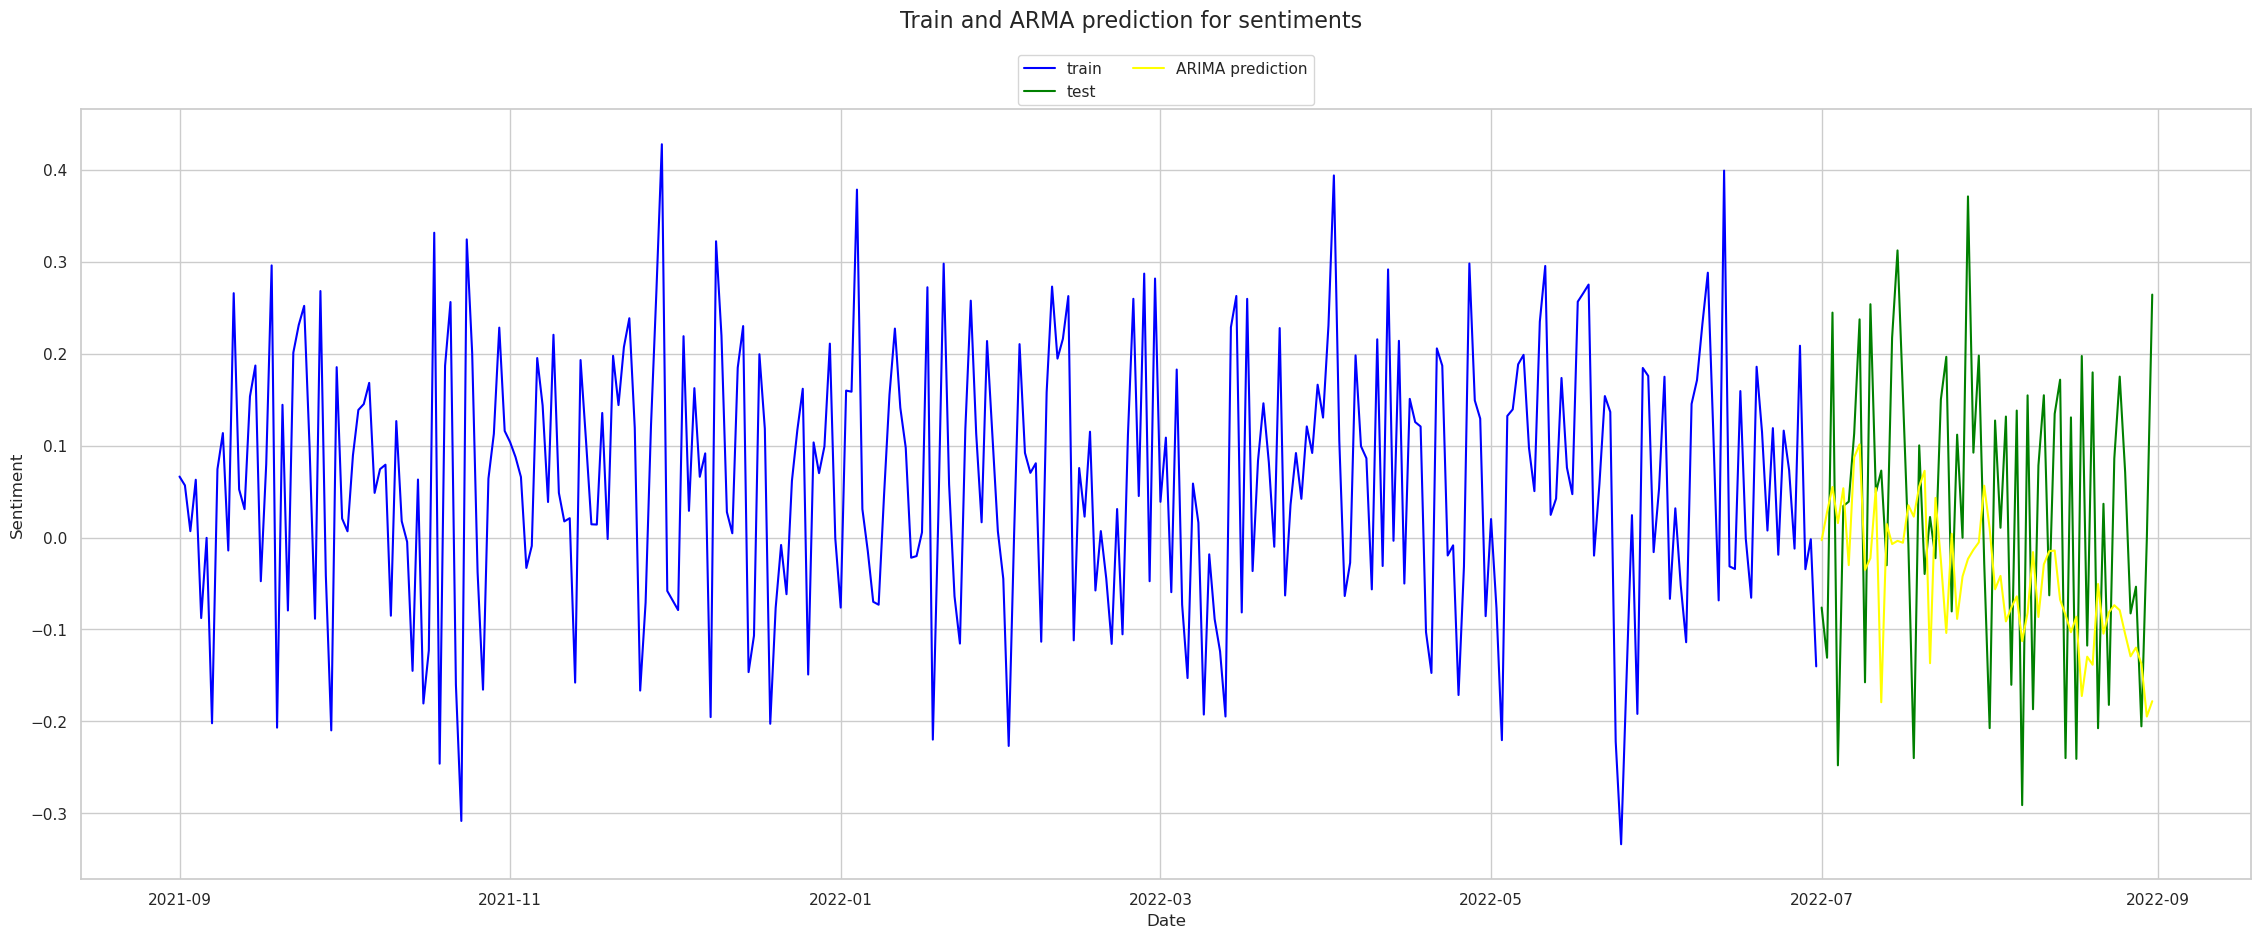

In [63]:
# Visualise train, test and predictions of ARMA model
fig, axes = plt.subplots(figsize=(28, 10))
fig.suptitle("Train and test and ARIMA prediction", fontsize=16)

sns.set_theme(style="whitegrid")

sns.lineplot(data=train, x="date", y="average sentiment", 
             linestyle="-", color="blue")
sns.lineplot(data=test, x="date", y="average sentiment", 
             linestyle="-", color="green")
sns.lineplot(data=y_pred_outARIMA, x="date", y="prediction", 
             linestyle="-", color="red")

axes.set_xlabel("Date")
axes.set_ylabel("Sentiment")

# Create proxy artists for the legend entries
train_proxy = plt.Line2D([], [], linestyle="-", color="blue", label="train")
test_proxy = plt.Line2D([], [], linestyle="-", color="green", label="test")
arima_proxy = plt.Line2D([], [], linestyle="-", color="yellow", label="ARIMA prediction")

# Create the legend
plt.legend(handles=[train_proxy, test_proxy, arima_proxy], loc="upper center", 
           bbox_to_anchor=(0.5, 1.08), ncol=2)

plt.show()

In [57]:
from sklearn.metrics import mean_squared_error

arima_rmse = np.sqrt(mean_squared_error(test["average sentiment"].values, y_pred_df["Predictions"]))
print("ARIMA RMSE: ", arima_rmse)

ARMA RMSE:  0.16155112032176178
